In [1]:
# General
import sys
import os
from time import time
from math import ceil
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/time_cells')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
import spike_preproc
import events_preproc
import time_bin_analysis
import place_analysis

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [2]:
analysis_dir = '/home1/dscho/projects/time_cells/analysis'
event_files = glob(os.path.join(analysis_dir, 'events', '*.pkl'))
sessions =  [os.path.basename(f).split('-')[0] for f in event_files]
event_times = pd.concat([events_preproc.create_event_time_bins(subj_sess) for subj_sess in sessions], axis=0)
print('{} sessions:\n{}'.format(len(sessions), sessions))

Found event_times
Found event_times
2 sessions:
['U518_ses0', 'U518_ses1']


In [3]:
subj_sess = 'U518_ses0'
event_times = events_preproc.create_event_time_bins(subj_sess)
spike_files = glob(os.path.join(analysis_dir, 'spikes', '{}*CSC*.pkl'.format(subj_sess)))
print('Found {} neurons'.format(len(spike_files)))

Found event_times
Found 56 neurons


In [29]:
# Load data.
subj_sess = 'U518_ses0'
data_dir = '/home1/dscho/projects/time_cells/data'
analysis_dir = '/home1/dscho/projects/time_cells/analysis'

sampling_rate = 30000

# --------------------------------------
## Get subject directories.
subj, sess = subj_sess.split('_')
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_sortbyhand')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

# --------------------------------------
## Load events.
events_f = os.path.join(analysis_dir, 'events', '{}_events_formatted.pkl'.format(subj_sess))
events = dio.open_pickle(events_f)
print('Events shape: {}'.format(events.shape))
print('{} min, {} sec\n'.format(int((events.iloc[-1]['time'] - events.iloc[0]['time'])/6e4), 
                                int(((events.iloc[-1]['time'] - events.iloc[0]['time'])%6e4)/1e3)))

# --------------------------------------
## Load spikes and lfp timestamps.
spikes_f = os.path.join(analysis_dir, 'spikes', '{}_spikes.pkl'.format(subj_sess))
spikes = dio.open_pickle(spikes_f)

lfp_timestamps_f = os.path.join(data_dir, subj, sess, 'micro_lfps', 'lfpTimeStamps_micro.mat')
with h5py.File(lfp_timestamps_f, 'r') as f:
    sess_start, sess_stop = (int(np.squeeze(f['timeStamps'])[0] * 1e3), 
                             int(np.squeeze(f['timeStamps'])[-1] * 1e3))

print('Spikes shape: {}'.format(spikes.shape))
display(spikes.groupby('hemroi').agg({'unit': len, 'chan': lambda x: len(np.unique(x)), 'fr': np.median}))

Events shape: (72204, 8)
67 min, 7 sec

Spikes shape: (56, 9)


unit  chan        fr
hemroi                      
LA         6     6  1.404691
LAI        8     7  0.362474
LMH       11     7  2.854589
LO         6     5  4.220033
LTO        3     3  2.105804
LTPO       5     3  2.596706
REC        6     6  1.036155
RIP        2     2  0.205895
RTO        9     7  6.428990

In [30]:
# Get the start and stop times for each task period, for each trial.
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

dfs = []
for iState, game_state in enumerate(game_states):
    dfs.append(game_state_intervals(events, game_state=game_state, cols=['time']))
    dfs[-1].insert(1, 'trial_phase', iState+1)
    dfs[-1].insert(2, 'gameState', game_state)
    
event_times = pd.concat(dfs, axis=0)

# Divide each task period into 60 time bins of equal duration
# (should be ~500 ms each)
time_bins = []
for idx, row in event_times.iterrows():
    if row['gameState'] in ['Encoding', 'Retrieval']:
        n_time_bins = 60
    elif row['gameState'] in ['Delay1', 'Delay2']:
        n_time_bins = 20
    time_bins.append(np.linspace(row['time'][0], row['time'][1], num=n_time_bins+1))
event_times['time_bins'] = time_bins
event_times = event_times.sort_values(['trial', 'trial_phase']).reset_index(drop=True)
time_bins = event_times['time_bins'].tolist()

print(event_times.shape, len(time_bins))

(144, 6) 144


In [58]:
## For each neuron, get the number of spikes in each time bin.
start_time = time()

spikes_by_time = []
for time_bins in event_times['time_bins']:
    spikes_by_time.append(np.array([[np.sum(np.logical_and(spikes.loc[iUnit, 'spike_times']>time_bins[iTime], 
                                                  spikes.loc[iUnit, 'spike_times']<=time_bins[iTime+1]))
                                     for iTime in range(len(time_bins)-1)]
                                    for iUnit in range(len(spikes))]))

# Combine time bins across trial phases in each trial.
trial_spikes_by_time = []
for iTrial in np.arange(0, len(spikes_by_time), step=len(game_states)):
    arr = [spikes_by_time[i] for i in np.arange(iTrial, iTrial+len(game_states))]
    trial_spikes_by_time.append(np.concatenate(arr, axis=1))
trial_spikes_by_time = np.swapaxes(trial_spikes_by_time, 0, 1) # neuron x trial x time_bin

# Define indices that the mark time bin boundaries:
# [start_delay1, start_encoding, start_delay2, start_retrieval]
time_bounds = np.array([0, 20, 80, 100, 160])

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 24.85 secs


## Null distribution creation

In [28]:
subj_sess = 'U518_ses0'
spikes = spike_preproc.format_spikes(subj_sess, 
                                     fr_thresh=0, 
                                     spikes_dirname='wave_clus3_sortbyhand',
                                     overwrite=False, 
                                     save_output=False)

Found spikes


In [ ]:
start_time = time()

subj_sess = 'U518_ses0'
sigma = 500
spikes = spike_preproc.add_fr_to_spikes(subj_sess, sess_stop, sigma, save_output=True)

print('Done in {:.2f} secs'.format(time() - start_time))

In [816]:
start_time = time()

n_perms = 1000
spikes = add_null_to_spikes(spikes, event_times, n_perms, overwrite=False, save_output=True)

print('Done in {:.2f} secs'.format(time() - start_time))

Found spikes
Done in 6.22 secs


## Activity over the trial

In [88]:
# Z-score spike counts across time and trial to normalize
# contributions from each neuron.
shp = trial_spikes_by_time.shape
trial_spikes_by_time_z = stats.zscore(np.reshape(trial_spikes_by_time, (shp[0], shp[1]*shp[2])), axis=1).reshape(shp)

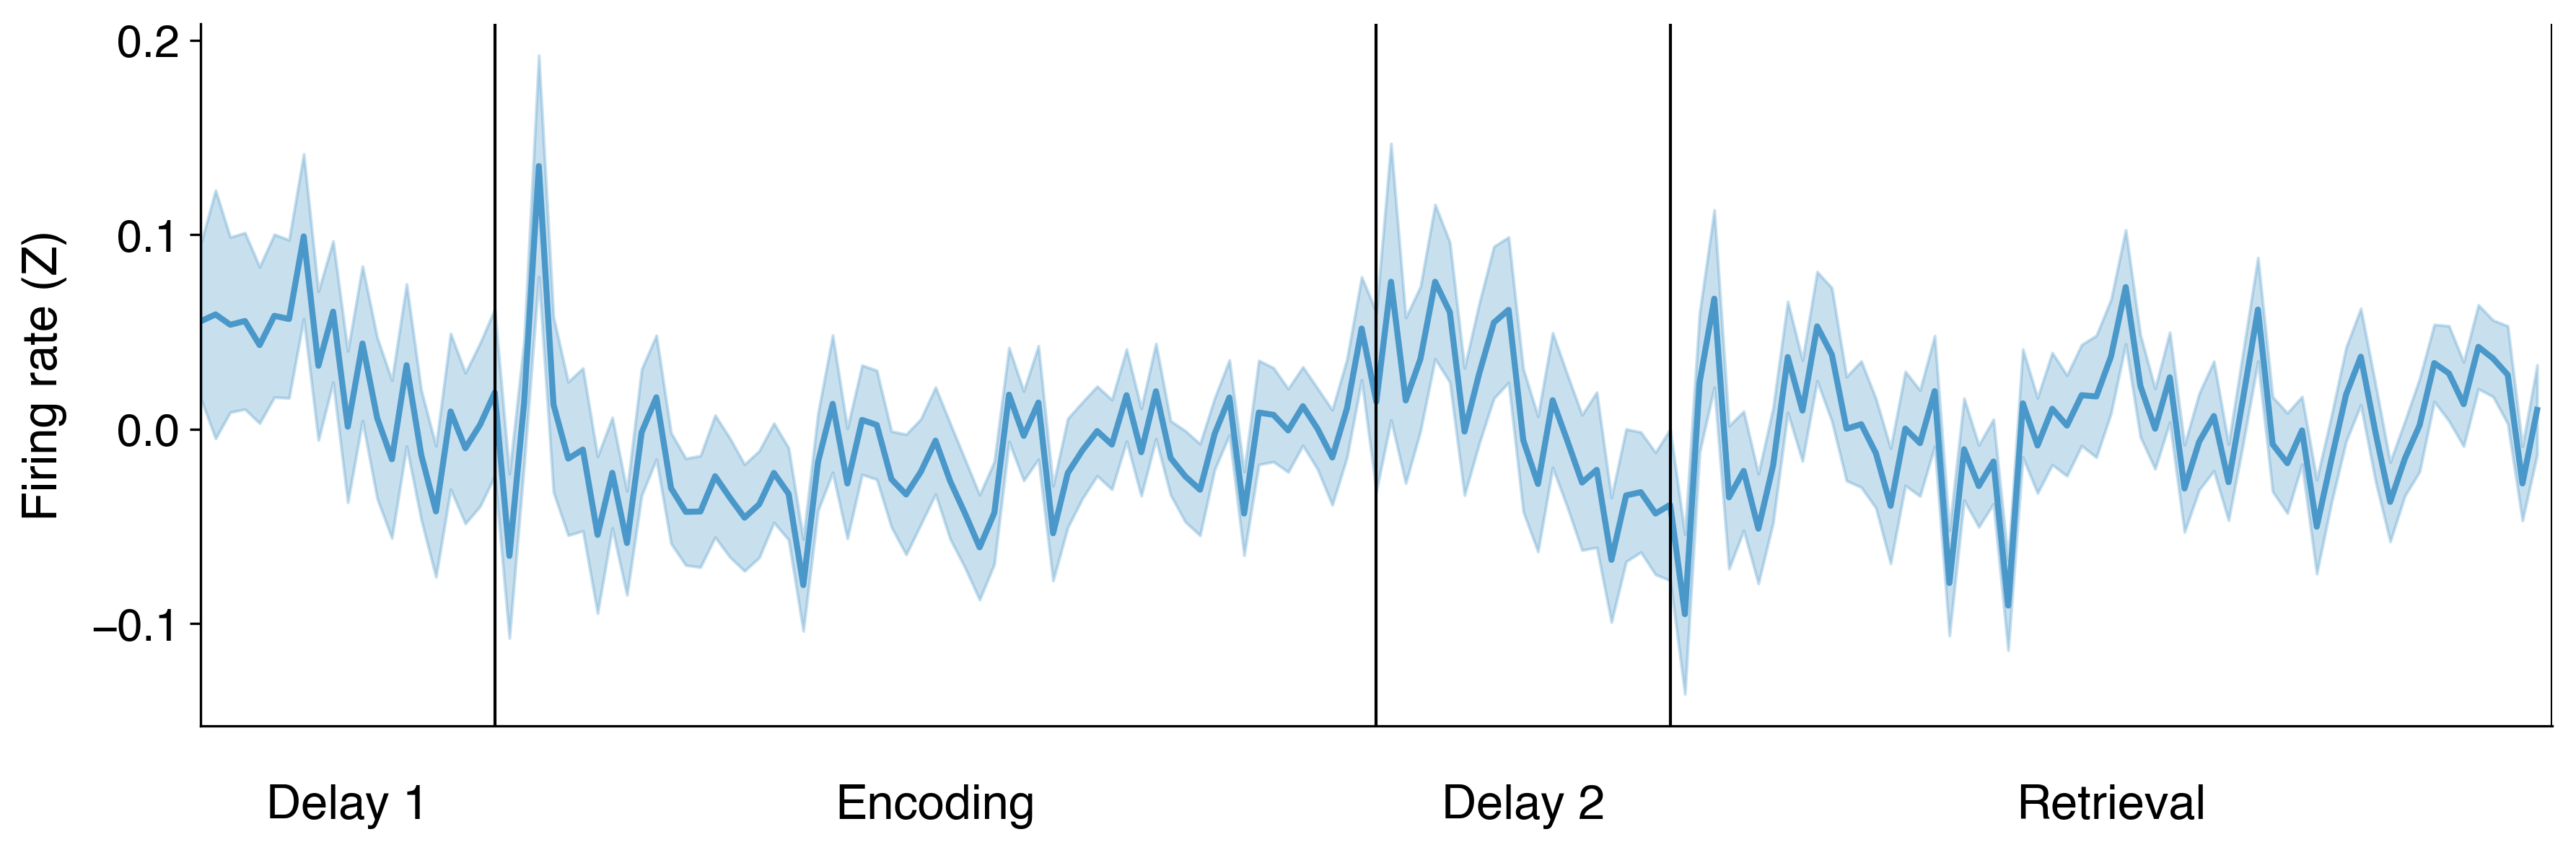

In [223]:
means = np.mean(trial_spikes_by_time_z, axis=(0, 1))
sems = stats.sem(np.mean(trial_spikes_by_time_z, axis=1), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
labelfontsize = 16
tickfontsize = 16

ax.plot(means, color=colors[0], linewidth=2)
ax.fill_between(np.arange(len(means)), means + sems, means - sems, color=colors[0], alpha=0.3)
trial_phase_divides = time_bounds[1:-1]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='k', linewidth=1, alpha=1)
ax.set_xlim([0, len(means)])
ax.set_xticks([])
ax.set_ylabel('Firing rate (Z)', fontsize=labelfontsize, labelpad=8)

ax.annotate('Delay 1', (10, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Encoding', (50, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Delay 2', (90, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Retrieval', (130, -0.2), fontsize=tickfontsize, ha='center', annotation_clip=False)

fig.tight_layout()

In [166]:
# How many neurons are in each region?
rois = od()
for roi, df in spikes.iloc[time_cell_inds].groupby('hemroi', sort=False):
    rois[roi] = [len(df), df.index.tolist()[0]]
rois

OrderedDict([('REC', [13, 1]),
             ('RTO', [14, 6]),
             ('LA', [4, 17]),
             ('LMH', [10, 25]),
             ('LTO', [6, 34]),
             ('LO', [13, 45]),
             ('LTPO', [12, 51]),
             ('RIP', [1, 77]),
             ('LAI', [1, 101])])

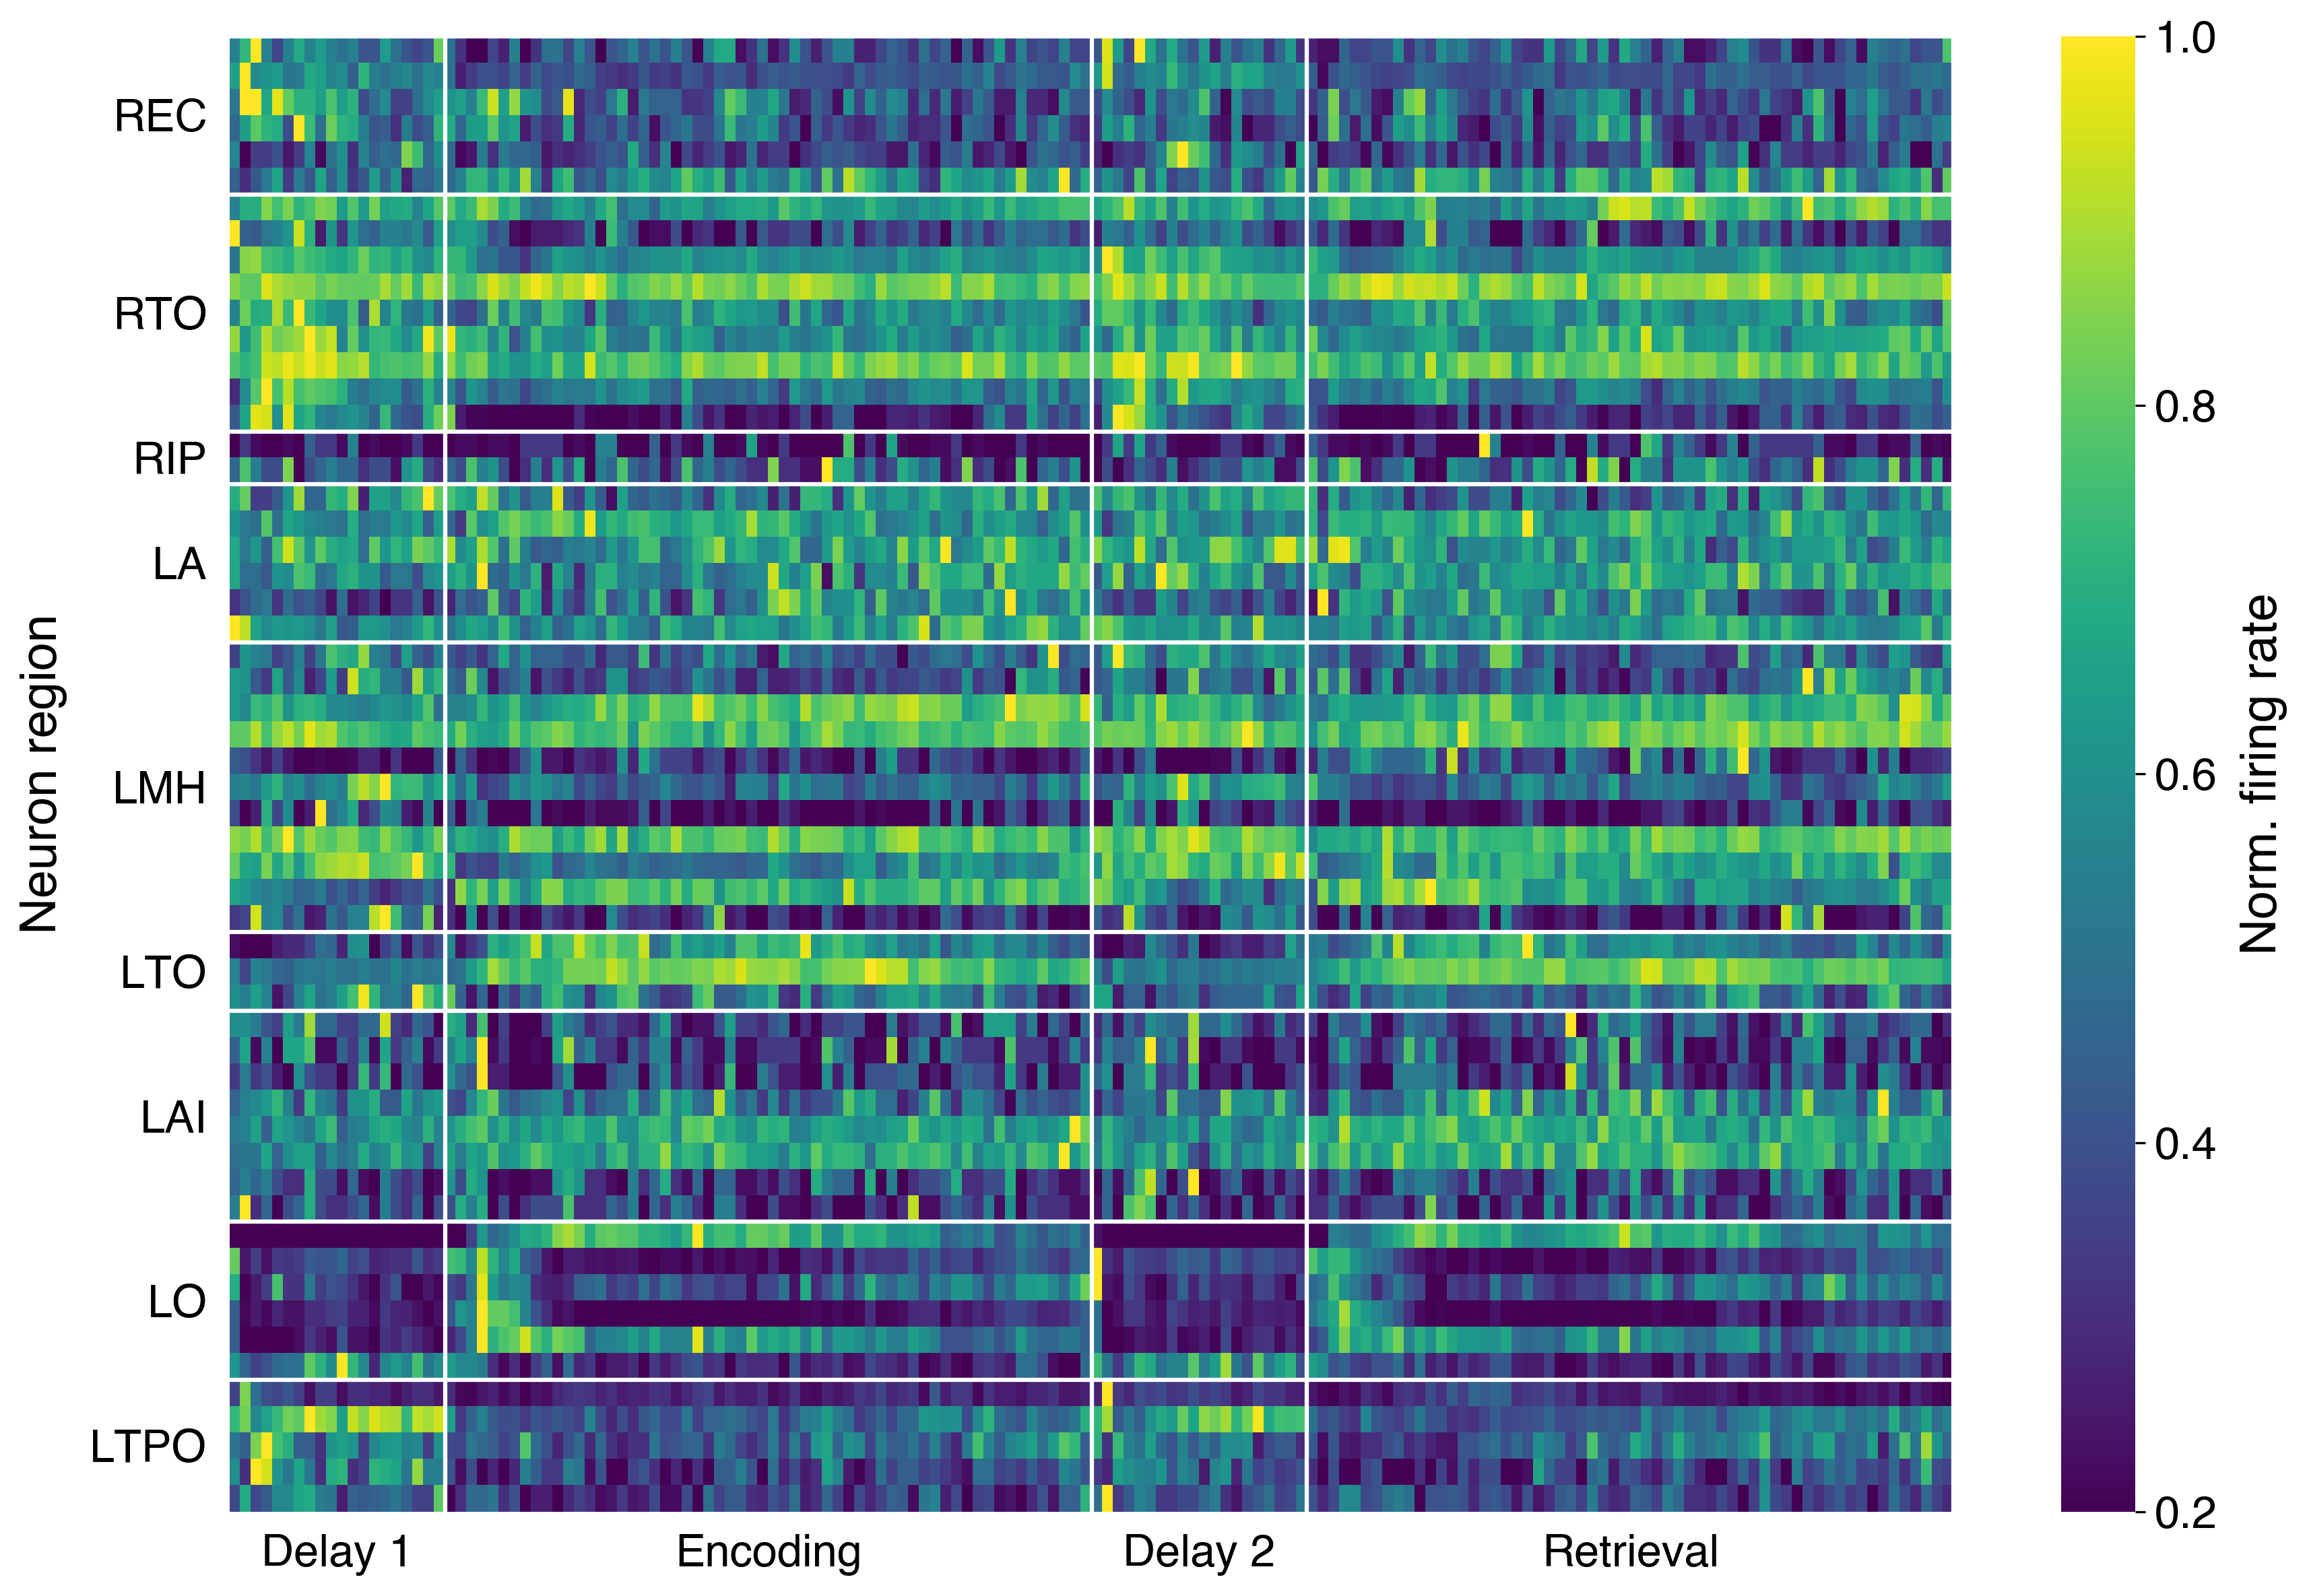

In [250]:
# What do the data look like for firing rates of each neuron
# over the trial (500ms bins; mean over trials)?
dat = np.sum(trial_spikes_by_time, axis=1) # neuron x time
dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1
time_bounds = np.array([0, 20, 80, 100, 160])
xticks = aop.rolling_func(time_bounds, np.mean, window=2)
yticks = (list(np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2) 
          + [np.array(list(rois.values()))[-1, 1] + (np.array(list(rois.values()))[-1, 0]/2)])

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = time_bounds[1:]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1.5, alpha=1)
for iRoi in range(len(rois)):
    ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(xticks)
ax.set_xticklabels(['Delay 1', 'Encoding', 'Delay 2', 'Retrieval'], fontsize=tickfontsize, rotation=0)
ax.set_yticks(yticks)
ax.set_yticklabels(list(rois.keys()), fontsize=tickfontsize)
ax.set_ylabel('Neuron region', fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

## Processing

In [ ]:
start_time = time()
warnings.filterwarnings('ignore')

# NULL DISTRIBUTION
# Calculate the temporal information for each neuron
# during delay intervals.
n_perm = spikes['spike_times_null'].tolist()[0].shape[0]

spike_times_shifted = [pd.Series([x[iPerm, :] for x in spikes['spike_times_null'].tolist()])
                       for iPerm in range(n_perm)]

delay_spikes_by_time_null = np.array([count_spikes_by_time_bin(event_times, 
                                                               spike_times_shifted[iPerm], 
                                                               ['Delay1', 'Delay2'])
                                      for iPerm in range(n_perm)]) # perm x neuron x time_bin

# How much time information does each neuron provide?
time_info_delay_null = np.array([[info_rate(delay_spikes_by_time_null[iPerm, iUnit, :]) 
                                  for iUnit in range(delay_spikes_by_time.shape[0])]
                                 for iPerm in range(n_perm)]) # perm x neuron

# Save.
proj_dir = '/home1/dscho/projects/time_cells'
fname = os.path.join(os.path.join(proj_dir, 'analysis', 'spikes_by_time_bin',
                              '{}_delay_spikes_by_time_bin.pkl'.format(subj_sess)))
dio.save_pickle(od([('delay_spikes_by_time', delay_spikes_by_time),
                    ('time_info_delay', time_info_delay),
                    ('delay_spikes_by_time_null', delay_spikes_by_time_null),
                    ('time_info_delay_null', time_info_delay_null)]), 
                fname)

# -----------------------------------------
# NULL DISTRIBUTION
# Calculate the temporal information for each neuron
# during navigation intervals.
n_perm = spikes['spike_times_null'].tolist()[0].shape[0]

spike_times_shifted = [pd.Series([x[iPerm, :] for x in spikes['spike_times_null'].tolist()])
                       for iPerm in range(n_perm)]

nav_spikes_by_time_null = np.array([count_spikes_by_time_bin(event_times, 
                                                             spike_times_shifted[iPerm], 
                                                             ['Encoding', 'Retrieval'])
                                    for iPerm in range(n_perm)]) # perm x neuron x time_bin

# How much time information does each neuron provide?
time_info_nav_null = np.array([[info_rate(nav_spikes_by_time_null[iPerm, iUnit, :]) 
                                 for iUnit in range(nav_spikes_by_time.shape[0])]
                                for iPerm in range(n_perm)]) # perm x neuron

# Save.
proj_dir = '/home1/dscho/projects/time_cells'
fname = os.path.join(os.path.join(proj_dir, 'analysis', 'spikes_by_time_bin',
                              '{}_nav_spikes_by_time_bin.pkl'.format(subj_sess)))
dio.save_pickle(od([('nav_spikes_by_time', nav_spikes_by_time),
                    ('time_info_nav', time_info_nav),
                    ('nav_spikes_by_time_null', nav_spikes_by_time_null),
                    ('time_info_nav_null', time_info_nav_null)]), 
                fname)

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time)) 

## Time cells

In [278]:
def get_unit_df(analysis_dir='/home1/dscho/projects/time_cells/analysis'):
    """Return a DataFrame with file pointers for each neuron."""
    def format_info(spikes_f):
        x = os.path.basename(spikes_f).split('-')
        subj_sess = x[0]
        chan = x[1][3:]
        unit = x[2][4:]
        fr_by_time_delay_f = os.path.join(analysis_dir, 'spikes_by_time_bin',
                                          '{}-CSC{}-unit{}-{}-fr_by_time_bin.pkl'
                                          .format(subj_sess, chan, unit, 'Delay1_Delay2'))
        fr_by_time_nav_f = os.path.join(analysis_dir, 'spikes_by_time_bin',
                                        '{}-CSC{}-unit{}-{}-fr_by_time_bin.pkl'
                                        .format(subj_sess, chan, unit, 'Encoding_Retrieval'))
        output = od([('subj_sess', subj_sess),
                     ('chan', chan),
                     ('unit', unit),
                     ('spikes_f', spikes_f),
                     ('fr_by_time_delay_f', fr_by_time_delay_f),
                     ('fr_by_time_nav_f', fr_by_time_nav_f)])
        return [subj_sess, chan, unit, spikes_f, fr_by_time_delay_f, fr_by_time_nav_f]
    
    cols = ['subj_sess', 'chan', 'unit', 'spikes_f', 'fr_by_time_delay_f', 'fr_by_time_nav_f']
    spike_files = glob(os.path.join(analysis_dir, 'spikes', '*CSC*.pkl'))
    units = [format_info(x) for x in spike_files]
    unit_df = pd.DataFrame(units, columns=cols)
    return unit_df

In [275]:
# Gather spike info for each neuron.
unit_df = get_unit_df()
cols = ['subj_sess', 'chan', 'unit', 'n_spikes', 'fr', 'hemroi', 'fr_train']
spikes = pd.DataFrame([dio.open_pickle(row['spikes_f'])[cols] for idx, row in unit_df.iterrows()]).reset_index(drop=True)

In [131]:
# Add time cell info for each neuron, separately for delay and task periods.
spikes_by_time_delay = pd.DataFrame([dio.open_pickle(row['fr_by_time_delay_f']) for idx, row in unit_df.iterrows()])
spikes_by_time_nav = pd.DataFrame([dio.open_pickle(row['fr_by_time_nav_f']) for idx, row in unit_df.iterrows()])
spikes_by_time_delay.columns = ['{}_delay'.format(c) for c in spikes_by_time_delay.columns]
spikes_by_time_nav.columns = ['{}_nav'.format(c) for c in spikes_by_time_nav.columns]
spikes = pd.concat((spikes, spikes_by_time_delay, spikes_by_time_nav), axis=1)

# FDR correct p-values.
alpha = 0.05
spikes['temporal_info_sig_delay'] = sm.stats.multipletests(spikes['temporal_info_pval_delay'], alpha=alpha, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
spikes['temporal_info_sig_nav'] = sm.stats.multipletests(spikes['temporal_info_pval_nav'], alpha=alpha, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]

In [107]:
def format_cells(spikes, fr_vec_col, normalize=True, verbose=True):
    time_cell_fr_vecs = np.array(spikes[fr_vec_col].tolist())
    time_cell_inds = np.array(spikes.index.tolist())
    
    # Sort neurons in order of time bin with the highest firing rate.
    time_cell_inds = time_cell_inds[np.argsort(time_cell_fr_vecs.argmax(axis=1))]
    time_cell_fr_vecs = time_cell_fr_vecs[np.argsort(time_cell_fr_vecs.argmax(axis=1)), :] # neuron x time
    
    # For each cell, divide the firing rate in each time bin
    # by its mean firing rate. the firing rate in its maximum time bin
    if normalize:
        time_cell_fr_vecs = time_cell_fr_vecs / np.expand_dims(np.max(time_cell_fr_vecs, axis=-1), axis=-1)
    
    if verbose:
        print('min={:.2f}; max={:.2f}'.format(np.min(time_cell_fr_vecs), np.max(time_cell_fr_vecs)))
    
    return time_cell_fr_vecs, time_cell_inds

min=0.17; max=1.00
min=0.05; max=1.00


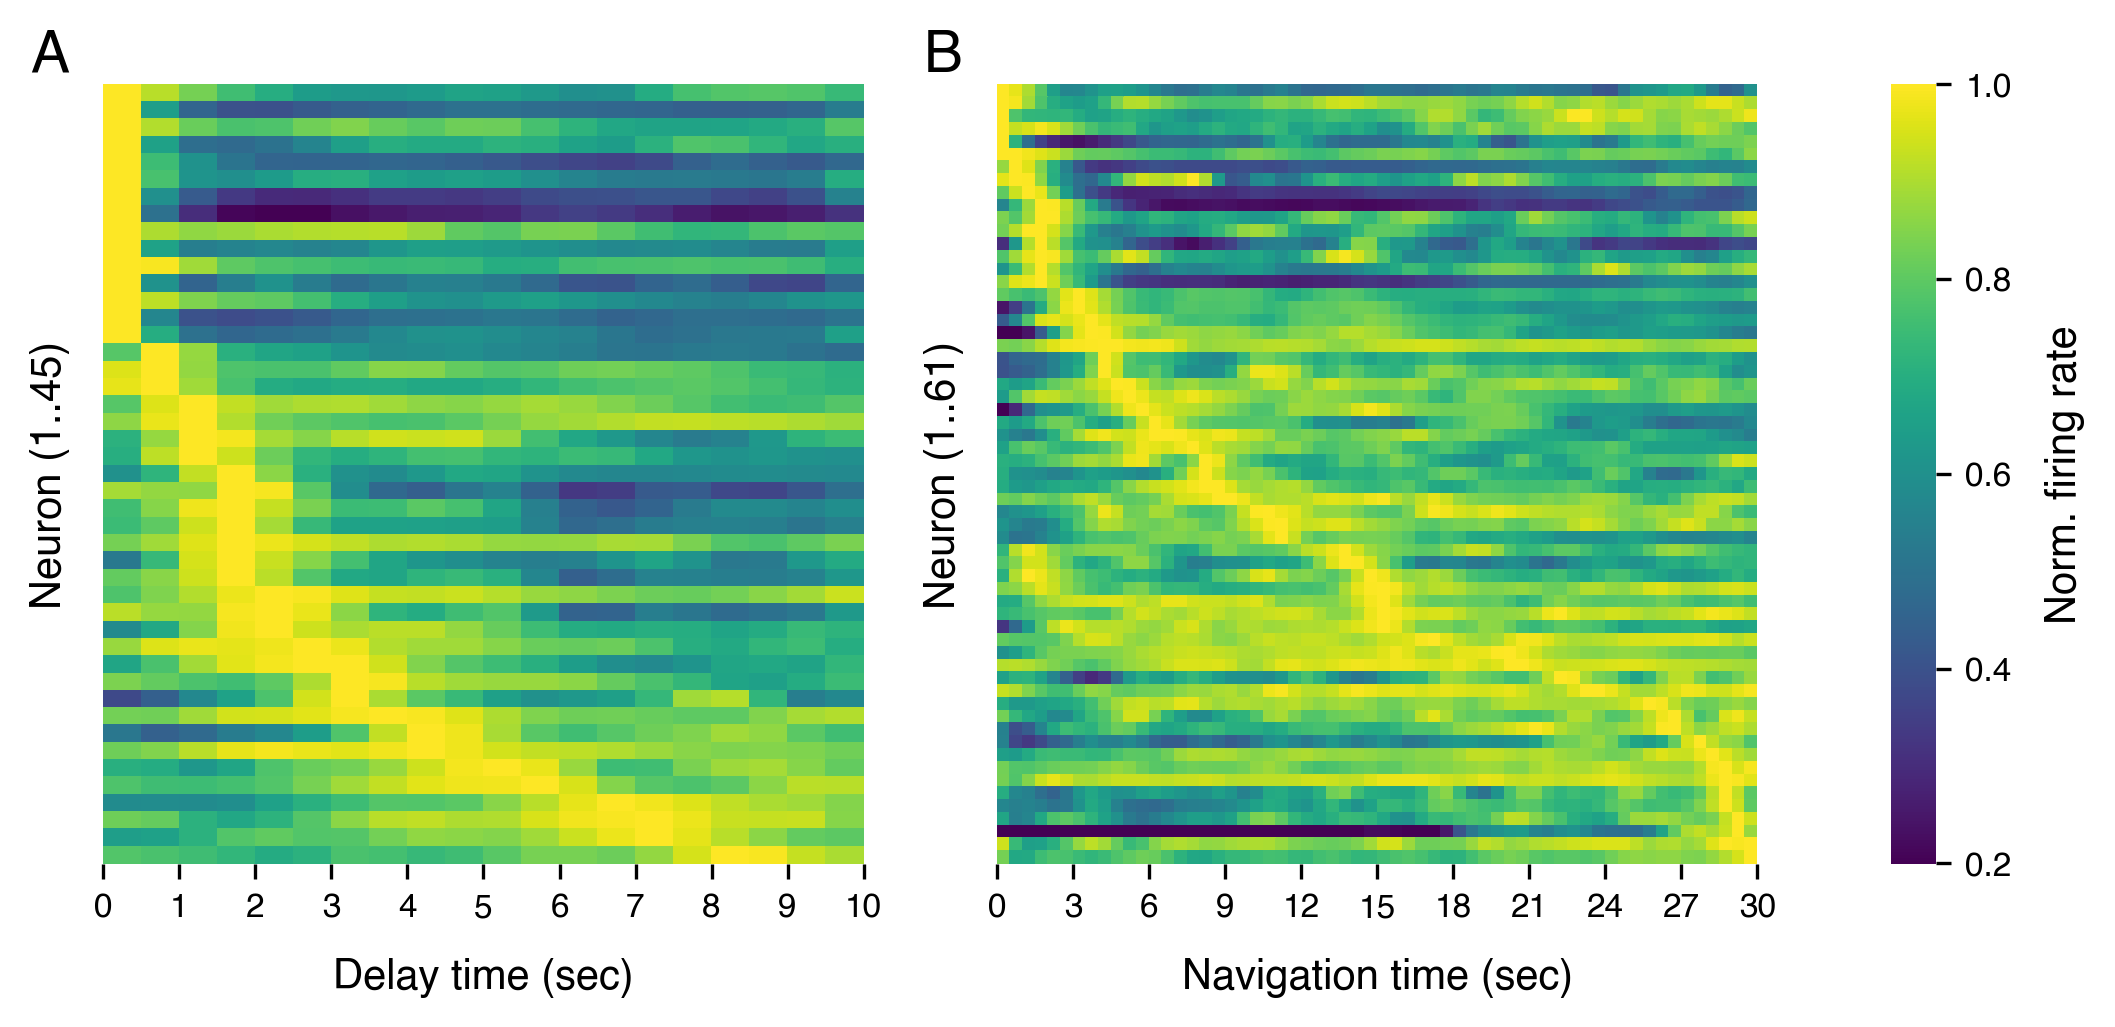

In [380]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
delay_time_cell_fr_vecs, delay_time_cell_inds = format_cells(spikes.query("(temporal_info_sig_delay==True)"), 'fr_vec_delay')
nav_time_cell_fr_vecs, nav_time_cell_inds = format_cells(spikes.query("(temporal_info_sig_nav==True)"), 'fr_vec_nav')
dat = [(delay_time_cell_fr_vecs, delay_time_cell_inds),
       (nav_time_cell_fr_vecs, nav_time_cell_inds)]
time_cell_inds = np.unique(list(dat[0][1]) + list(dat[1][1]))

fig = plt.figure(figsize=(6.85039, 6.85039*0.45), dpi=300)
ax1 = plt.subplot2grid((1, 11), (0, 0), colspan=5)
ax2 = plt.subplot2grid((1, 11), (0, 5), colspan=5)
ax3 = plt.subplot2grid((1, 11), (0, 10), colspan=1)
ax = [ax1, ax2, ax3]

tickfontsize = 8
labelfontsize = 10

vmin = 0.2
vmax = 1

for i in range(2):
    ax[i] = sns.heatmap(dat[i][0], vmin=vmin, vmax=vmax, cmap='viridis', square=False, ax=ax[i], 
                        cbar=True, cbar_ax=ax[2])
    
    if i == 0:
        ax[i].set_xticks(np.linspace(0, 20, 11))
        ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
        ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)
    else:
        ax[i].set_xticks(np.linspace(0, 60, 11))
        ax[i].set_xticklabels(np.linspace(0, 30, 11, dtype=int), fontsize=tickfontsize, rotation=0)
        ax[i].set_xlabel('Navigation time (sec)', fontsize=labelfontsize, labelpad=8)
    
    ax[i].set_yticks([])
    ax[i].set_ylabel('Neuron (1..{})'.format(dat[i][0].shape[0]), fontsize=labelfontsize, labelpad=8)
    
cbar = ax[0].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

fig.text(0, 1, 'A', fontsize=figfontsize)
fig.text(0.435, 1, 'B', fontsize=figfontsize)
fig.tight_layout(pad=0, w_pad=1, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_delay_nav.png', 
                format='png', dpi=300, bbox_inches='tight')

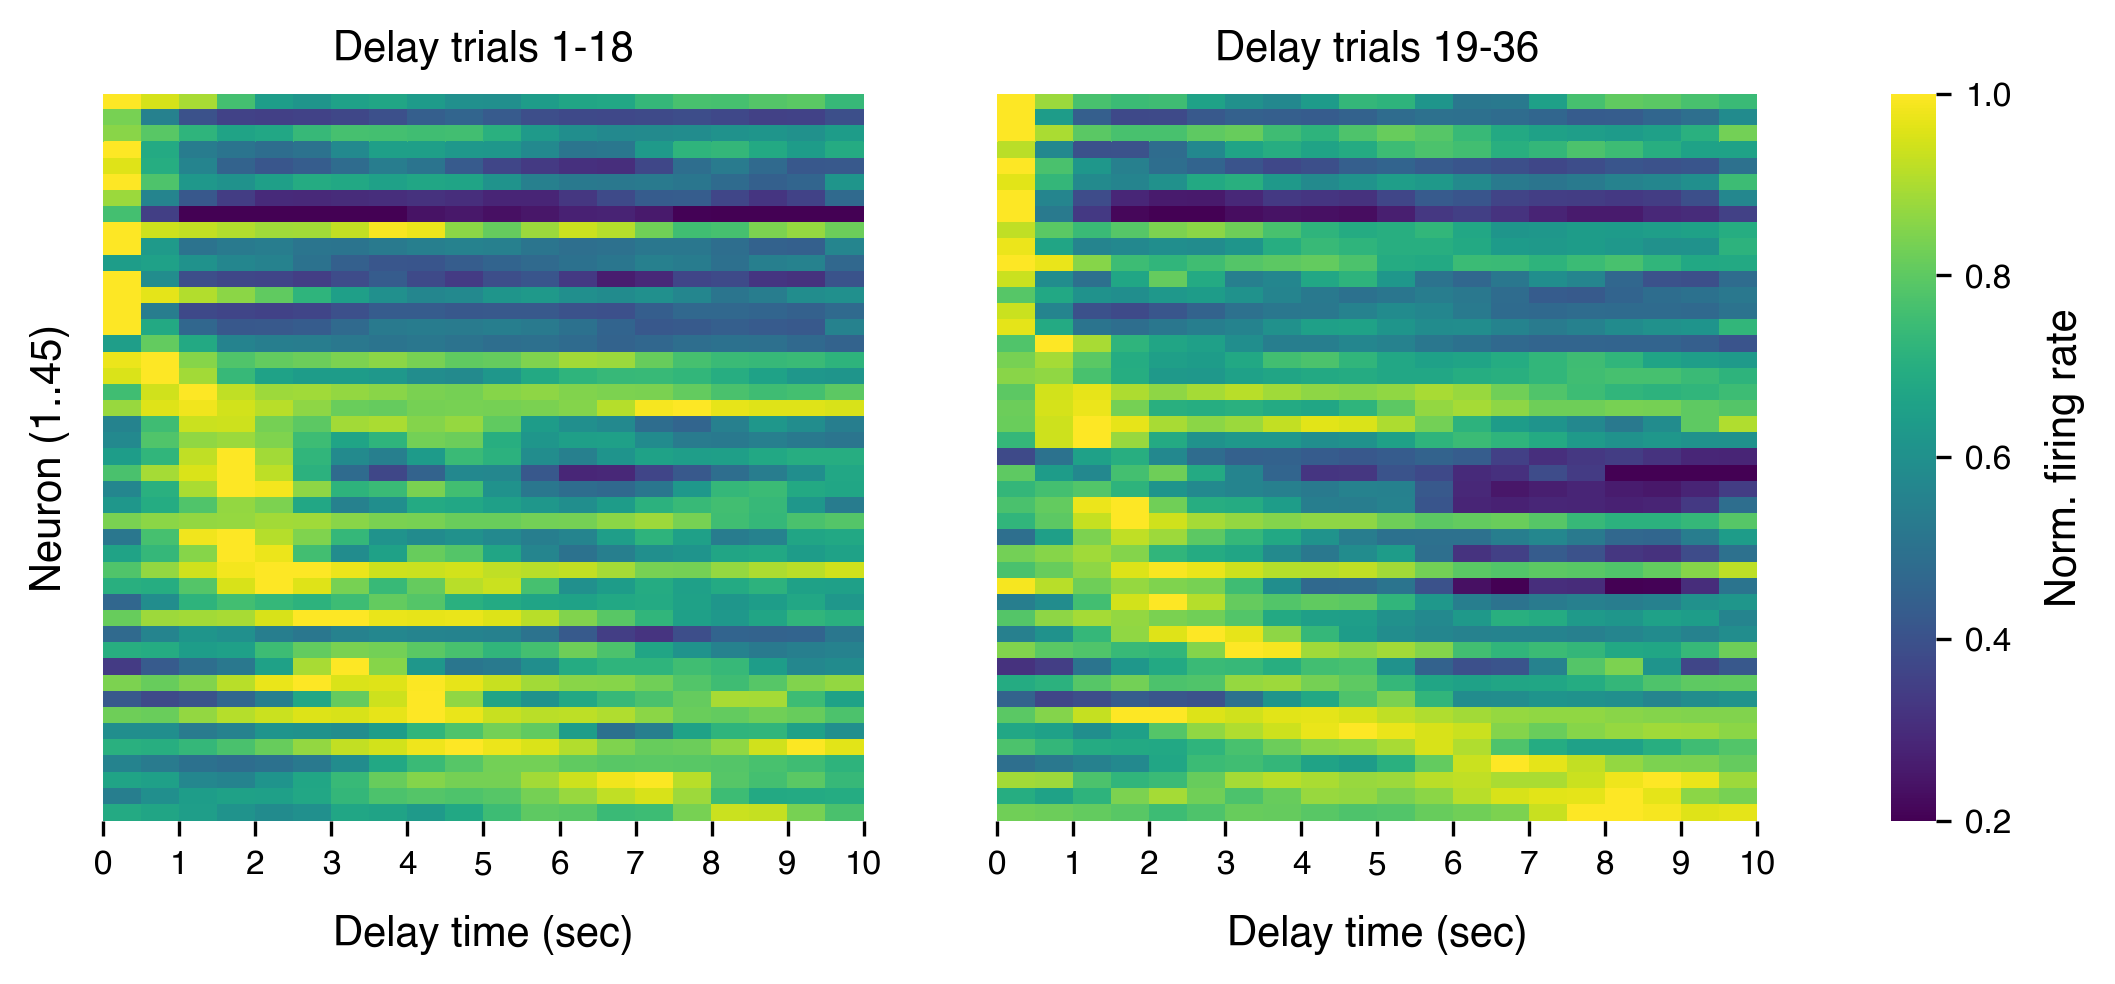

In [453]:
# Time cell stability during the delay interval.
dat = [np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                  event_times.query("(subj_sess=='{}') & (trial<=18)"
                                                                                    .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                  ['Delay1', 'Delay2'], 20), axis=0)
                 for iCell in delay_time_cell_inds]),
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                  event_times.query("(subj_sess=='{}') & (trial>18)"
                                                                                    .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                  ['Delay1', 'Delay2'], 20), axis=0)
                 for iCell in delay_time_cell_inds]), delay_time_cell_inds]

# Divide values by their row-wise max.
div_by = np.expand_dims(np.max(np.concatenate((dat[0], dat[1]), axis=1), axis=-1), axis=-1)
for i in range(len(dat)):
#     dat[i] = dat[i] / np.expand_dims(np.max(dat[i], axis=-1), axis=-1)
    dat[i] = dat[i] / div_by

fig = plt.figure(figsize=(6.85039, 6.85039*0.45), dpi=300)
ax1 = plt.subplot2grid((1, 11), (0, 0), colspan=5)
ax2 = plt.subplot2grid((1, 11), (0, 5), colspan=5)
ax3 = plt.subplot2grid((1, 11), (0, 10), colspan=1)
ax = [ax1, ax2, ax3]

tickfontsize = 8
labelfontsize = 10

vmin = 0.2
vmax = 1

for i in range(2):
    ax[i] = sns.heatmap(dat[i], vmin=vmin, vmax=vmax, cmap='viridis', square=False, ax=ax[i], 
                        cbar=True, cbar_ax=ax[2])
    ax[i].set_xticks(np.linspace(0, 20, 11))
    ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=8)
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Neuron (1..{})'.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay trials 1-18', pad=8, fontsize=labelfontsize)
    else:
        ax[i].set_ylabel(' '.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay trials 19-36', pad=8, fontsize=labelfontsize)
    
cbar = ax[0].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

fig.tight_layout(pad=0, w_pad=1, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cell_delay_stability.png', 
                format='png', dpi=300, bbox_inches='tight')

In [788]:
files = glob(os.path.join(analysis_dir, 'classifiers', 'LinearSVM-Delay1_Delay2-20_time_bins-10perms-*'))
print(len(files))
output = od([('obs', []), ('null', [])])

output['obs'] = time_bin_analysis.classify_time_bins(spikes.iloc[delay_time_cell_inds], 
                                                     event_times,
                                                     ['Delay1', 'Delay2'],
                                                     n_time_bins=20,
                                                     k=6,
                                                     n_perms=0)['obs']
for f in files:
    output['null'] += dio.open_pickle(f)['null']

100


In [792]:
output['null'][0]

array([[ 0, 19],
       [ 1, 19],
       [ 2, 19],
       ...,
       [17, 11],
       [18, 11],
       [19, 12]])

In [785]:
start_time = time()

output_f = os.path.join(analysis_dir, 'classifiers', 'LinearSVM-Delay1_Delay2-20_time_bins.pkl')
output = time_bin_analysis.classify_time_bins(spikes.iloc[delay_time_cell_inds], 
                                              event_times, 
                                              ['Delay1', 'Delay2'], 
                                              n_time_bins=20, 
                                              k=6, 
                                              n_perms=2,
                                              save_as=output_f)

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 8.81 secs


In [808]:
f1_scores

array([0.34520548, 0.29292929, 0.21004566, 0.21621622, 0.10852713,
       0.05084746, 0.10434783, 0.05769231, 0.05172414, 0.07843137,
       0.06818182, 0.01960784,        nan, 0.04724409, 0.07692308,
       0.07476636, 0.11627907, 0.08571429, 0.0952381 , 0.20987654])

In [815]:
def f1_scores(arr):
    """Return F1 for each category in arr[:, 0]."""
    true_col, pred_col = 0, 1
    f1_scores = []
    for iTime in np.unique(arr[:, 0]):
        correct_pred = (arr[:, true_col] == arr[:, pred_col])
        tp = np.sum(correct_pred[np.where(arr[:, true_col]==iTime)[0]])
        fp = np.sum(np.invert(correct_pred[np.where(arr[:, pred_col]==iTime)[0]]))
        fn = np.sum(np.invert(correct_pred[np.where(arr[:, true_col]==iTime)[0]]))
        if (tp == 0) or (fp == 0) or (fn == 0):
            f1_scores.append(0)
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = (2 * precision * recall) / (precision + recall)
            f1_scores.append(f1)
    return np.array(f1_scores)

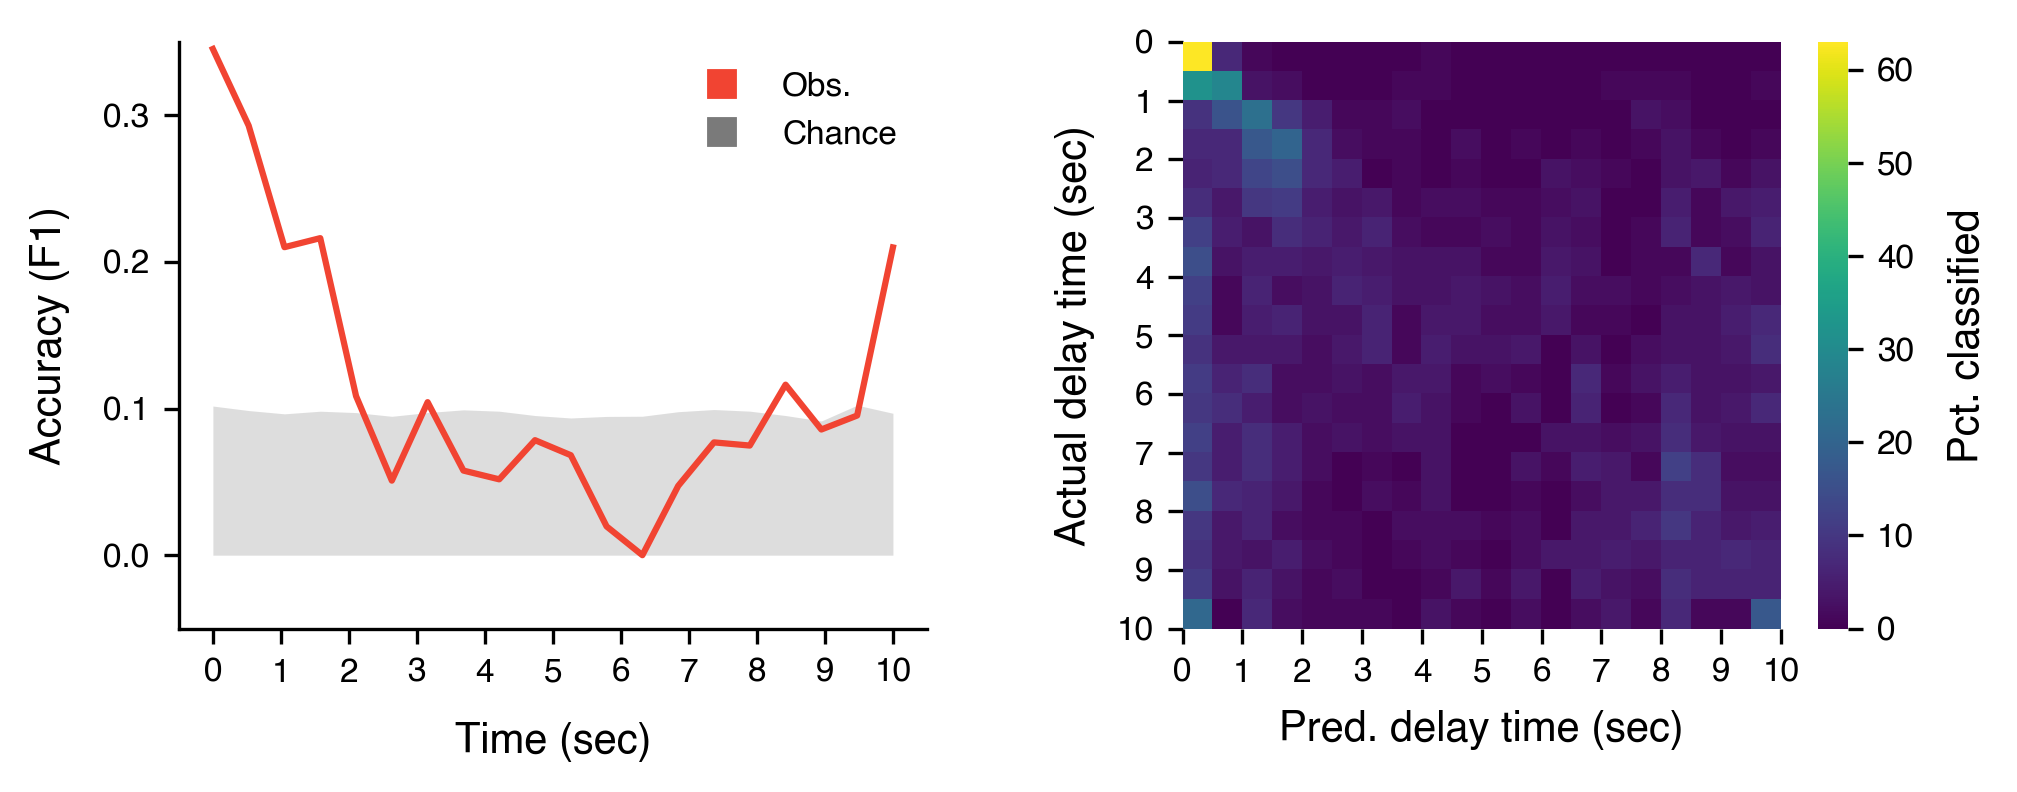

In [845]:
f1_obs = f1_scores(output['obs'])
f1_null = np.array([f1_scores(output['null'][iPerm])
                    for iPerm in range(len(output['null']))])

fig, ax = plt.subplots(1, 2, figsize=(6.85039, 6.85039*0.4), dpi=300)
ax = np.ravel(ax)

labelfontsize = 10
tickfontsize = 8
x_ax = np.arange(n_time_bins)

i = 0
means = np.mean(f1_null, axis=0)
stds = np.std(f1_null, axis=0)
ax[i].fill_between(x_ax, np.min(f1_null, axis=0), np.percentile(f1_null, 95, axis=0), 
                   color=colors[5], alpha=0.25, linewidth=0)
ax[i].plot(x_ax, f1_obs, linewidth=1.5, color=colors[1])

ax[i].set_xticks(np.linspace(0, 19, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=8)

ax[i].set_ylim([-0.05, 0.35])
ax[i].set_yticks([0.0, 0.1, 0.2, 0.3])
ax[i].set_yticklabels([0.0, 0.1, 0.2, 0.3], fontsize=tickfontsize)
ax[i].set_ylabel('Accuracy (F1)', fontsize=labelfontsize, labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Obs.', markerfacecolor=colors[1], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Chance', markerfacecolor=colors[5], markersize=tickfontsize)]
legend = ax[i].legend(handles=custom_lines, loc=1, fontsize=tickfontsize)

# -----------------



i = 1
ax[i] = sns.heatmap(confusion_matrix(output['obs'][:, true_col], output['obs'][:, pred_col]), 
                    cmap='viridis', square=False, ax=ax[i], cbar=True)
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Pred. delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_yticks(np.linspace(0, 20, 11))
ax[i].set_yticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_ylabel('Actual delay time (sec)', fontsize=labelfontsize, labelpad=5)
    
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 60, 7))
cbar.set_ticklabels(np.linspace(0, 60, 7, dtype=int))
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_label('Pct. classified', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

fig.tight_layout(w_pad=3, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/TimeCellDelayClassifier.png', 
                format='png', dpi=300, bbox_inches='tight')

In [830]:
print(classification_report(output['obs'][:, true_col], output['obs'][:, pred_col]))

             precision    recall  f1-score   support

          0       0.22      0.88      0.35        72
          1       0.23      0.40      0.29        72
          2       0.16      0.32      0.21        72
          3       0.18      0.28      0.22        72
          4       0.12      0.10      0.11        72
          5       0.07      0.04      0.05        72
          6       0.14      0.08      0.10        72
          7       0.09      0.04      0.06        72
          8       0.07      0.04      0.05        72
          9       0.13      0.06      0.08        72
         10       0.19      0.04      0.07        72
         11       0.03      0.01      0.02        72
         12       0.00      0.00      0.00        72
         13       0.05      0.04      0.05        72
         14       0.12      0.06      0.08        72
         15       0.11      0.06      0.07        72
         16       0.10      0.14      0.12        72
         17       0.09      0.08      0.09   

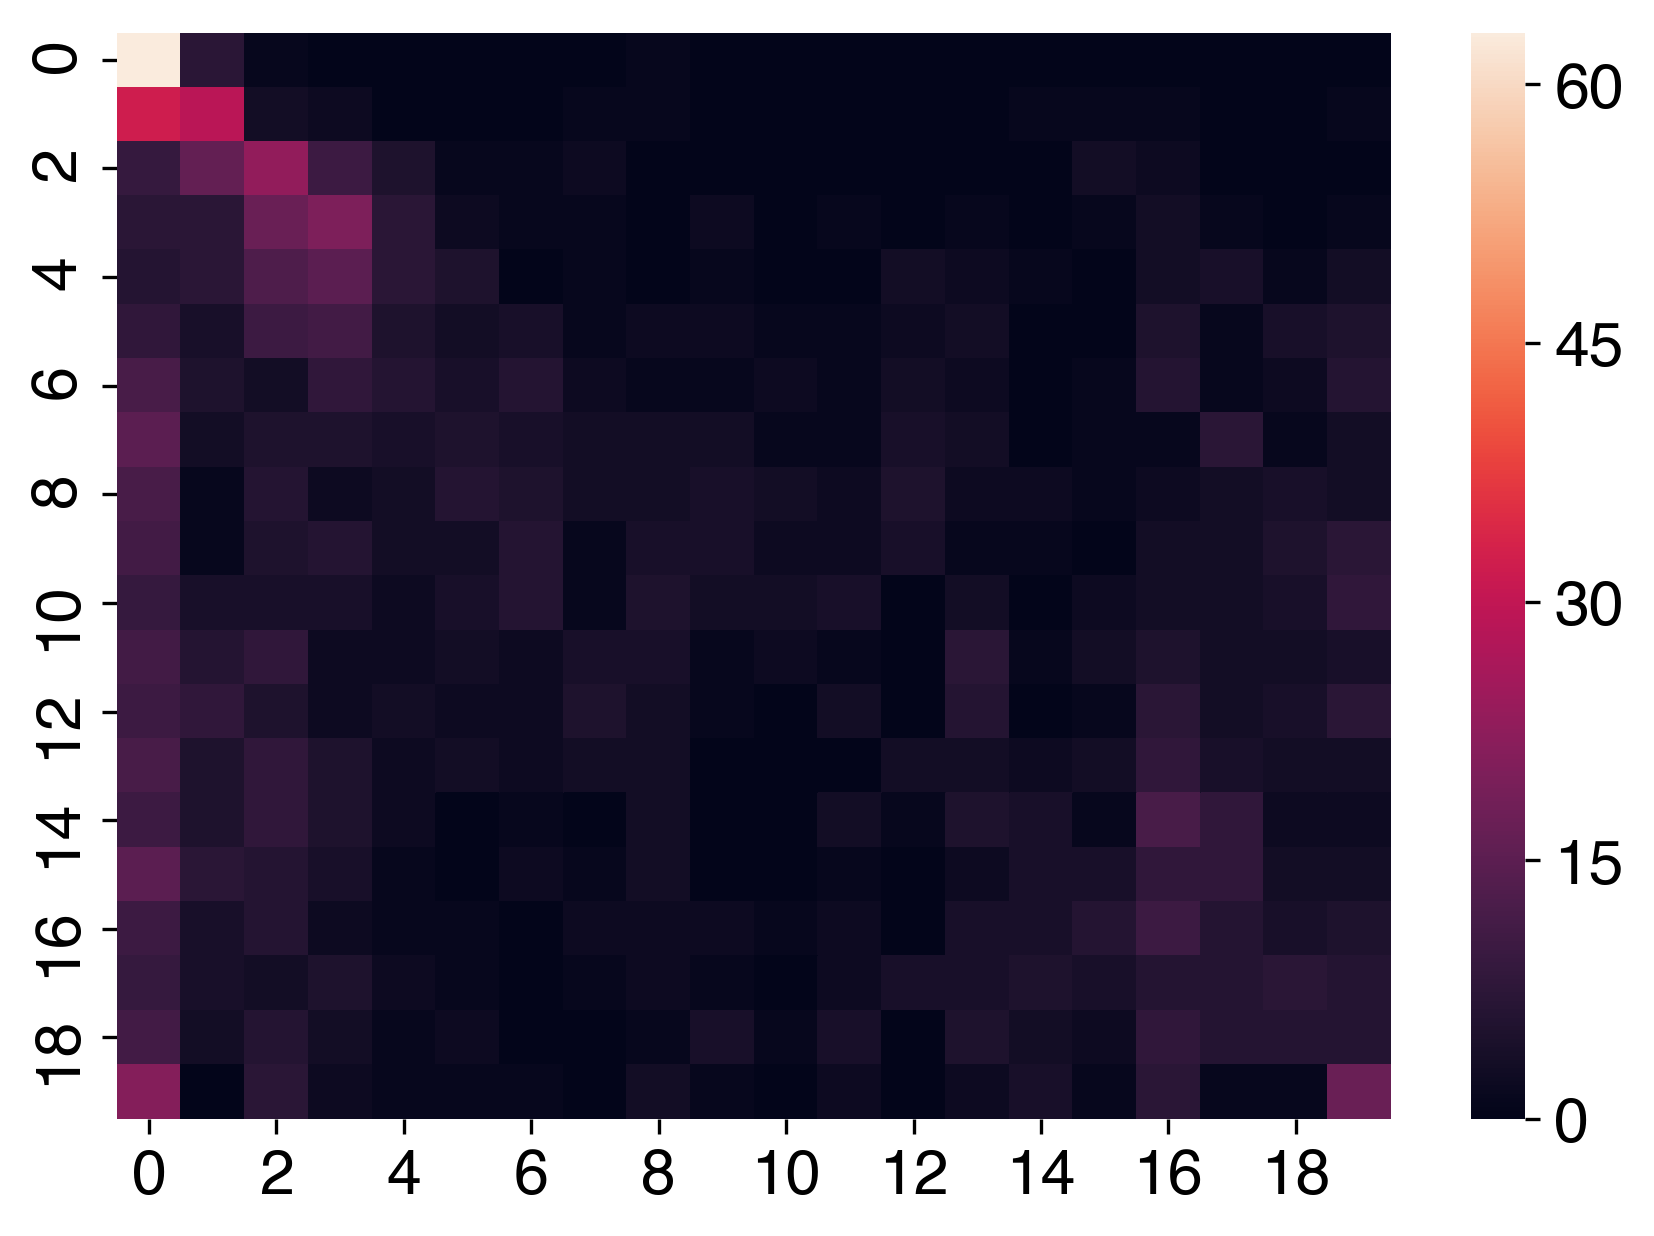

In [829]:
sns.heatmap(confusion_matrix(output['obs'][:, true_col], output['obs'][:, pred_col]))

In [466]:
fr = np.array(([time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                      event_times.query("(subj_sess=='{}')"
                                                                        .format(spikes.iloc[iCell]['subj_sess'])), 
                                                      ['Delay1'], n_time_bins=20)
                for iCell in delay_time_cell_inds],
               [time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                      event_times.query("(subj_sess=='{}')"
                                                                        .format(spikes.iloc[iCell]['subj_sess'])), 
                                                      ['Delay2'], n_time_bins=20)
                for iCell in delay_time_cell_inds]))
dat = np.swapaxes(dat, 0, 1) # neuron x trial_type x trial x time_bin
shp = dat.shape
n_neurons, n_trial_types, n_trials, n_time_bins = shp

# Z-score firing rates for each cell across all time bins from all trials and trial conditions.
zdat = stats.zscore(dat.reshape((n_neurons, np.prod(shp[1:]))), axis=1).reshape(shp)

(45, 2, 36, 20)

In [518]:
# Compute the cosine similarity, at each time bin, between the firing rates 
# across time cells in trial type A and the corresponding firing rates in 
# trial type B, for all possible trial pairs.
start_time = time()

# Get a list of trial pairs within each trial type and between trial types.
intra_pairs = [(x, y) for x in np.arange(n_trials) for y in np.arange(n_trials) if x < y]
inter_pairs = [(x, y) for x in np.arange(n_trials) for y in np.arange(n_trials) if x <= y]

sims = od()
sims['Inter'] = np.array([[aop.cos_sim(zdat[:, 0, iTrialX, iTime], zdat[:, 1, iTrialY, iTime])
                           for iTime in range(n_time_bins)]
                          for iTrialX, iTrialY in inter_pairs])
sims['Delay1'] = np.array([[aop.cos_sim(zdat[:, 0, iTrialX, iTime], zdat[:, 0, iTrialY, iTime])
                            for iTime in range(n_time_bins)]
                           for iTrialX, iTrialY in intra_pairs])
sims['Delay2'] = np.array([[aop.cos_sim(zdat[:, 1, iTrialX, iTime], zdat[:, 1, iTrialY, iTime])
                            for iTime in range(n_time_bins)]
                           for iTrialX, iTrialY in intra_pairs])
    
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.45 secs


In [587]:
# How many ReturnToBase intervals have at lease 5 secs 
df = pd.concat([events_preproc.create_event_time_bins(subj_sess, ['ReturnToBase1', 'ReturnToBase2'], overwrite=True, save_output=False)
                for subj_sess in sessions])
df['duration'] = df['time'].apply(lambda x: x[1] - x[0])
print(np.sum(df['duration']>5000))

45


In [557]:
spikes.columns

Index(['subj_sess', 'chan', 'unit', 'n_spikes', 'fr', 'hemroi', 'fr_train',
       'fr_vec_delay', 'fr_vec_z_delay', 'temporal_info_delay',
       'temporal_info_z_delay', 'temporal_info_pval_delay', 'fr_vec_nav',
       'fr_vec_z_nav', 'temporal_info_nav', 'temporal_info_z_nav',
       'temporal_info_pval_nav', 'temporal_info_sig_delay',
       'temporal_info_sig_nav'],
      dtype='object')

In [569]:
# Train a linear SVM classifier to predict time bin from population responses.
np.mean(spikes.query("(temporal_info_sig_delay==True)")['temporal_info_z_delay'])

7.750687967932438

In [570]:
np.mean(spikes.query("(temporal_info_sig_delay==True)").apply(lambda x: x['temporal_info_delay'] * x['fr'], axis=1))

0.12138981595068178

In [547]:
np.mean(zdat, axis=2).shape

(45, 2, 20)

In [548]:
[aop.cos_sim(np.mean(zdat, axis=2)[:, 0, iTime], np.mean(zdat, axis=2)[:, 1, iTime])
 for iTime in range(n_time_bins)]

[0.9526956379606665,
 0.8156358923055872,
 0.6326754863985435,
 0.5053769144751373,
 0.3863159307470639,
 0.24023179251139684,
 -0.04652249467504677,
 -0.12059659582147632,
 0.02246633884134474,
 0.13888064751162915,
 -0.03894732837258373,
 -0.023111089212861494,
 0.18307874637672603,
 0.28151671929501776,
 0.2690681867288436,
 0.41607233327671705,
 0.5655498369011391,
 0.5518289927284374,
 0.4420399864484826,
 0.2800771548346147]

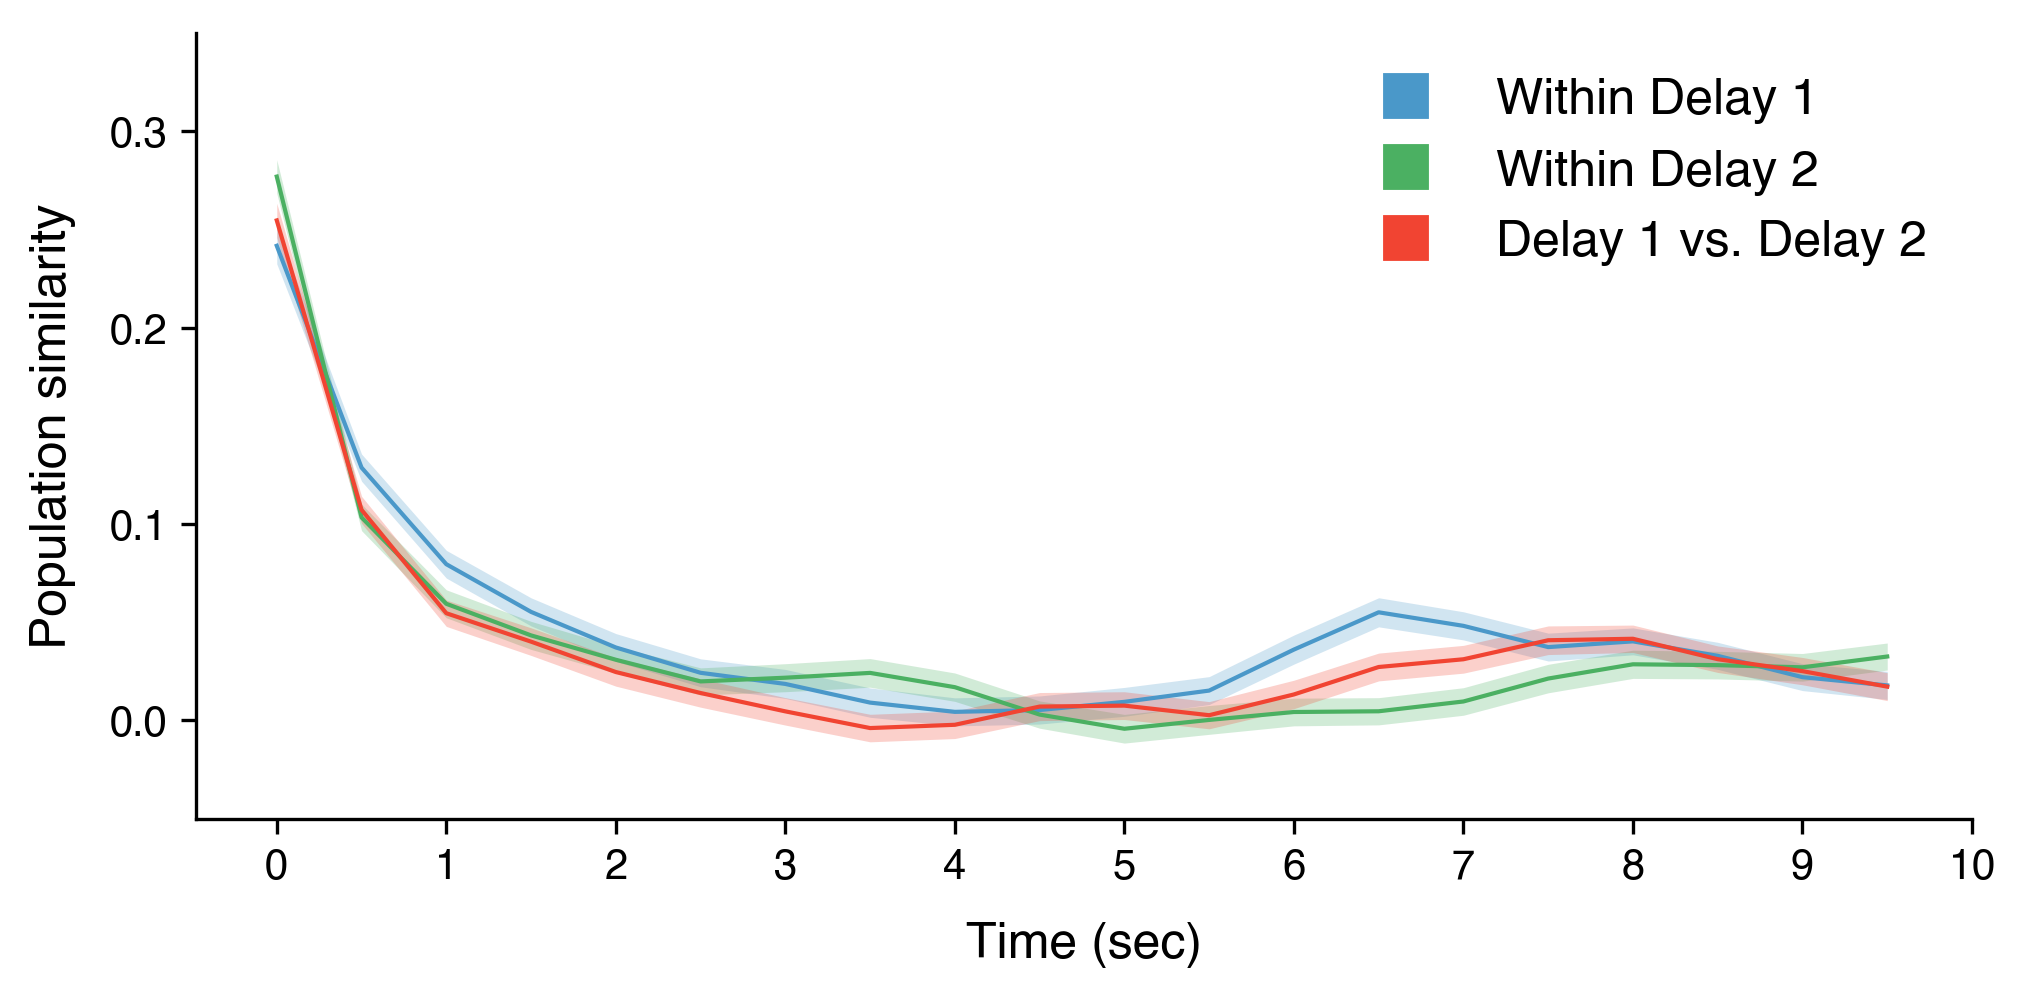

In [546]:
trial_types = ['Delay1', 'Delay2', 'Inter']
color_inds = [0, 2, 1]

fig, ax = plt.subplots(1, 1, figsize=(6.85039, 6.85039*0.5), dpi=300)
ax = np.ravel(ax)

labelfontsize = 12
tickfontsize = 10
x_ax = np.arange(n_time_bins)

i = 0
for ii, trial_type in enumerate(trial_types):
    means = np.mean(sims[trial_type], axis=0)
    sems = stats.sem(sims[trial_type], axis=0)
    ax[i].fill_between(x_ax, means - sems, means + sems, 
                       color=colors[color_inds[ii]], alpha=0.25, linewidth=0)
    ax[i].plot(x_ax, means, linewidth=1, color=colors[color_inds[ii]])

ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=8)

ax[i].set_ylim([-0.05, 0.35])
ax[i].set_yticks([0.0, 0.1, 0.2, 0.3])
ax[i].set_yticklabels([0.0, 0.1, 0.2, 0.3], fontsize=tickfontsize)
ax[i].set_ylabel('Population similarity', fontsize=labelfontsize, labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='Within Delay 1', markerfacecolor=colors[color_inds[0]], markersize=labelfontsize),
                Line2D([0], [0], marker='s', color='w', label='Within Delay 2', markerfacecolor=colors[color_inds[1]], markersize=labelfontsize),
                Line2D([0], [0], marker='s', color='w', label='Delay 1 vs. Delay 2', markerfacecolor=colors[color_inds[2]], markersize=labelfontsize)]
legend = ax[0].legend(handles=custom_lines, loc=1, fontsize=labelfontsize)

fig.tight_layout(pad=1.08, w_pad=1.5, rect=[0, 0, 1, 1])

In [483]:
print(np.mean(dat[0, :, :, :]), np.std(dat[0, :, :, :]), np.mean(dat[-1, :, :, :]), np.std(dat[-1, :, :, :]))
print(np.mean(zdat[0, :, :, :]), np.std(zdat[0, :, :, :]), np.mean(zdat[-1, :, :, :]), np.std(zdat[-1, :, :, :]))
print(np.mean(zdat[0, 0, 0, 0]), np.std(zdat[0, 0, 0, 0]), np.mean(zdat[-1, 0, 0, :]), np.std(zdat[-1, 0, 0, :]))

1.5179229863674992 1.3403108772723393 2.441017358757427 1.4820966217036375
2.1957744264808652e-16 1.0 -1.6776703483224587e-16 1.0
3.91600806968952 0.0 -0.6158669137335779 0.45674846024210247


In [460]:
dat = np.concatenate((time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(spikes.iloc[iCell]['subj_sess'])), ['Delay1'], 20),
                      time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(spikes.iloc[iCell]['subj_sess'])), ['Delay2'], 20)), axis=1).shape

(36, 40)

In [ ]:
# Time cell stability during the delay interval.
dat = [np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay1'], 20), axis=0)
                  for iCell in delay_time_cell_inds]), 
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay2'], 20), axis=0)
                  for iCell in delay_time_cell_inds])]

# Divide values by their row-wise max.
div_by = np.expand_dims(np.max(np.concatenate((dat[0], dat[1]), axis=1), axis=-1), axis=-1)
for i in range(len(dat)):
#     dat[i] = dat[i] / np.expand_dims(np.max(dat[i], axis=-1), axis=-1)
    dat[i] = dat[i] / div_by
    
fig = plt.figure(figsize=(6.85039, 6.85039*0.45), dpi=300)
ax1 = plt.subplot2grid((1, 11), (0, 0), colspan=5)
ax2 = plt.subplot2grid((1, 11), (0, 5), colspan=5)
ax3 = plt.subplot2grid((1, 11), (0, 10), colspan=1)
ax = [ax1, ax2, ax3]

tickfontsize = 8
labelfontsize = 10

vmin = 0.2
vmax = 1

for i in range(2):
    ax[i] = sns.heatmap(dat[i], vmin=vmin, vmax=vmax, cmap='viridis', square=False, ax=ax[i], 
                        cbar=True, cbar_ax=ax[2])
    ax[i].set_xticks(np.linspace(0, 20, 11))
    ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=8)
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Neuron (1..{})'.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay 1', pad=8, fontsize=labelfontsize)
    else:
        ax[i].set_ylabel(' '.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay 2', pad=8, fontsize=labelfontsize)
    
cbar = ax[0].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

fig.tight_layout(pad=0, w_pad=1, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_delay1_vs_delay2.png', 
                format='png', dpi=300, bbox_inches='tight')

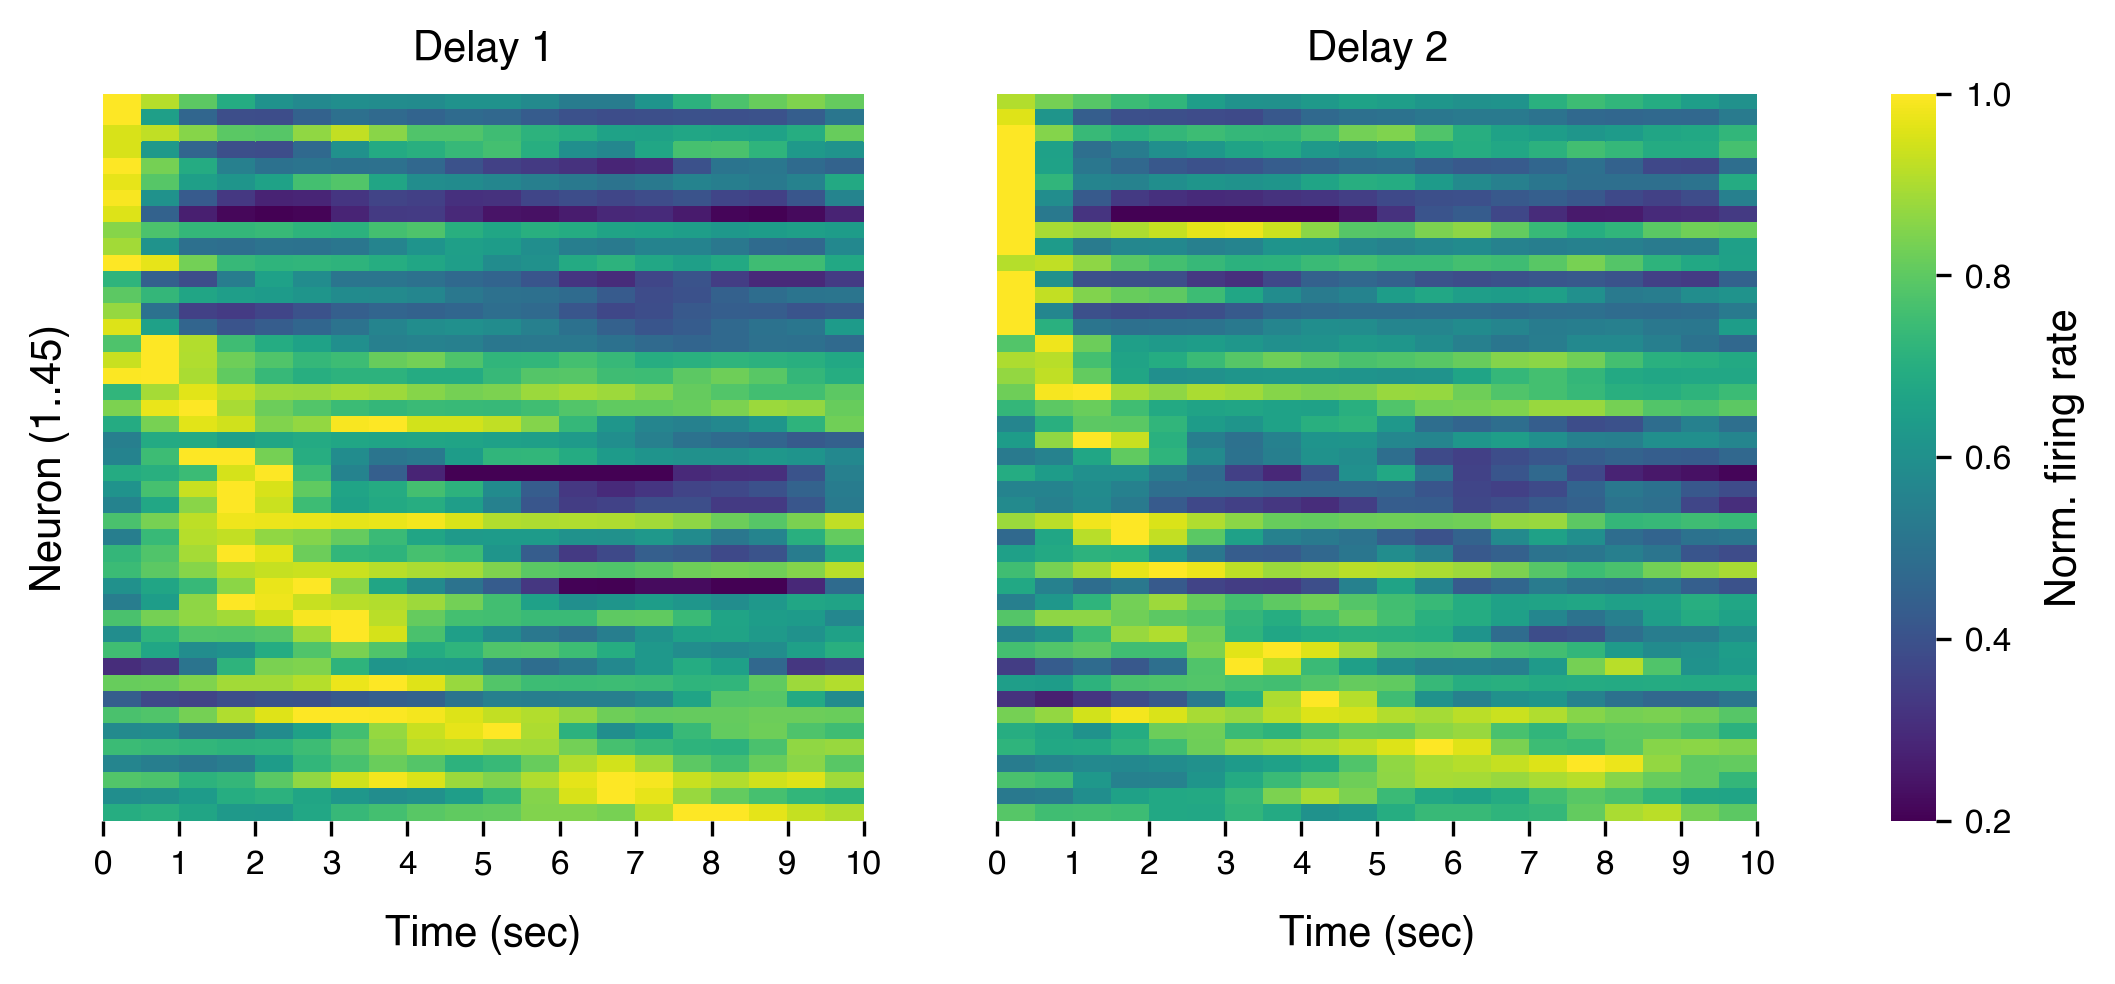

In [424]:
# Time cell stability during the delay interval.
dat = [np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay1'], 20), axis=0)
                  for iCell in delay_time_cell_inds]), 
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay2'], 20), axis=0)
                  for iCell in delay_time_cell_inds])]

# Divide values by their row-wise max.
div_by = np.expand_dims(np.max(np.concatenate((dat[0], dat[1]), axis=1), axis=-1), axis=-1)
for i in range(len(dat)):
#     dat[i] = dat[i] / np.expand_dims(np.max(dat[i], axis=-1), axis=-1)
    dat[i] = dat[i] / div_by
    
fig = plt.figure(figsize=(6.85039, 6.85039*0.45), dpi=300)
ax1 = plt.subplot2grid((1, 11), (0, 0), colspan=5)
ax2 = plt.subplot2grid((1, 11), (0, 5), colspan=5)
ax3 = plt.subplot2grid((1, 11), (0, 10), colspan=1)
ax = [ax1, ax2, ax3]

tickfontsize = 8
labelfontsize = 10

vmin = 0.2
vmax = 1

for i in range(2):
    ax[i] = sns.heatmap(dat[i], vmin=vmin, vmax=vmax, cmap='viridis', square=False, ax=ax[i], 
                        cbar=True, cbar_ax=ax[2])
    ax[i].set_xticks(np.linspace(0, 20, 11))
    ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=8)
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Neuron (1..{})'.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay 1', pad=8, fontsize=labelfontsize)
    else:
        ax[i].set_ylabel(' '.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=8)
        ax[i].set_title('Delay 2', pad=8, fontsize=labelfontsize)
    
cbar = ax[0].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

fig.tight_layout(pad=0, w_pad=1, rect=[0, 0, 1, 1])

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_delay1_vs_delay2.png', 
                format='png', dpi=300, bbox_inches='tight')

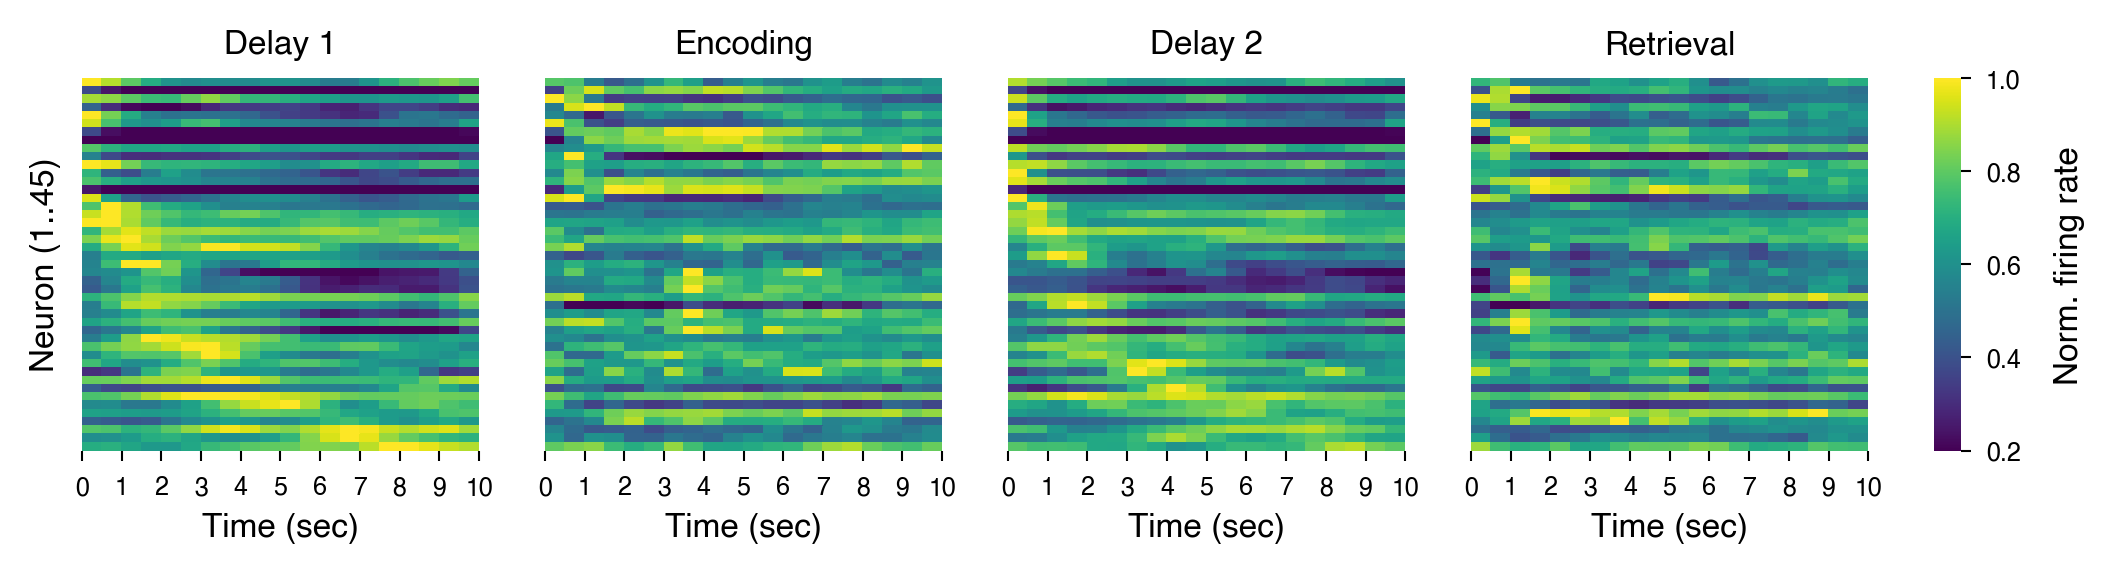

In [442]:
# Time cell stability during the delay interval.
dat = [np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay1'], 20), axis=0)
                  for iCell in delay_time_cell_inds]), 
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Encoding'], 20), axis=0)
                  for iCell in delay_time_cell_inds]),
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Delay2'], 20), axis=0)
                  for iCell in delay_time_cell_inds]),
       np.array([np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], 
                                                                   event_times.query("(subj_sess=='{}')"
                                                                                     .format(spikes.iloc[iCell]['subj_sess'])), 
                                                                   ['Retrieval'], 20), axis=0)
                  for iCell in delay_time_cell_inds])]

# Divide values by their row-wise max.
div_by = np.expand_dims(np.max(np.concatenate((dat[0], dat[1], dat[2], dat[3]), axis=1), axis=-1), axis=-1)
for i in range(len(dat)):
#     dat[i] = dat[i] / np.expand_dims(np.max(dat[i], axis=-1), axis=-1)
    dat[i] = dat[i] / div_by
    
fig = plt.figure(figsize=(6.85039, 6.85039*0.25), dpi=300)
ax1 = plt.subplot2grid((1, 21), (0, 0), colspan=5)
ax2 = plt.subplot2grid((1, 21), (0, 5), colspan=5)
ax3 = plt.subplot2grid((1, 21), (0, 10), colspan=5)
ax4 = plt.subplot2grid((1, 21), (0, 15), colspan=5)
ax5 = plt.subplot2grid((1, 21), (0, 20), colspan=1)
ax = [ax1, ax2, ax3, ax4, ax5]

tickfontsize = 6
labelfontsize = 8

vmin = 0.2
vmax = 1

labs = ['Delay 1', 'Encoding', 'Delay 2', 'Retrieval']
for i in range(len(dat)):
    ax[i] = sns.heatmap(dat[i], vmin=vmin, vmax=vmax, cmap='viridis', square=False, ax=ax[i], 
                        cbar=True, cbar_ax=ax[4])
    ax[i].set_xticks(np.linspace(0, 20, 11))
    ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_xlabel('Time (sec)', fontsize=labelfontsize, labelpad=3)
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Neuron (1..{})'.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=5)
    else:
        ax[i].set_ylabel(' '.format(dat[i].shape[0]), fontsize=labelfontsize, labelpad=5)
    ax[i].set_title(labs[i], y=1.02, fontsize=labelfontsize)
    ax[i].tick_params(length=2.5, width=0.5)
    
cbar = ax[0].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize, length=2.5, width=0.5)
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
ax[-1].collections[0].set_edgecolor("face")

# fig.text(0, 0.98, 'A', fontsize=figfontsize)
# fig.text(0.435, 0.98, 'B', fontsize=figfontsize)
fig.tight_layout(pad=0, w_pad=0)

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_delay1_vs_delay2_vs_enc-ret-first-10sec.png', 
                format='png', dpi=300, bbox_inches='tight')

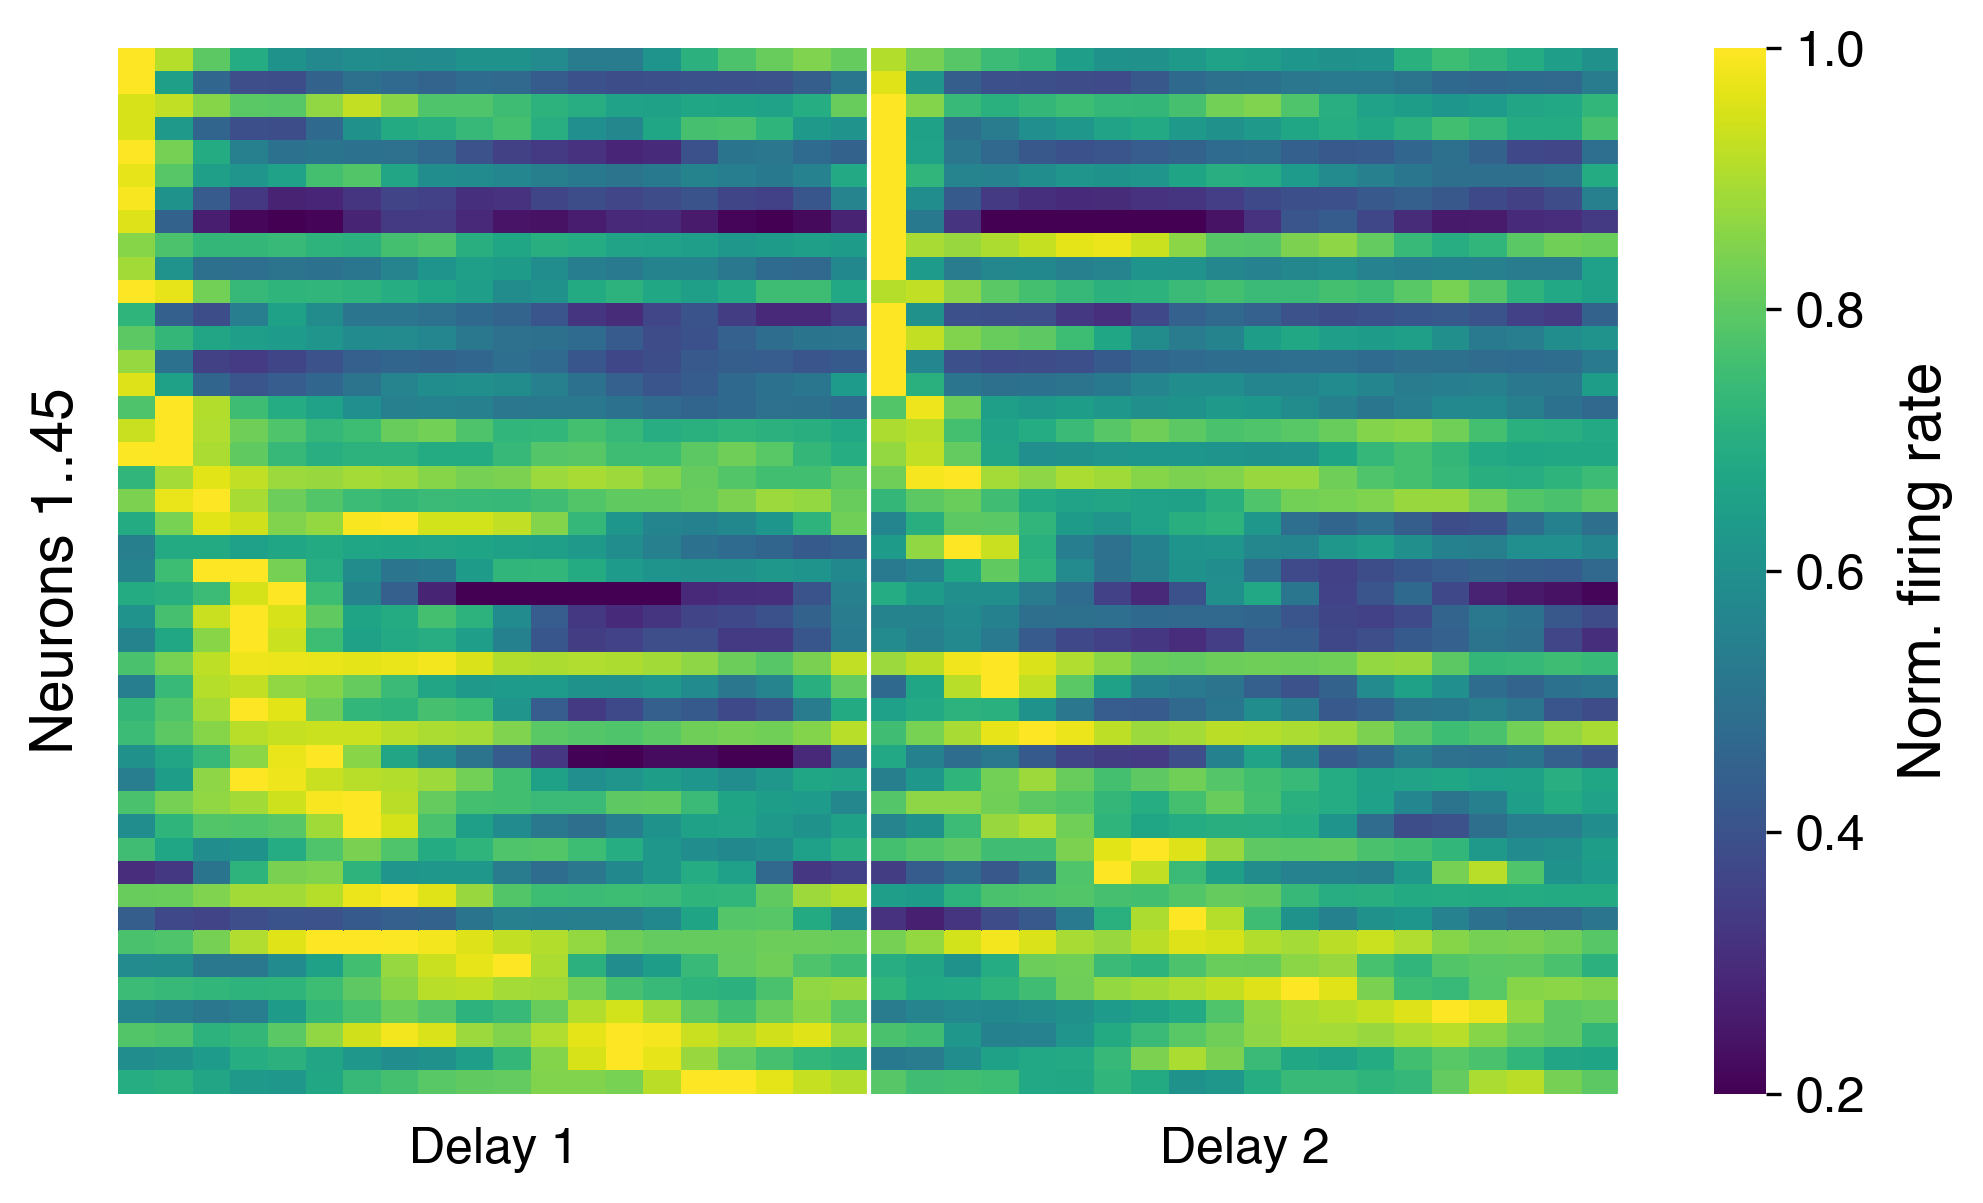

In [407]:
# What do the data look like for firing rates of each neuron
# over the trial (500ms bins; mean over trials)?
if True:
    dat = []
    for iCell in delay_time_cell_inds:
        subj_sess = spikes.iloc[iCell]['subj_sess']
        dat.append(np.concatenate((np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Delay1'], 20), axis=0),
                                   np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Delay2'], 20), axis=0))))
    dat = np.array(dat)

    dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#     dat = dat[np.argsort(dat.argmax(axis=1)), :]

fig, ax = plt.subplots(1, 1, figsize=(6.85039, 6.85039*0.6), dpi=300)
tickfontsize = 12
labelfontsize = 14

vmin = 0.2
vmax = 1
time_bounds = np.array([0, 20, 40])
xticks = aop.rolling_func(time_bounds, np.mean, window=2)
yticks = []

ax = sns.heatmap(dat, ax=ax, square=False,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = time_bounds[1:]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(xticks)
ax.set_xticklabels(['Delay 1', 'Delay 2'], fontsize=tickfontsize, rotation=0)
ax.set_yticks(yticks)
ax.set_ylabel('Neurons 1..{}'.format(dat.shape[0]), fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_trial.png', 
                format='png', dpi=300, bbox_inches='tight')

In [177]:
spikes.agg({'temporal_info19_sig_delay': [len, np.sum, np.mean], 
            'temporal_info_sig_nav': [len, np.sum, np.mean]})

temporal_info_sig_delay  temporal_info_sig_nav
len                122.000000                  122.0
sum                 45.000000                   61.0
mean                 0.368852                    0.5

In [178]:
spikes.groupby('hemroi').agg({'temporal_info_sig_delay': [len, np.sum, np.mean], 
                              'temporal_info_sig_nav': [len, np.sum, np.mean]})

temporal_info_sig_delay                 temporal_info_sig_nav        \
                           len   sum      mean                   len   sum   
hemroi                                                                       
LA                           7   2.0  0.285714                     7   2.0   
LAI                         15   0.0  0.000000                    15   1.0   
LMH                         25   5.0  0.200000                    25   8.0   
LO                          13  13.0  1.000000                    13  13.0   
LTO                         10   0.0  0.000000                    10   6.0   
LTPO                        13   3.0  0.230769                    13  12.0   
REC                         16   9.0  0.562500                    16   9.0   
RIP                          4   1.0  0.250000                     4   0.0   
RTO                         19  12.0  0.631579                    19  10.0   

                  
            mean  
hemroi            
LA      0.285714  
LAI     0.066667  
LMH     0.320000  
LO      1.000000  
LTO     0.600000  
LTPO    0.923077  
REC     0.562500  
RIP     0.000000  
RTO     0.526316

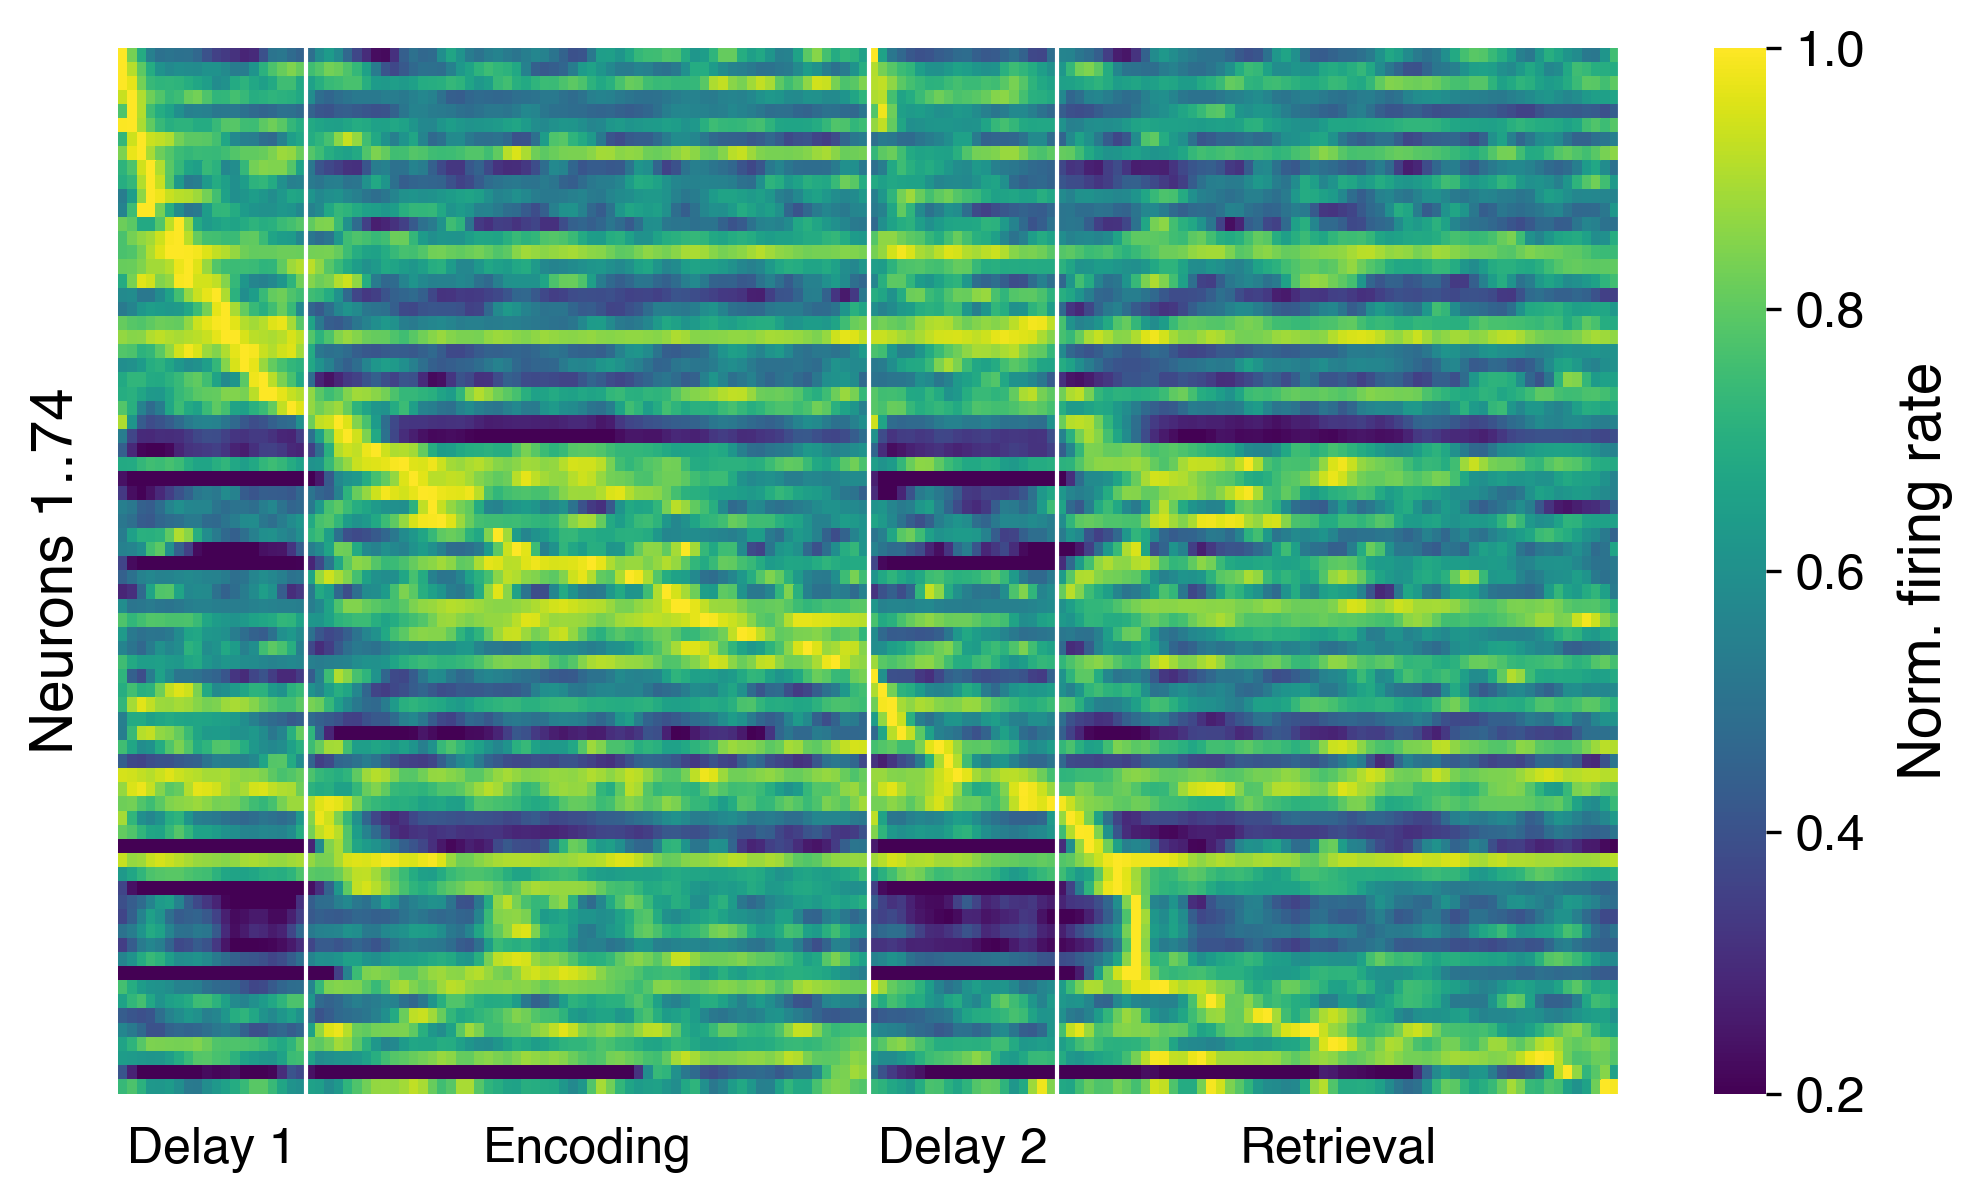

In [403]:
# What do the data look like for firing rates of each neuron
# over the trial (500ms bins; mean over trials)?
if True:
    dat = []
    for iCell in time_cell_inds:
        subj_sess = spikes.iloc[iCell]['subj_sess']
        dat.append(np.concatenate((np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Delay1'], 20), axis=0),
                                   np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Encoding'], 60), axis=0),
                                   np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Delay2'], 20), axis=0),
                                   np.nanmean(time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iCell]['fr_train'], event_times.query("(subj_sess=='{}')".format(subj_sess)), ['Retrieval'], 60), axis=0))))
    dat = np.array(dat)

    dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
    dat = dat[np.argsort(dat.argmax(axis=1)), :]

fig, ax = plt.subplots(1, 1, figsize=(6.85039, 6.85039*0.6), dpi=300)
tickfontsize = 12
labelfontsize = 14

vmin = 0.2
vmax = 1
time_bounds = np.array([0, 20, 80, 100, 160])
xticks = aop.rolling_func(time_bounds, np.mean, window=2)
yticks = []

ax = sns.heatmap(dat, ax=ax, square=False,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = time_bounds[1:]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(xticks)
ax.set_xticklabels(['Delay 1', 'Encoding', 'Delay 2', 'Retrieval'], fontsize=tickfontsize, rotation=0)
ax.set_yticks(yticks)
ax.set_ylabel('Neurons 1..{}'.format(dat.shape[0]), fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/time_cells_trial.png', 
                format='png', dpi=300, bbox_inches='tight')

In [240]:
spikes.iloc[delay_time_cell_inds[40]]['fr_train']

array([0.        , 0.        , 0.        , ..., 6.24101673, 6.24102759,
       6.24103302])

In [256]:
delay_time_cell_inds

array([ 74, 112, 111,  49, 110, 109, 108, 107,  82,  48,  22,  47,  32,
        45,  46,  51,   1,  57,   8,  72,   3,  68,  75,  62,  61,  56,
         6,  14,  58, 113,  64,  13,  10,  69,  20,  77,  11,   4,  12,
        50,  86, 115,  52,  28,  84])

In [258]:
spikes.iloc[iUnit]

subj_sess                                                           U518_ses0
chan                                                                       38
unit                                                                        1
n_spikes                                                                13892
fr                                                                    2.85459
hemroi                                                                    LMH
fr_train                    [1.7946730820439123, 1.7946815461562147, 1.794...
fr_vec_delay                [2.7170176540224773, 2.7632510217133106, 2.989...
fr_vec_z_delay              [-3.106646185857663, -2.9726743707125234, -2.0...
temporal_info_delay                                                0.00944759
temporal_info_z_delay                                                 2.46267
temporal_info_pval_delay                                             0.022977
fr_vec_nav                  [3.334799805532261, 3.09099778835939

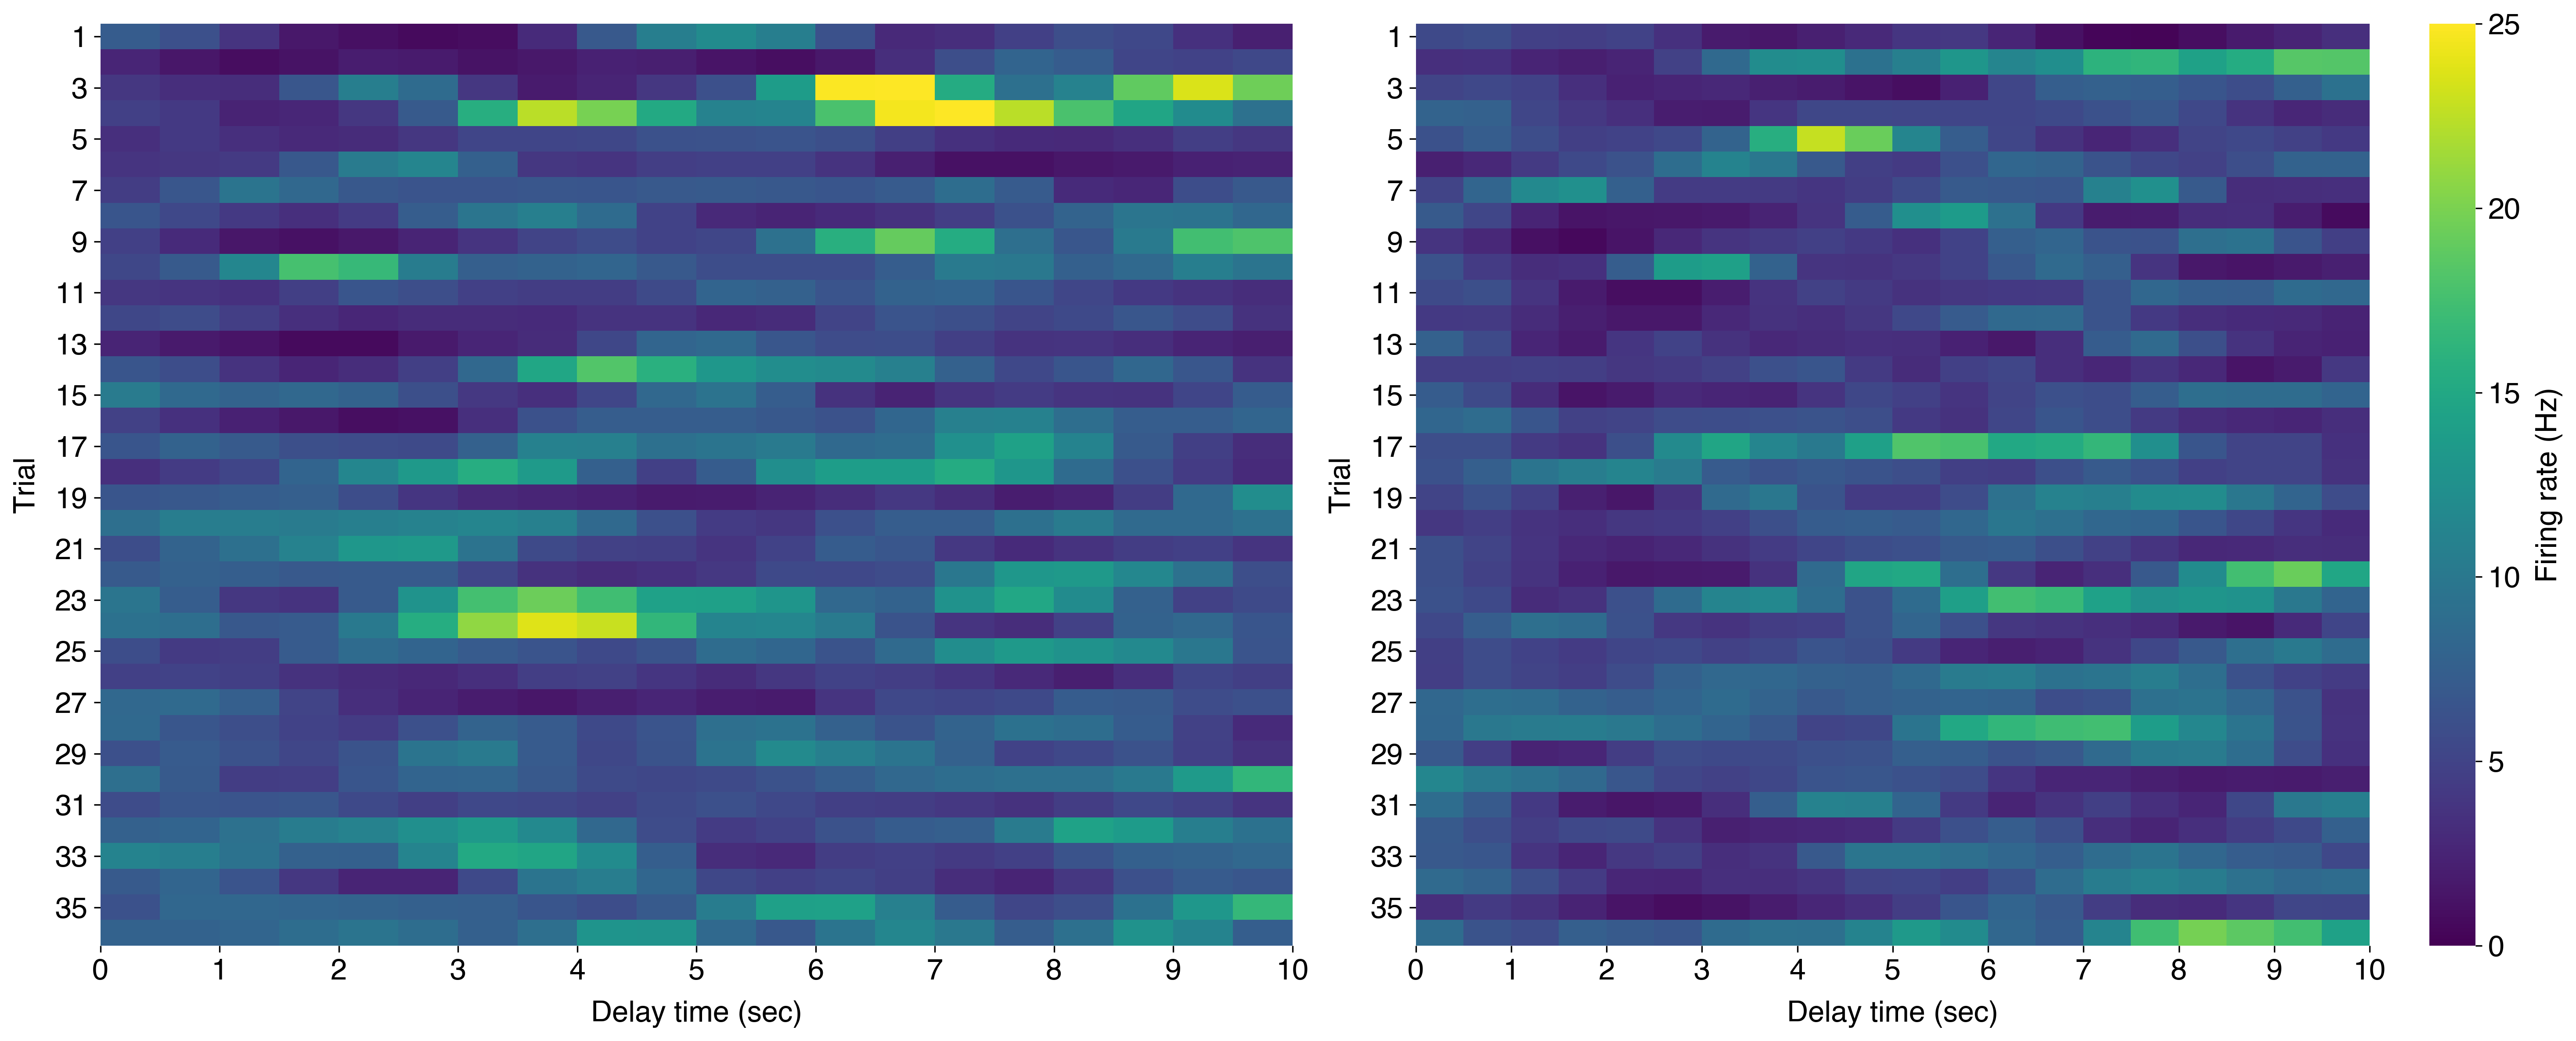

In [262]:
# Single neuron, trial x time.
iUnit = 52

dat = [time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iUnit]['fr_train'], 
                                             event_times.query("(subj_sess=='{}')".format([spikes.iloc[iUnit]['subj_sess']]),
                                             ['Delay1'], 20),
       time_bin_analysis.calc_fr_by_time_bin(spikes.iloc[iUnit]['fr_train'], 
                                             event_times.query("(subj_sess=='{}')".format([spikes.iloc[iUnit]['subj_sess']]),
                                             ['Delay2'], 20)]
#dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=300)
ax = np.ravel(ax)

labelfontsize = 16
tickfontsize = 16

vmin = 0
vmax = int(np.max((np.max(dat[0]), np.max(dat[1]))))

for i in range(2):
    if i == 0:
        ax[i] = sns.heatmap(dat[i], ax=ax[i], vmin=vmin, vmax=vmax, cmap='viridis', cbar=False)
    else:
        ax[i] = sns.heatmap(dat[i], ax=ax[i], vmin=vmin, vmax=vmax, cmap='viridis', cbar=True)
        
    ax[i].set_xticks(np.linspace(0, 20, 11))
    ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
    ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)

    ax[i].set_yticks(np.arange(dat[i].shape[0], step=2) + 0.5)
    ax[i].set_yticklabels(np.arange(dat[i].shape[0], step=2)+1, fontsize=tickfontsize, rotation=0)
    ax[i].set_ylabel('Trial', fontsize=labelfontsize, labelpad=8)

# ax.annotate('Delay 1', (10, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
# ax.annotate('Delay 2', (90, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)

if i == 1:
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize)
    cbar.set_ticks(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
    cbar.set_ticklabels(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
    cbar.set_label('Firing rate (Hz)', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

## Delay interval

In [6]:
start_time = time()
warnings.filterwarnings('ignore')

game_states = ['Delay1', 'Delay2']
n_time_bins = 20
n_perms = 1000

# -----------------------
output = time_bin_analysis.fr_by_time_vs_null(fr_train, 
                                              event_times, 
                                              game_states, 
                                              n_time_bins=n_time_bins, 
                                              n_perms=n_perms)

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time))

Done in 16.62 secs


In [254]:
start_time = time()

time_bins = np.array(np.round(event_times.query("(gameState=={})".format(['Delay1', 'Delay2']))['time_bins'].tolist(), 0), dtype=int)
delay_frs = np.array([np.mean(calc_fr_by_time_bin(spikes.iloc[sig_cells_delay[iCell]]['fr_train'], time_bins), axis=0)
                              for iCell in range(len(sig_cells_delay))])

print('Done in {:.2f} secs'.format(time() - start_time))

Done in 0.27 secs


min=0.37


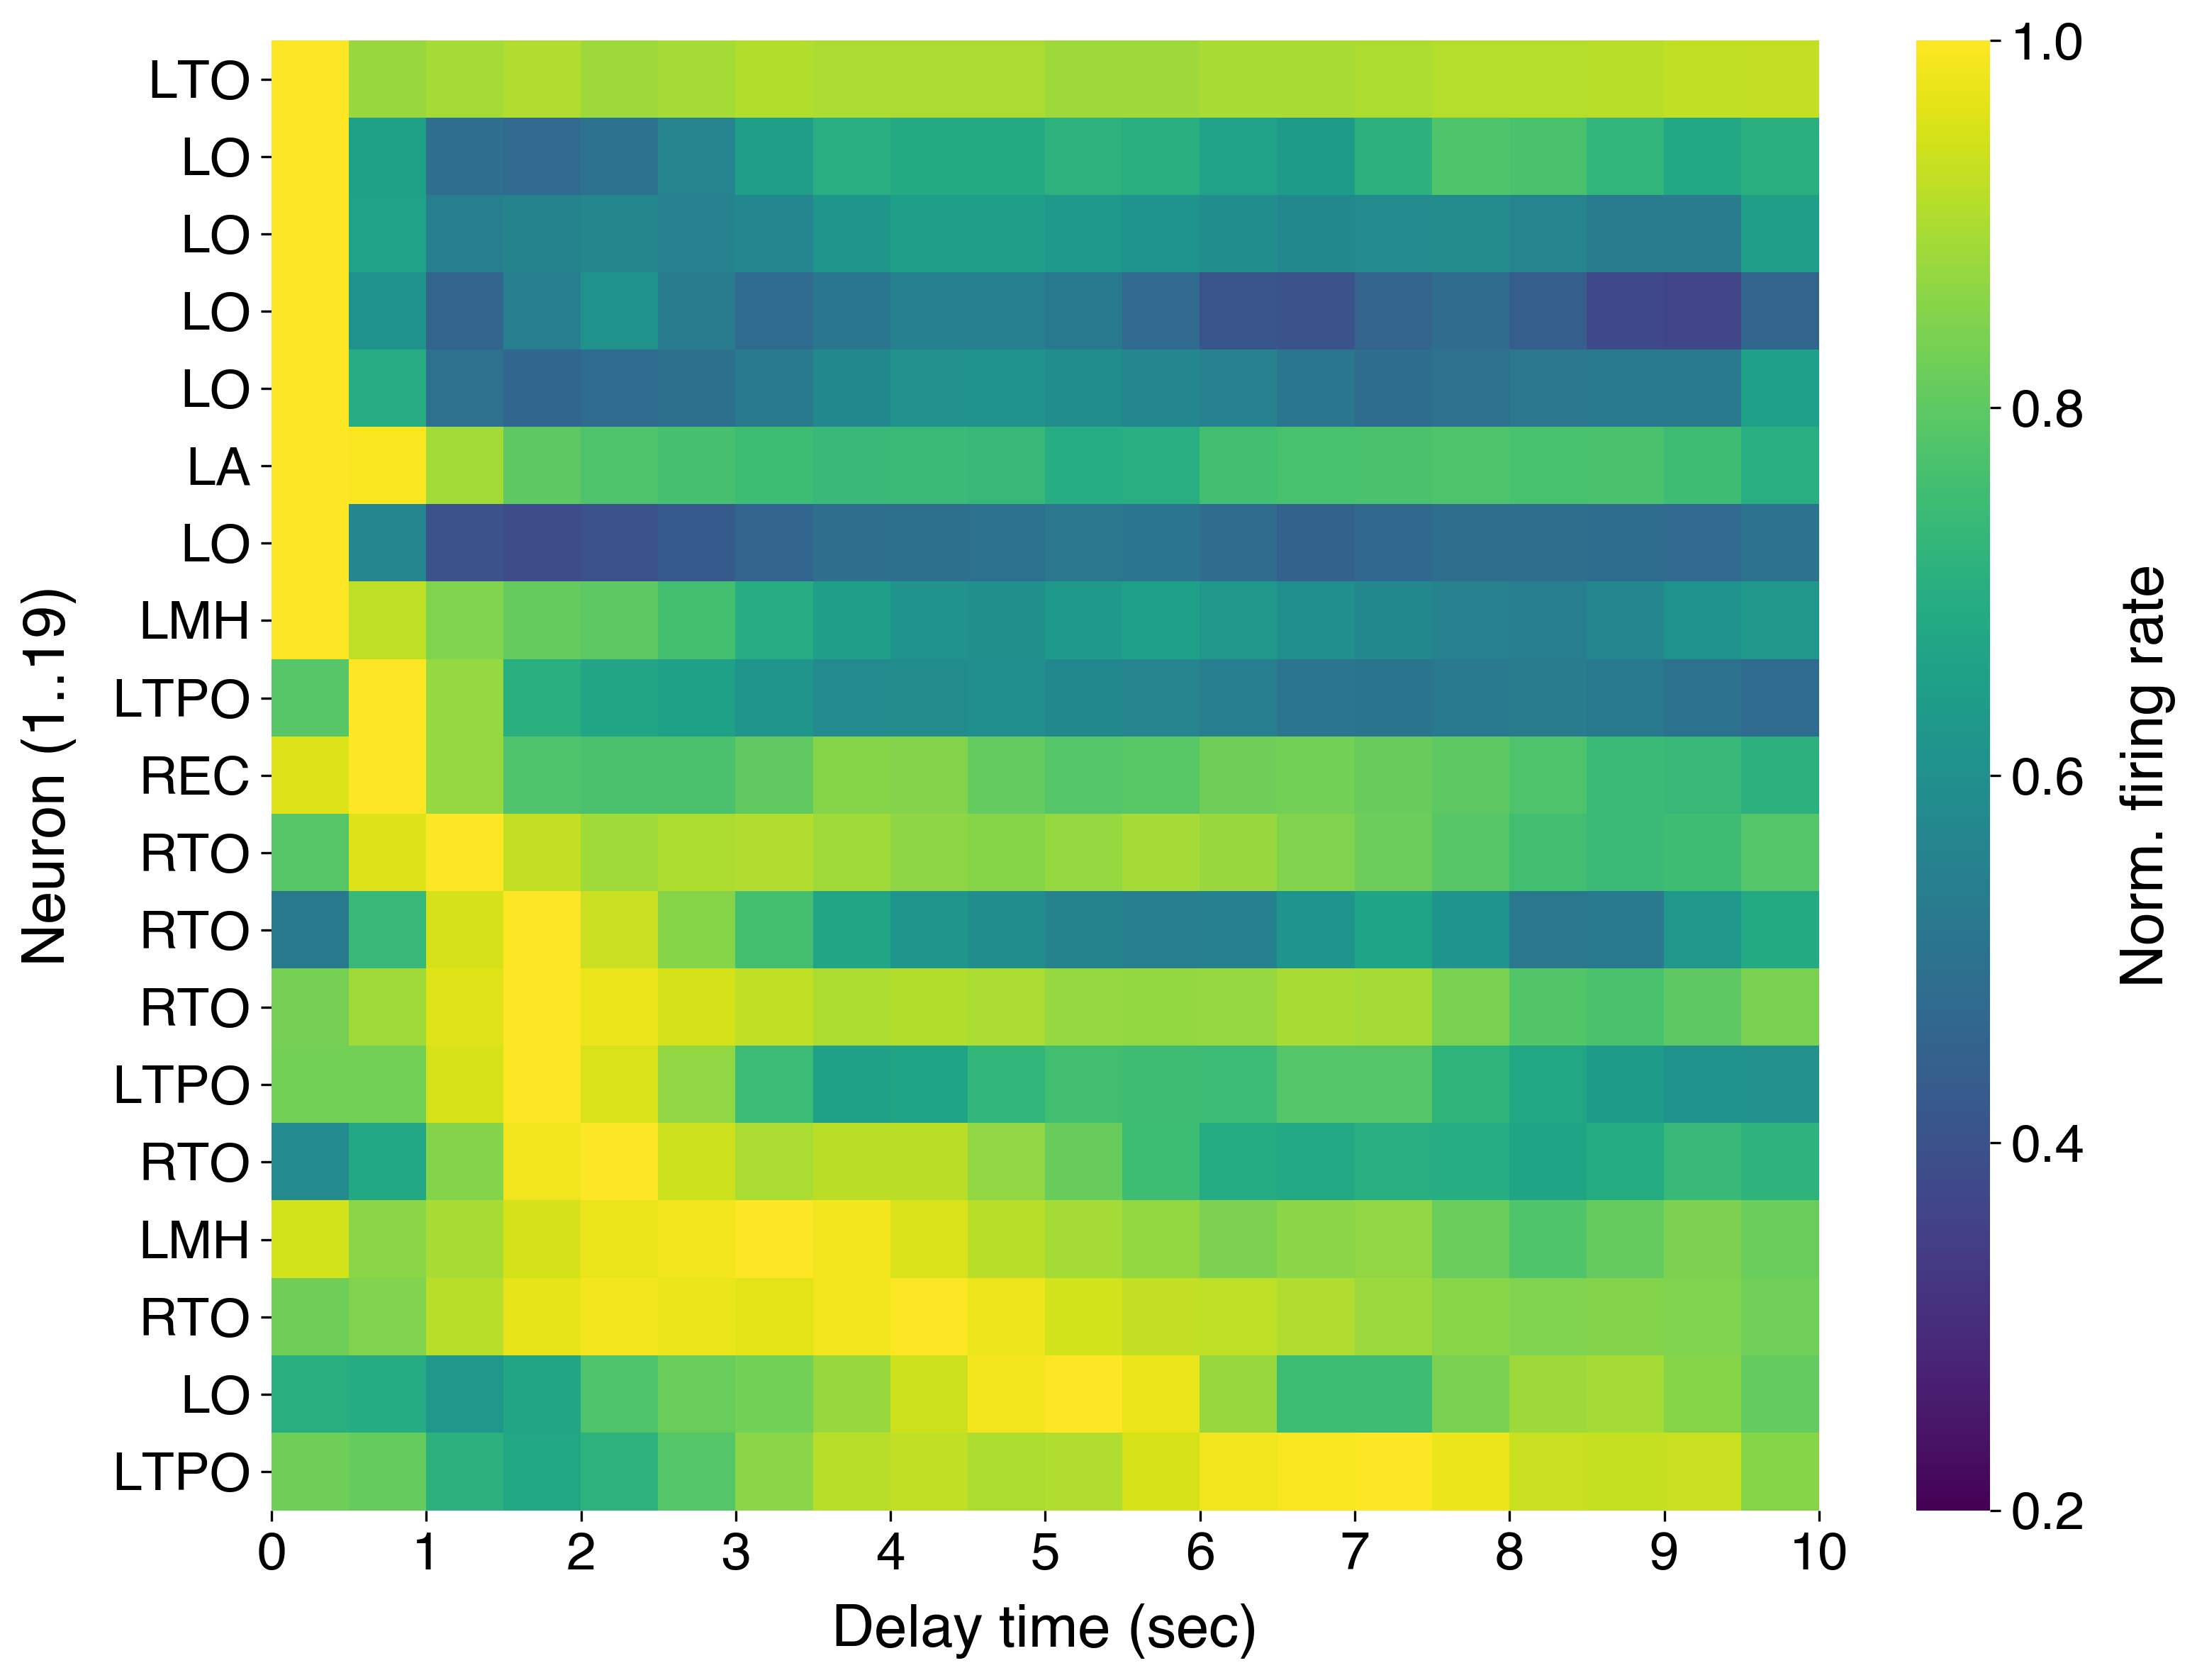

In [260]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = delay_frs
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10.5, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 18
labelfontsize = 20

vmin = 0.2
vmax = 1

i = 0
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=12)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=12)

fig.tight_layout()

In [165]:
print(info_rate([0, 1]), info_rate([0, 0, 0, 1]), info_rate([0, 0, 0, 0, 0, 0, 0, 1]), info_rate([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))
print(info_rate([0, 0, 0, 0, 0, 0, 0, 0.1]), info_rate([0, 0, 0, 0, 0, 0, 0, 1]), info_rate([0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1/10]))
print(info_rate([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1]), info_rate([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 10]))
print(info_rate([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1], np.array([5, 5, 5, 5, 5, 5, 5, 1])/36),
      info_rate([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1], np.array([1, 1, 1, 1, 1, 1, 1, 29])/36))

1.0 2.0 3.0 4.0
3.0 3.0 3.321928094887362
0.8666125086834027 2.4677444059116804
0.41627814842094046 0.1992393739659072


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: divide by zero encountered in log2
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in multiply


In [1041]:
# Calculate the temporal information for each neuron
# during delay intervals.
start_time = time()
warnings.filterwarnings('ignore')

# Sum the spikes in each time bin, over delay intervals, 
# for each neuron.
delay_spikes_by_time = count_spikes_by_time_bin(event_times, 
                                                spikes['spike_times'], 
                                                ['Delay1', 'Delay2']) # neuron x time_bin

# How much time information does each neuron provide?
time_info_delay = np.array([info_rate(delay_spikes_by_time[iUnit, :]) 
                            for iUnit in range(delay_spikes_by_time.shape[0])])

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time)) 

Done in 3.61 secs


In [1020]:
# NULL DISTRIBUTION
# Calculate the temporal information for each neuron
# during delay intervals.
start_time = time()
warnings.filterwarnings('ignore')

n_perm = spikes['spike_times_null'].tolist()[0].shape[0]

spike_times_shifted = [pd.Series([x[iPerm, :] for x in spikes['spike_times_null'].tolist()])
                       for iPerm in range(n_perm)]

delay_spikes_by_time_null = np.array([count_spikes_by_time_bin(event_times, 
                                                               spike_times_shifted[iPerm], 
                                                               ['Delay1', 'Delay2'])
                                      for iPerm in range(n_perm)]) # perm x neuron x time_bin

# How much time information does each neuron provide?
time_info_delay_null = np.array([[info_rate(delay_spikes_by_time_null[iPerm, iUnit, :]) 
                                  for iUnit in range(delay_spikes_by_time.shape[0])]
                                 for iPerm in range(n_perm)]) # perm x neuron

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time)) 

Done in 24.64 secs


In [1071]:
# How many time cells do we identify?
fname = os.path.join(proj_dir, 'analysis', 'spikes_by_time_bin', 'U518_ses0_delay_spikes_by_time_bin.pkl')
dat = dio.open_pickle(fname)

n_neurons = len(dat['time_info_delay'])
delay_pvals = [  (np.sum(dat['time_info_delay_null'][:, iUnit]>dat['time_info_delay'][iUnit]) + 1) 
               / (dat['time_info_delay_null'].shape[0] + 1)
               for iUnit in range(n_neurons)]

# FDR correct the p-values.
delay_fdr_sig = sm.stats.multipletests(delay_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
n_sig_delay = np.sum(delay_fdr_sig)
sig_cells_delay = np.where(delay_fdr_sig)[0]

print('Found {}/{} ({:.1f} %) significant time cells during the delay interval'
      .format(n_sig_delay, n_neurons, 100*n_sig_delay/n_neurons))

Found 23/56 (41.1 %) significant time cells during the delay interval


min=0.11


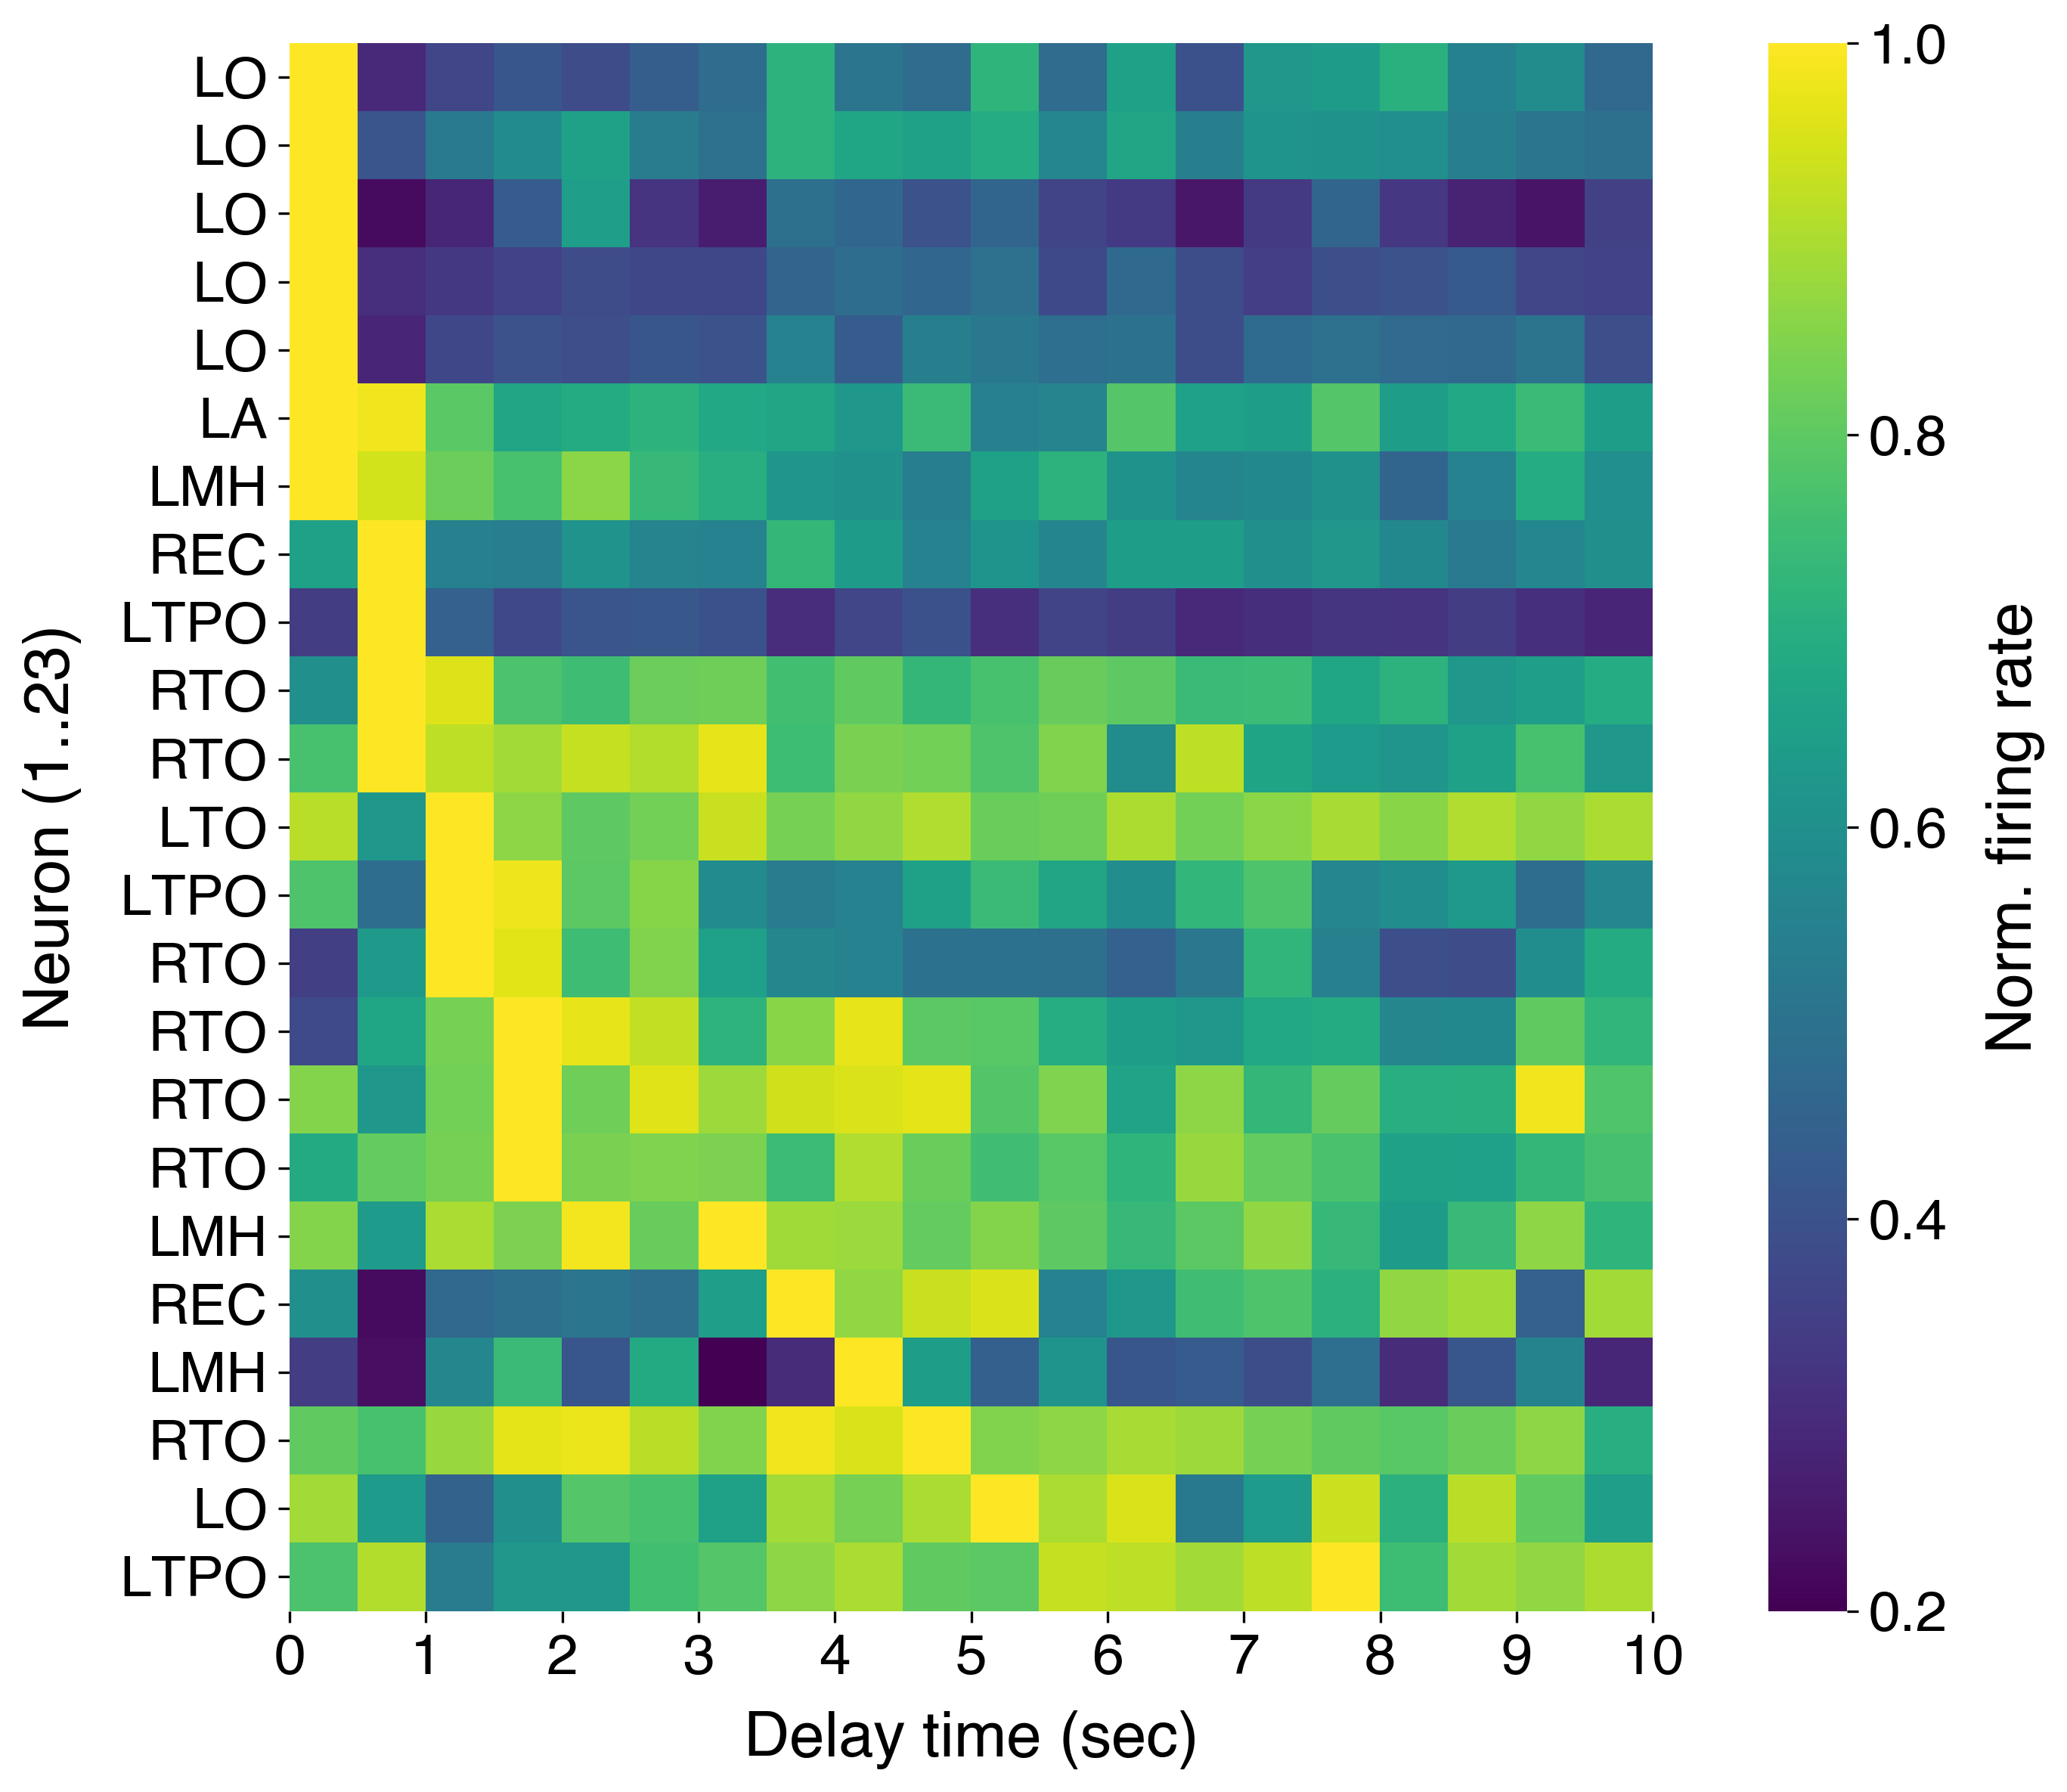

In [1072]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = delay_spikes_by_time[sig_cells_delay, :]
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10.5, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 18
labelfontsize = 20

vmin = 0.2
vmax = 1

i = 0
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=12)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=12)

fig.tight_layout()

## Navigation interval

In [1040]:
# Calculate the temporal information for each neuron
# during navigation intervals.
start_time = time()
warnings.filterwarnings('ignore')

# Sum the spikes in each time bin, over nav intervals, 
# for each neuron.
nav_spikes_by_time = count_spikes_by_time_bin(event_times, 
                                              spikes['spike_times'], 
                                              ['Encoding', 'Retrieval']) # neuron x time_bin

# How much time information does each neuron provide?
time_info_nav = np.array([info_rate(nav_spikes_by_time[iUnit, :]) 
                          for iUnit in range(nav_spikes_by_time.shape[0])])

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time)) 

Done in 10.73 secs


In [ ]:
# NULL DISTRIBUTION
# Calculate the temporal information for each neuron
# during navigation intervals.
start_time = time()
warnings.filterwarnings('ignore')

n_perm = spikes['spike_times_null'].tolist()[0].shape[0]

spike_times_shifted = [pd.Series([x[iPerm, :] for x in spikes['spike_times_null'].tolist()])
                       for iPerm in range(n_perm)]

nav_spikes_by_time_null = np.array([count_spikes_by_time_bin(event_times, 
                                                             spike_times_shifted[iPerm], 
                                                             ['Encoding', 'Retrieval'])
                                    for iPerm in range(n_perm)]) # perm x neuron x time_bin

# How much time information does each neuron provide?
time_info_nav_null = np.array([[info_rate(nav_spikes_by_time_null[iPerm, iUnit, :]) 
                                 for iUnit in range(nav_spikes_by_time.shape[0])]
                                for iPerm in range(n_perm)]) # perm x neuron

warnings.filterwarnings('default')
print('Done in {:.2f} secs'.format(time() - start_time)) 

In [1084]:
# How many time cells do we identify?
fname = os.path.join(proj_dir, 'analysis', 'spikes_by_time_bin', 'U518_ses0_nav_spikes_by_time_bin.pkl')
dat = dio.open_pickle(fname)

n_neurons = len(dat['time_info_nav'])
nav_pvals = [  (np.sum(dat['time_info_nav_null'][:, iUnit]>dat['time_info_nav'][iUnit]) + 1) 
               / (dat['time_info_nav_null'].shape[0] + 1)
               for iUnit in range(n_neurons)]

# FDR correct the p-values.
nav_fdr_sig = sm.stats.multipletests(nav_pvals, alpha=0.05, method='fdr_tsbky', is_sorted=False, returnsorted=False)[0]
n_sig_nav = np.sum(nav_fdr_sig)
sig_cells_nav = np.where(nav_fdr_sig)[0]

print('Found {}/{} ({:.1f} %) significant time cells during the navigation interval'
      .format(n_sig_nav, n_neurons, 100*n_sig_nav/n_neurons))

Found 25/56 (44.6 %) significant time cells during the navigation interval


min=0.14


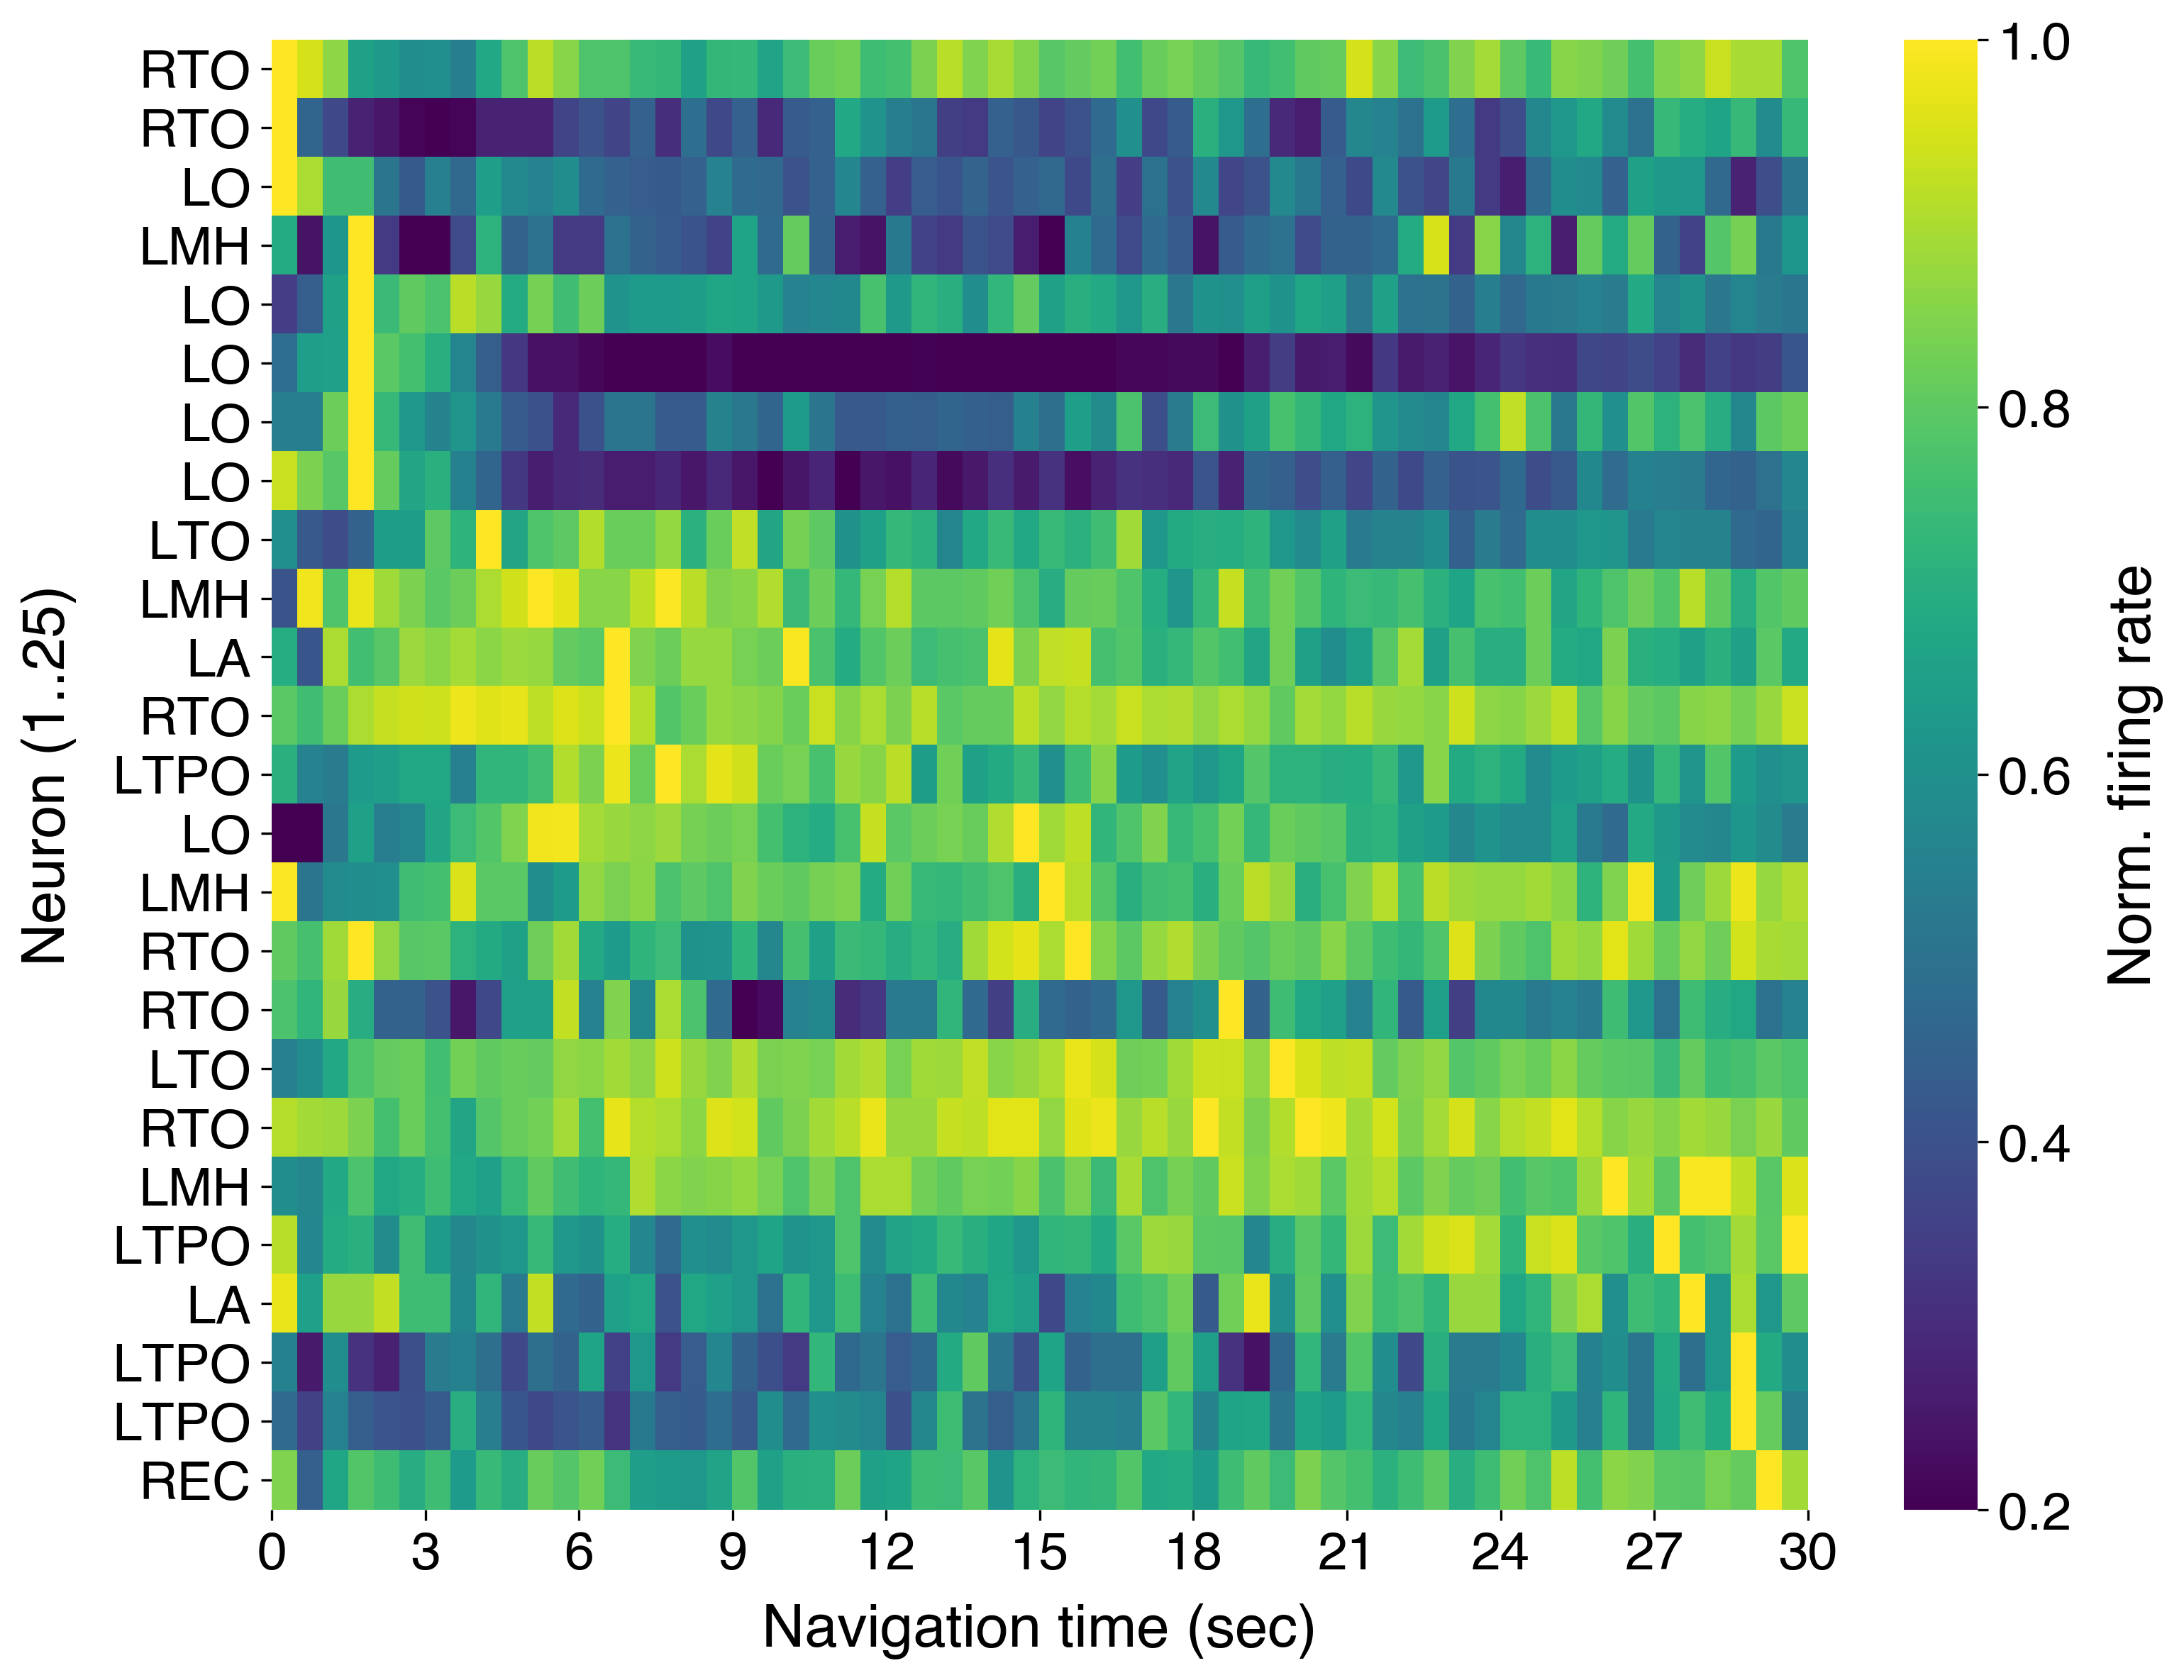

In [1079]:
# For each neuron, add the number of spikes in each time bin, across all navigation periods.
xtrial_nav_spikes = nav_spikes_by_time[sig_cells_nav, :]
show_units_nav = sig_cells_nav[np.argsort(xtrial_nav_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_nav_spikes[np.argsort(xtrial_nav_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10.5, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 18
labelfontsize = 20

vmin = 0.2
vmax = 1

i = 0
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=False, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 60, 11))
ax[i].set_xticklabels(np.linspace(0, 30, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_nav]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Navigation time (sec)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_nav_spikes.shape[0]), fontsize=labelfontsize, labelpad=12)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=12)

fig.tight_layout()

In [203]:
def dist_btwn(pos):
    """Get the distance between adjacent positions.
    
    Returns the distance traveled between
    adjacent positions in 2-dimensional space
    (i.e. the speed in meters/sample).
    
    len(output) = len(pos) - 1
    
    Parameters
    ----------
    pos : numpy.ndarray
        Shape is (n_samples, 2) where the second
        dimension contains (x, y) coordinates
        for a single position.
    """
    return np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))

def dist_btwn_2step(pos):
    """Get the mean distance between last position and next.
    
    Returns the distance traveled between
    adjacent positions in 2-dimensional space
    (i.e. the speed in meters/sample).
    
    len(output) = len(pos)
    
    Parameters
    ----------
    pos : numpy.ndarray
        Shape is (n_samples, 2) where the second
        dimension contains (x, y) coordinates
        for a single position.
    """
    arr1 = dist_btwn(pos[0::2])
    arr2 = dist_btwn(pos[1::2])
    output = np.empty(arr1.size + arr2.size, dtype=arr1.dtype)
    output[0::2] = arr1
    output[1::2] = arr2
    return np.concatenate(((dist_btwn(pos[:2, :])), output/2, (dist_btwn(pos[-2:, :]))))

In [205]:
# How long did the subject spend at each location in the mine?
# Records time bins that start when the subject enters a new 1x1m
# location and ends when they leave it or have been motionless for >500ms.
proj_dir = '/home1/dscho/projects/time_cells'
game_states = ['Encoding', 'Retrieval', 'ReturnToBase1', 'ReturnToBase1']
maze_f = os.path.join(proj_dir, 'unity', 'maps', 'simple_maze.pkl')
maze_shp = [27, 29]
mask_regions = ['wall']
xoffset = 3 # m
min_traversals = 10
remove_still_time = False
min_still_time = 500 # ms

# -------------------------------------
# Load the mine layout DataFrame.
maze = dio.open_pickle(maze_f)
maze['coords'] = maze['coords'].apply(lambda x: [(x[0][0]-xoffset, x[0][1]), (x[1][0]-xoffset, x[1][1])])

# Mask out unwanted regions.
mask = np.zeros(maze_shp)
for region in mask_regions:
    for idx, row in maze.query("(region=='{}')".format(region)).iterrows():
        (xmin, zmin), (xmax, zmax) = row.coords
        for x in range(xmin, xmax):
            for z in range(zmin, zmax):
                mask[x, z] = 1
                
# Determine the times during which the subject
# was at each 1x1 m location in the mine.
xinds, zinds = np.where(mask!=1)
traversal_time_bins = od([((xinds[i], zinds[i]), []) 
                          for i in range(len(xinds))])
traversal_counts = od([((xinds[i], zinds[i]), 0) 
                       for i in range(len(xinds))])
traversal_durs = od([((xinds[i], zinds[i]), 0) 
                     for i in range(len(xinds))])
dist_trav = []
traversals = []
for idx, df in (events.query("(key=='playerTransform') & (gameState=={})".format(game_states))
                .groupby(['trial', 'gameState'])):
    trial, gameState = idx    
    locs = np.array(df['value'].apply(lambda x: (x['positionX']-xoffset, x['positionZ'])).tolist())
    locs_1x1 = np.array(locs, dtype=int)
    loc_times = df['time'].to_numpy()
    trial_phase_start, trial_phase_stop = np.min(loc_times), np.max(loc_times)
    speed_norm = len(locs) / ((trial_phase_stop - trial_phase_start) * 1e-3)
    speed = dist_btwn_2step(locs) * speed_norm # in m/sec
    still_times = loc_times[np.where(speed==0)[0]]
    
    # loc_entry_inds: indices that capture the first report that the
    #                 subject stepped into each 1x1 m location
    #                 (discarding the first location) during
    #                 a single trial phase
    # locs_trav: the locations associated with loc_entry_inds
    # loc_entry_times: the times associated with loc_entry_inds
    # loc_exit_times: the times, after entering each 1x1 m location,
    #                 that the subject either stopped moving, entered
    #                 a new location, or reached the end of the 
    #                 trial phase (whichever happened first)
    # loc_durs: duration (in ms) that the subject spent moving at
    #           each location
    loc_entry_inds = np.where(dist_btwn(locs_1x1)>0)[0]+1 
    locs_trav = locs_1x1[loc_entry_inds]
    loc_entry_times = loc_times[loc_entry_inds]
    loc_exit_times = []
    for iTime in range(len(loc_entry_times)):
        if remove_still_time:
            still_times_ = still_times[still_times>(loc_entry_times[iTime]+min_still_time)]
        else:
            still_times_ = np.zeros(0)
        if iTime == len(loc_entry_times) - 1:
            if len(still_times_) > 0:
                loc_exit_times.append(still_times_[0])
            else:
                loc_exit_times.append(trial_phase_stop)
        else:
            if len(still_times_) > 0:
                loc_exit_times.append(np.min((loc_entry_times[iTime+1], still_times_[0])))
            else:
                loc_exit_times.append(loc_entry_times[iTime+1])
    loc_exit_times = np.array(loc_exit_times)
    loc_time_bins = np.array(list(zip(loc_entry_times, loc_exit_times)))
    loc_durs = loc_time_bins[:, 1] - loc_time_bins[:, 0]
    
    # Add info on each location traversed during the
    # trial phase, except for the first and last location.
    for iLoc in range(locs_trav.shape[0] - 1):
        loc = tuple(locs_trav[iLoc, :])
        traversal_time_bins[loc].append(loc_time_bins[iLoc, :])
        traversal_durs[loc] += loc_durs[iLoc]
        traversal_counts[loc] += 1
        
# Get time bins for analysis.
keep_squares = [tuple(k) for k, v in traversal_counts.items() if v>=min_traversals]

squares_trav = np.array(list(traversal_counts.values()))>0
n_squares_trav = np.sum(squares_trav)
print('{}/{} ({:.1f}%) squares traversed (median: {} traversals, {:.1f} sec)'
      .format(n_squares_trav, len(traversal_counts), 
              100 * n_squares_trav / len(traversal_counts),
              np.median(np.array(list(traversal_counts.values()))[squares_trav]),
              np.median(np.array(list(traversal_durs.values()))[squares_trav]) * 1e-3))

squares_trav2 = np.array(list(traversal_counts.values()))>=min_traversals
n_squares_trav2 = np.sum(squares_trav2)
print('{}/{} ({:.1f}%) squares traversed>={} times (median: {} traversals, {:.1f} sec)'
       .format(n_squares_trav2, len(traversal_counts), 
              100 * n_squares_trav2 / len(traversal_counts), min_traversals,
              np.median(np.array(list(traversal_counts.values()))[squares_trav2]),
              np.median(np.array(list(traversal_durs.values()))[squares_trav2]) * 1e-3))

NameError: name 'events' is not defined

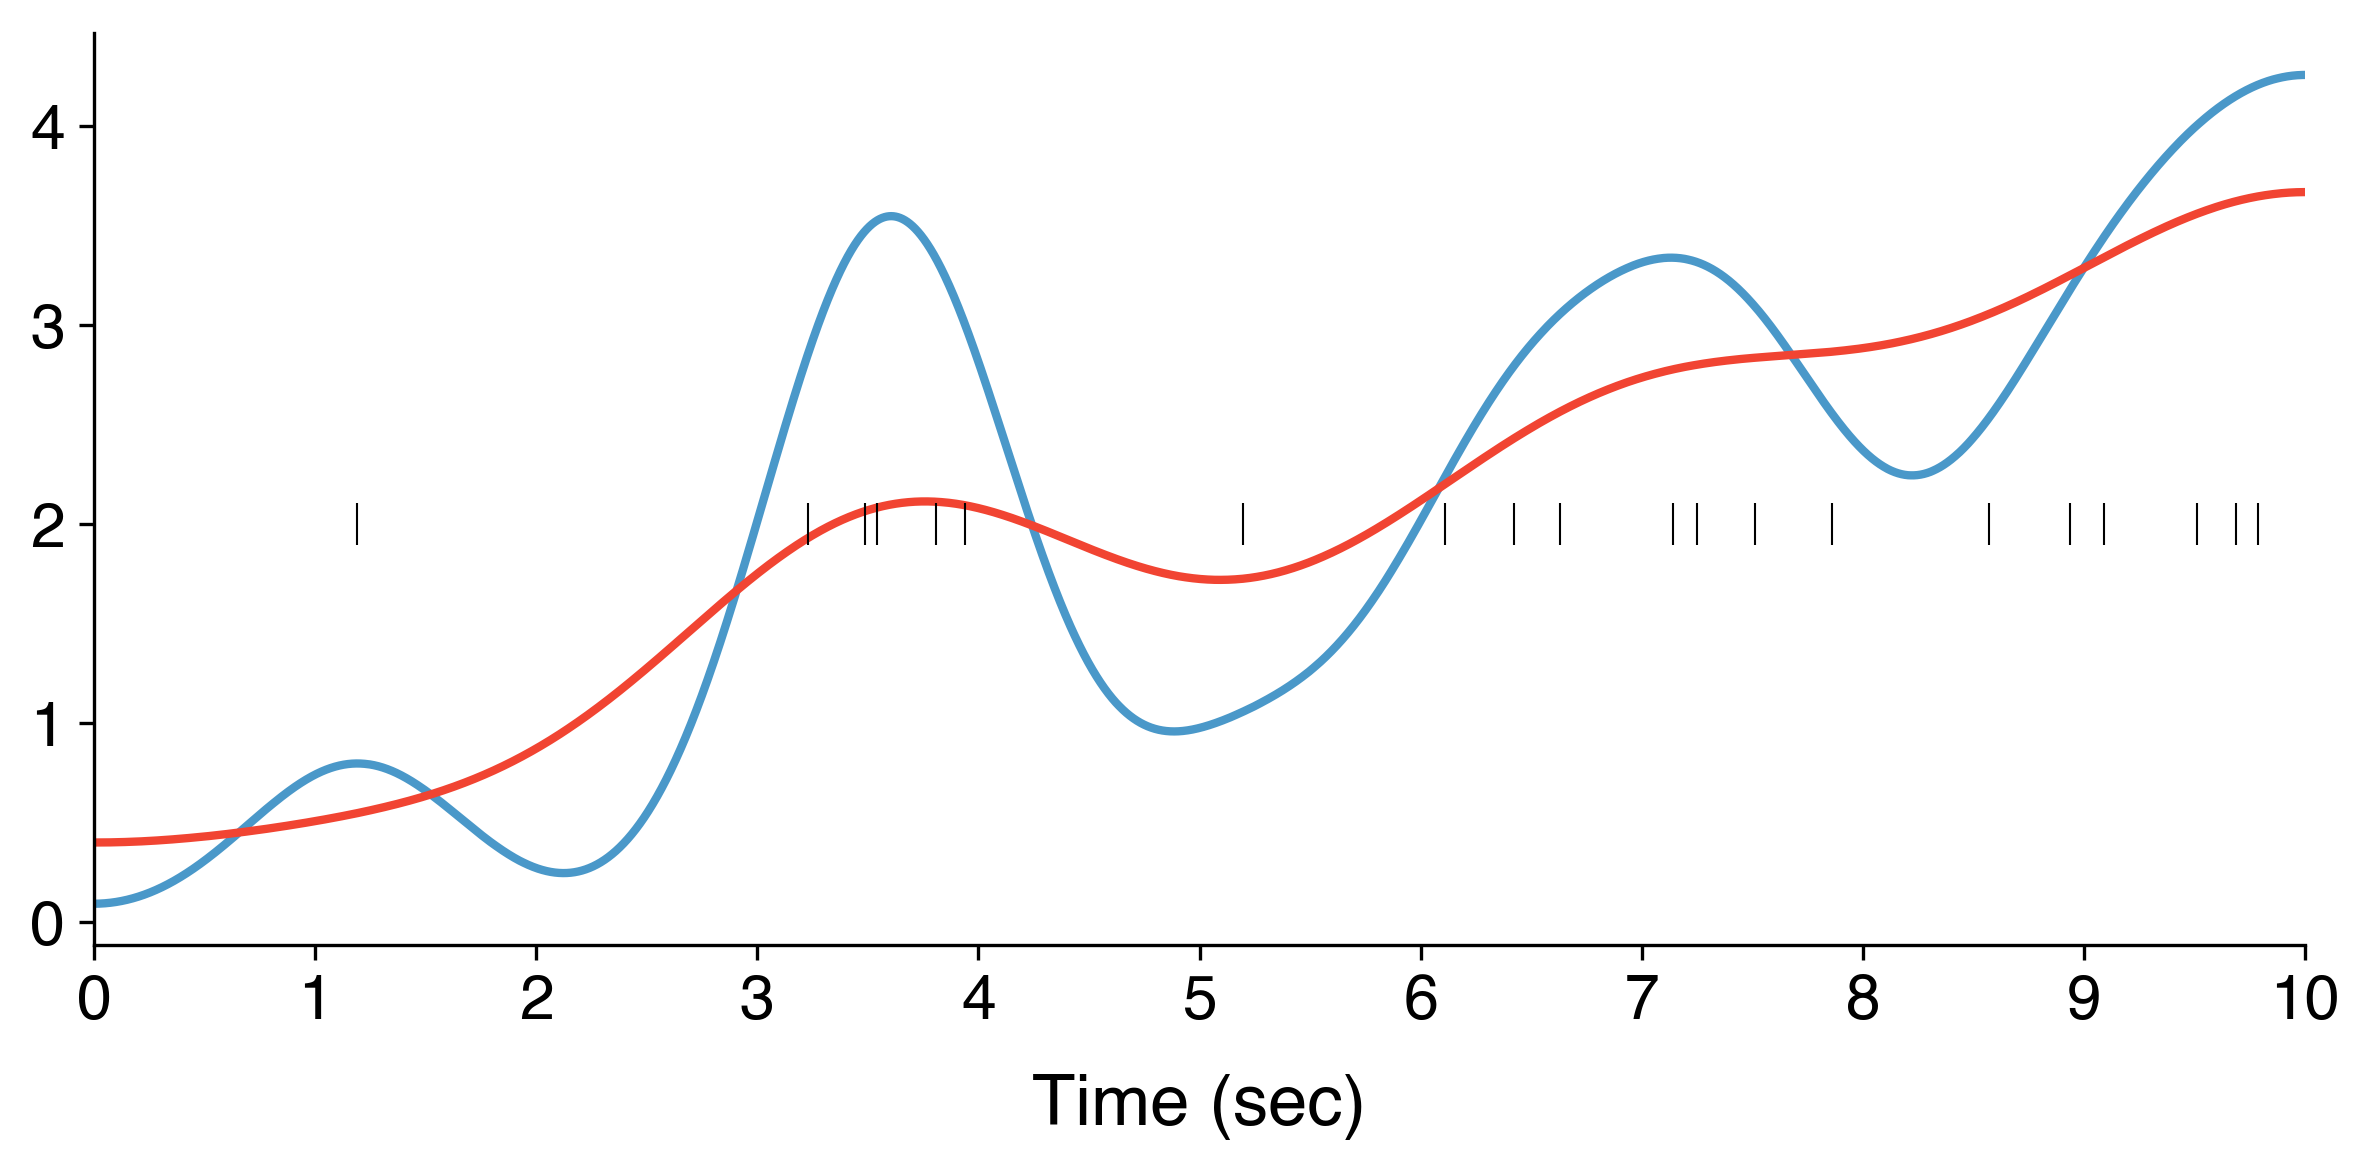

In [2023]:
n_secs = 10
dsr = 1000
n_spikes = 2 * n_secs

# -----------------------
n_samples = n_secs * dsr
sim_spike_train = np.zeros(n_samples)
sim_spike_times = np.random.choice(n_samples, n_spikes, replace=False)
sim_spike_train[sim_spike_times] = 1
sim_fr = gaussian_filter(sim_spike_train, 500)
sim_fr = (sim_fr / np.sum(sim_fr)) * n_spikes * dsr # sums to n_spikes/sec

sim_fr2 = gaussian_filter(sim_spike_train, 1000)
sim_fr2 = (sim_fr2 / np.sum(sim_fr2)) * n_spikes * dsr # sums to n_spikes/sec

# Just for visualization purposes.
sim_spike_train[sim_spike_train==1] = np.mean(sim_fr)
sim_spike_train[sim_spike_train==0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(sim_fr, color=colors[0], linewidth=2)
ax[i].plot(sim_fr2, color=colors[1], linewidth=2)
ax[i].plot(sim_spike_train, marker='|', markersize=10, markeredgewidth=0.5, color='k')
ax[i].set_xlim([0, n_samples])
ax[i].set_xticks(np.linspace(0, n_samples, 11))
ax[i].set_xticklabels(np.linspace(0, n_samples/dsr, 11, dtype=int))
ax[i].set_xlabel('Time (sec)')

fig.tight_layout()

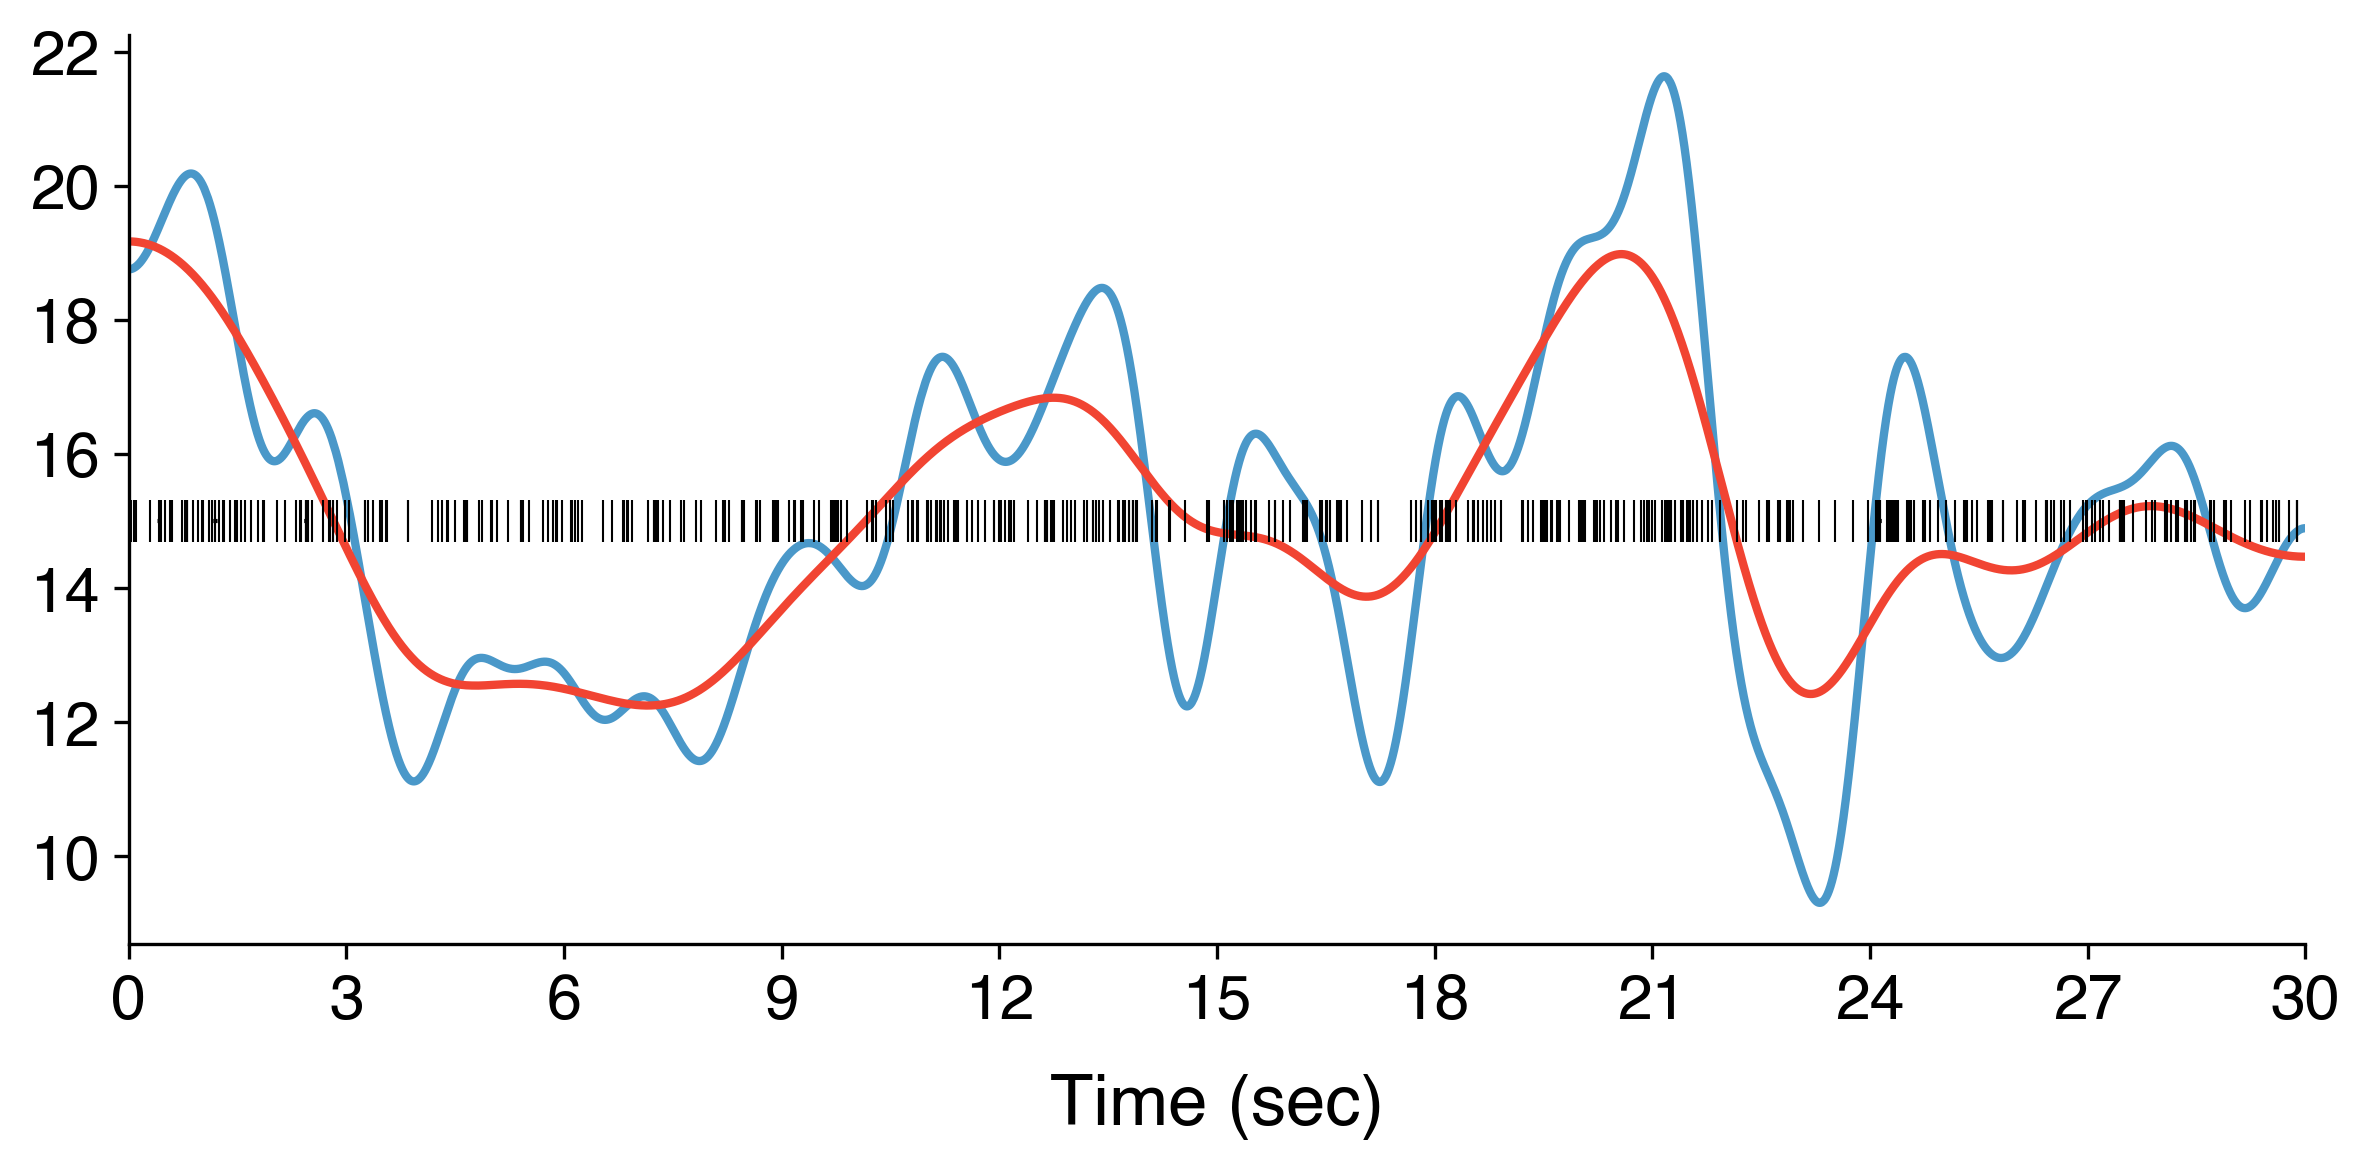

In [2077]:
n_secs = 30
dsr = 1000
n_spikes = 15 * n_secs

# -----------------------
n_samples = n_secs * dsr
sim_spike_train = np.zeros(n_samples)
sim_spike_times = np.random.choice(n_samples, n_spikes, replace=False)
sim_spike_train[sim_spike_times] = 1
sim_fr = gaussian_filter(sim_spike_train, 500)
sim_fr = sim_fr * dsr

sim_fr2 = gaussian_filter(sim_spike_train, 1000)
sim_fr2 = sim_fr2 * dsr

# Just for visualization purposes.
sim_spike_train[sim_spike_train==1] = np.mean(sim_fr)
sim_spike_train[sim_spike_train==0] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(sim_fr, color=colors[0], linewidth=2)
ax[i].plot(sim_fr2, color=colors[1], linewidth=2)
ax[i].plot(sim_spike_train, marker='|', markersize=10, markeredgewidth=0.5, color='k')
ax[i].set_xlim([0, n_samples])
ax[i].set_xticks(np.linspace(0, n_samples, 11))
ax[i].set_xticklabels(np.linspace(0, n_samples/dsr, 11, dtype=int))
ax[i].set_xlabel('Time (sec)')

fig.tight_layout()

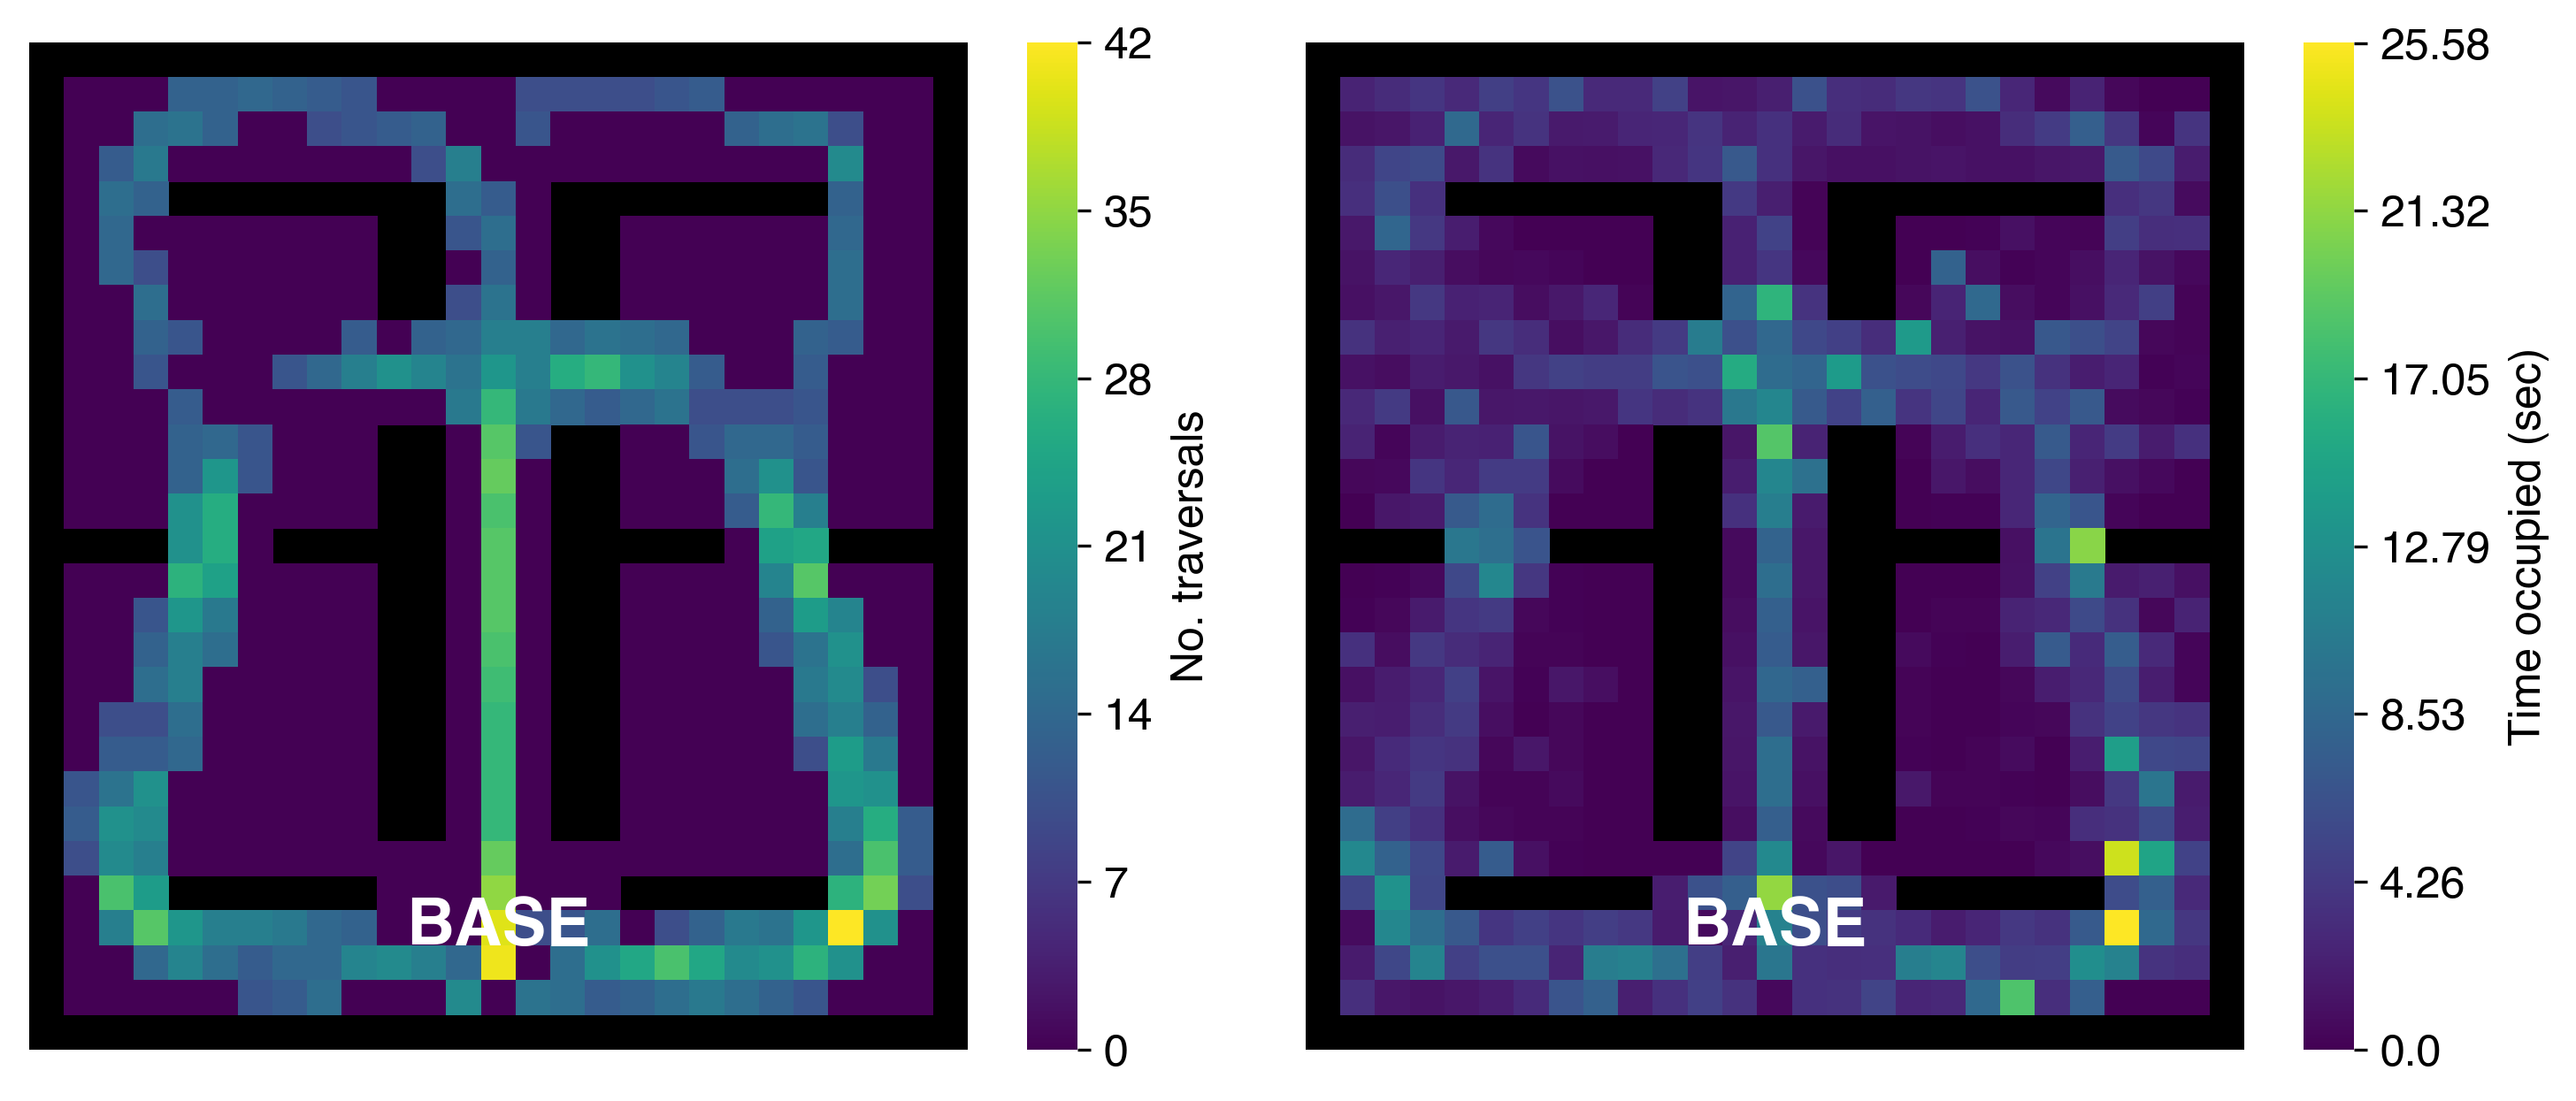

In [1955]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.25), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14
cmap = [(0, 0, 0)] + sns.color_palette('viridis', 500)

i = 0
maze_map = np.zeros(maze_shp)
for key, val in traversal_counts.items():
    maze_map[key] = val # number of times traversed
maze_map[maze_map<10] = 0

# Mask out unwanted regions.
mask_regions = ['wall']
mask = np.zeros(maze_shp)
for region in mask_regions:
    for idx, row in maze.query("(region=='{}')".format(region)).iterrows():
        (xmin, zmin), (xmax, zmax) = row.coords
        for x in range(xmin, xmax):
            for z in range(zmin, zmax):
                maze_map[x, z] = 0
                mask[x, z] = 1
vmin = 0
vmax = np.max(np.vstack([x for x in maze_map]))

ax[i] = sns.heatmap(maze_map.T[::-1], vmin=vmin, vmax=vmax,
                    square=True, cmap='viridis', mask=mask.T[::-1], ax=ax[i])
ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize+4, weight='bold', ha='center')
ax[i].set_facecolor('k')
ax[i].set_xticks([])
ax[i].set_yticks([])
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.linspace(vmin, vmax, 7, dtype=int))
cbar.set_ticklabels(np.linspace(vmin, vmax, 7, dtype=int))
cbar.set_label('No. traversals', fontsize=tickfontsize, labelpad=5)

# --------------------------------------

i = 1
total_dur = np.sum(list(traversal_durs.values()))
maze_map = np.zeros(maze_shp)
for key, val in traversal_durs.items():
#     maze_map[key] = 100 * (val / total_dur) # percent of total time occupied
    maze_map[key] = val * 1e-3
    
# Mask out unwanted regions.
mask_regions = ['wall']
mask = np.zeros(maze_shp)
for region in mask_regions:
    for idx, row in maze.query("(region=='{}')".format(region)).iterrows():
        (xmin, zmin), (xmax, zmax) = row.coords
        for x in range(xmin, xmax):
            for z in range(zmin, zmax):
                maze_map[x, z] = 0
                mask[x, z] = 1
vmin = 0
vmax = np.max(np.vstack([x for x in maze_map]))

ax[i] = sns.heatmap(maze_map.T[::-1], vmin=vmin, vmax=vmax,
                    square=True, cmap='viridis', mask=mask.T[::-1], ax=ax[i])
ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize+4, weight='bold', ha='center')
ax[i].set_facecolor('k')
ax[i].set_xticks([])
ax[i].set_yticks([])
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks([np.round(x, 2) for x in np.linspace(vmin, vmax-0.01, 7)])
cbar.set_ticklabels([np.round(x, 2) for x in np.linspace(vmin, vmax-0.01, 7)])
cbar.set_label('Time occupied (sec)', fontsize=tickfontsize, labelpad=5)

fig.tight_layout()

In [1888]:
traversal_time_bins[keep_squares[0]]

True

In [1885]:
simple_maze.groupby(['hem', 'region', 'proxim']).size()

hem  region  proxim
     wall    outer     4
C    base    near      1
     door              2
     hall    near      6
L    door              4
     hall    far       4
             near      3
     room    far       9
             near      9
     wall    inner     6
R    door              4
     hall    far       4
             near      3
     room    far       9
             near      9
     wall    inner     6
dtype: int64

## Older Delay Analysis

In [ ]:
## For each neuron, get the number of spikes in each time bin.
start_time = time()

spikes_by_time = []
for time_bins in event_times['time_bins']:
    spikes_by_time.append(np.array([[np.sum(np.logical_and(spikes.loc[iUnit, 'spike_times']>time_bins[iTime], 
                                                           spikes.loc[iUnit, 'spike_times']<=time_bins[iTime+1]))
                                     for iTime in range(len(time_bins)-1)]
                                    for iUnit in range(len(spikes))]))

# Combine time bins across trial phases in each trial.
trial_spikes_by_time = []
for iTrial in np.arange(0, len(spikes_by_time), step=len(game_states)):
    arr = [spikes_by_time[i] for i in np.arange(iTrial, iTrial+len(game_states))]
    trial_spikes_by_time.append(np.concatenate(arr, axis=1))
trial_spikes_by_time = np.swapaxes(trial_spikes_by_time, 0, 1) # neuron x trial x time_bin

# Define indices that the mark time bin boundaries:
# [start_delay1, start_encoding, start_delay2, start_retrieval]
time_bounds = np.array([0, 20, 80, 100, 160])

print('Done in {:.2f} secs'.format(time() - start_time))

In [283]:
sig_cells_delay = np.array([1, 6, 8, 12, 13, 14, 22, 25, 32, 35, 45, 46, 47, 48, 49, 50, 51, 52, 53])

In [577]:
mpoint = int(trial_spikes_by_time.shape[1]/2)

m = np.array([np.argmax(np.mean(trial_spikes_by_time[:, :, time_bounds[0]:time_bounds[1]], axis=1), axis=1),
              np.argmax(np.mean(trial_spikes_by_time[:, :, time_bounds[2]:time_bounds[3]], axis=1), axis=1)])
print('Delay 1 vs. Delay 2 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

m = np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[:, :mpoint, time_bounds[0]:time_bounds[1]], 
                                                trial_spikes_by_time[:, :mpoint, time_bounds[2]:time_bounds[3]]), 
                                               axis=1), axis=1), axis=1),
              np.argmax(np.mean(np.concatenate((trial_spikes_by_time[:, mpoint:, time_bounds[0]:time_bounds[1]], 
                                                trial_spikes_by_time[:, mpoint:, time_bounds[2]:time_bounds[3]]), 
                                               axis=1), axis=1), axis=1)])
print('Trials 1-18 vs. Trials 19-36 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

Delay 1 vs. Delay 2 max FR times: (0.19046880135924443, 0.15969442908335776)
Trials 1-18 vs. Trials 19-36 max FR times: (0.29692099361327184, 0.026268665746843656)


In [578]:
mpoint = int(trial_spikes_by_time.shape[1]/2)

m = np.array([np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, time_bounds[0]:time_bounds[1]], axis=1), axis=1),
              np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, time_bounds[2]:time_bounds[3]], axis=1), axis=1)])
print('Delay 1 vs. Delay 2 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

m = np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[0]:time_bounds[1]], 
                                                trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[2]:time_bounds[3]]), 
                                               axis=1), axis=1), axis=1),
              np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[0]:time_bounds[1]], 
                                                trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[2]:time_bounds[3]]), 
                                               axis=1), axis=1), axis=1)])
print('Trials 1-18 vs. Trials 19-36 max FR times:', stats.pearsonr(m[0, :], m[1, :]))

Delay 1 vs. Delay 2 max FR times: (0.39348839090995397, 0.09556163017343497)
Trials 1-18 vs. Trials 19-36 max FR times: (0.5932811983045507, 0.007415725280047222)


min=0.22


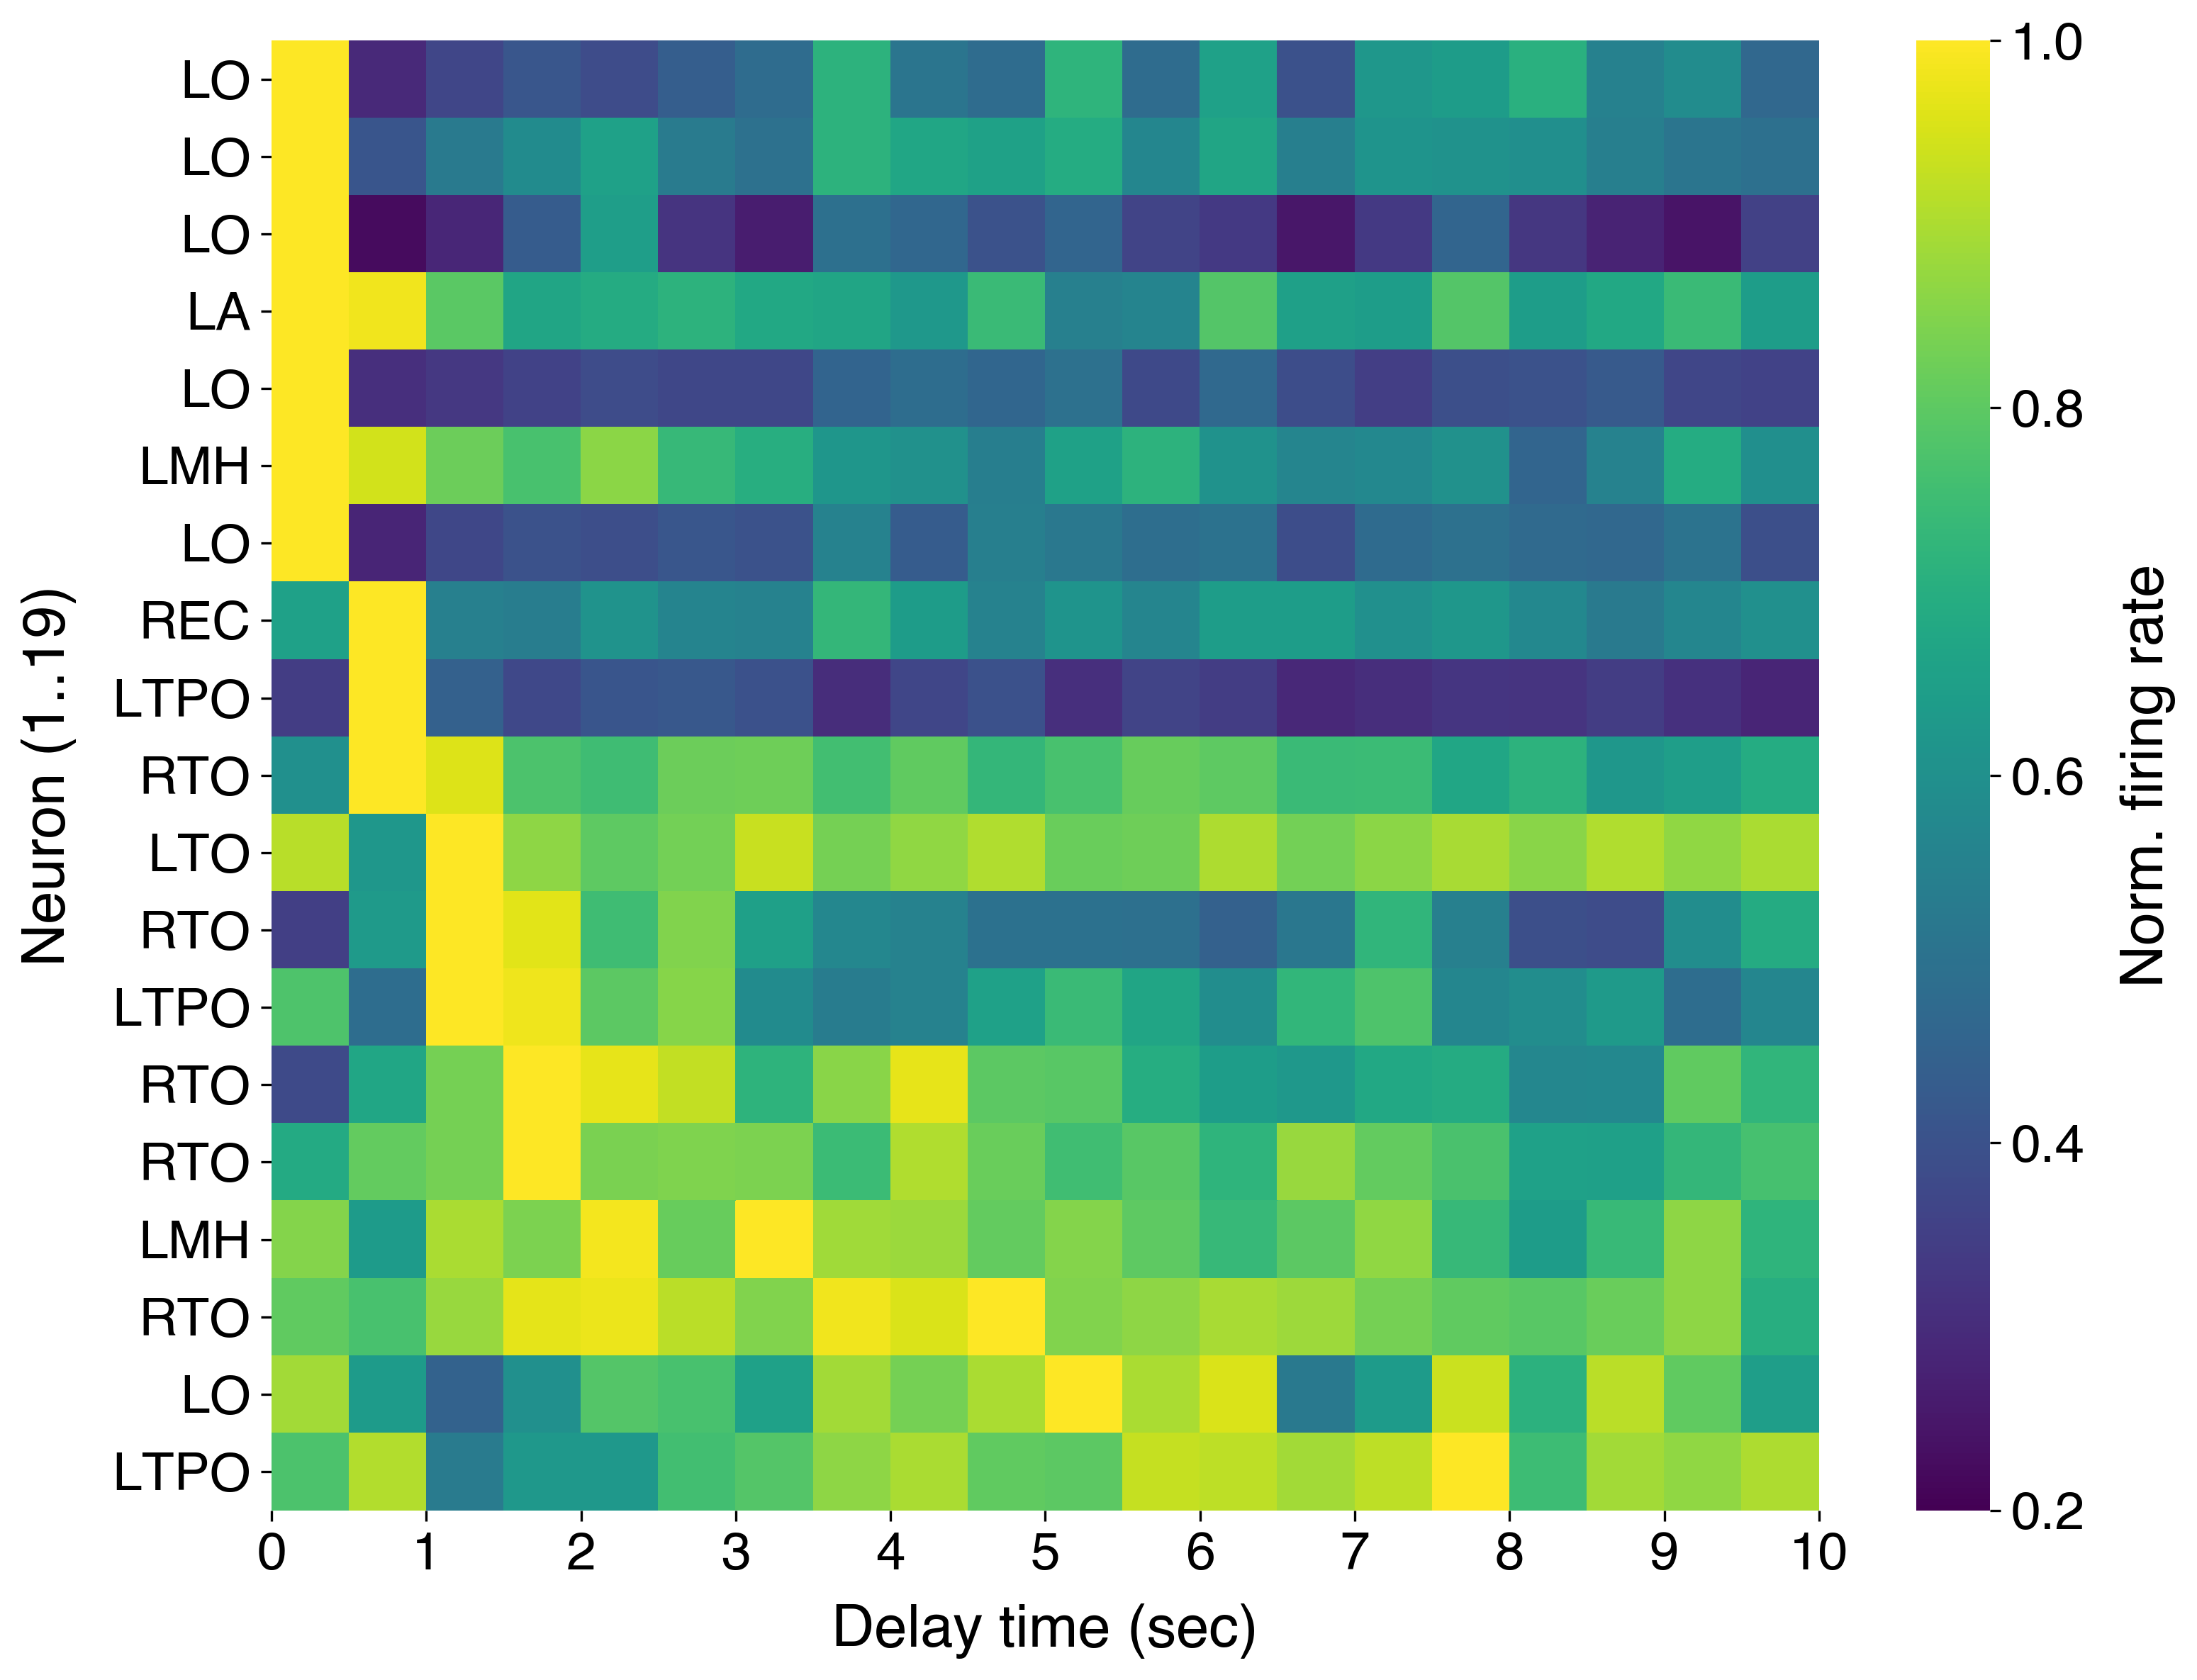

In [295]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = np.sum(np.concatenate((trial_spikes_by_time[sig_cells_delay, :, time_bounds[0]:time_bounds[1]], 
                                             trial_spikes_by_time[sig_cells_delay, :, time_bounds[2]:time_bounds[3]]), axis=1), 
                             axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(1, 1, figsize=(10.5, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 18
labelfontsize = 20

vmin = 0.2
vmax = 1

i = 0
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=True, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=12)
cbar = ax[i].collections[0].colorbar
cbar.set_ticks(np.linspace(0, 1, 6)[1:])
cbar.set_ticklabels([round(x, 1) for x in np.linspace(0, 1, 6)[1:]])
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.ax.ticklabel_format()
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=12)

fig.tight_layout()

min=0.22


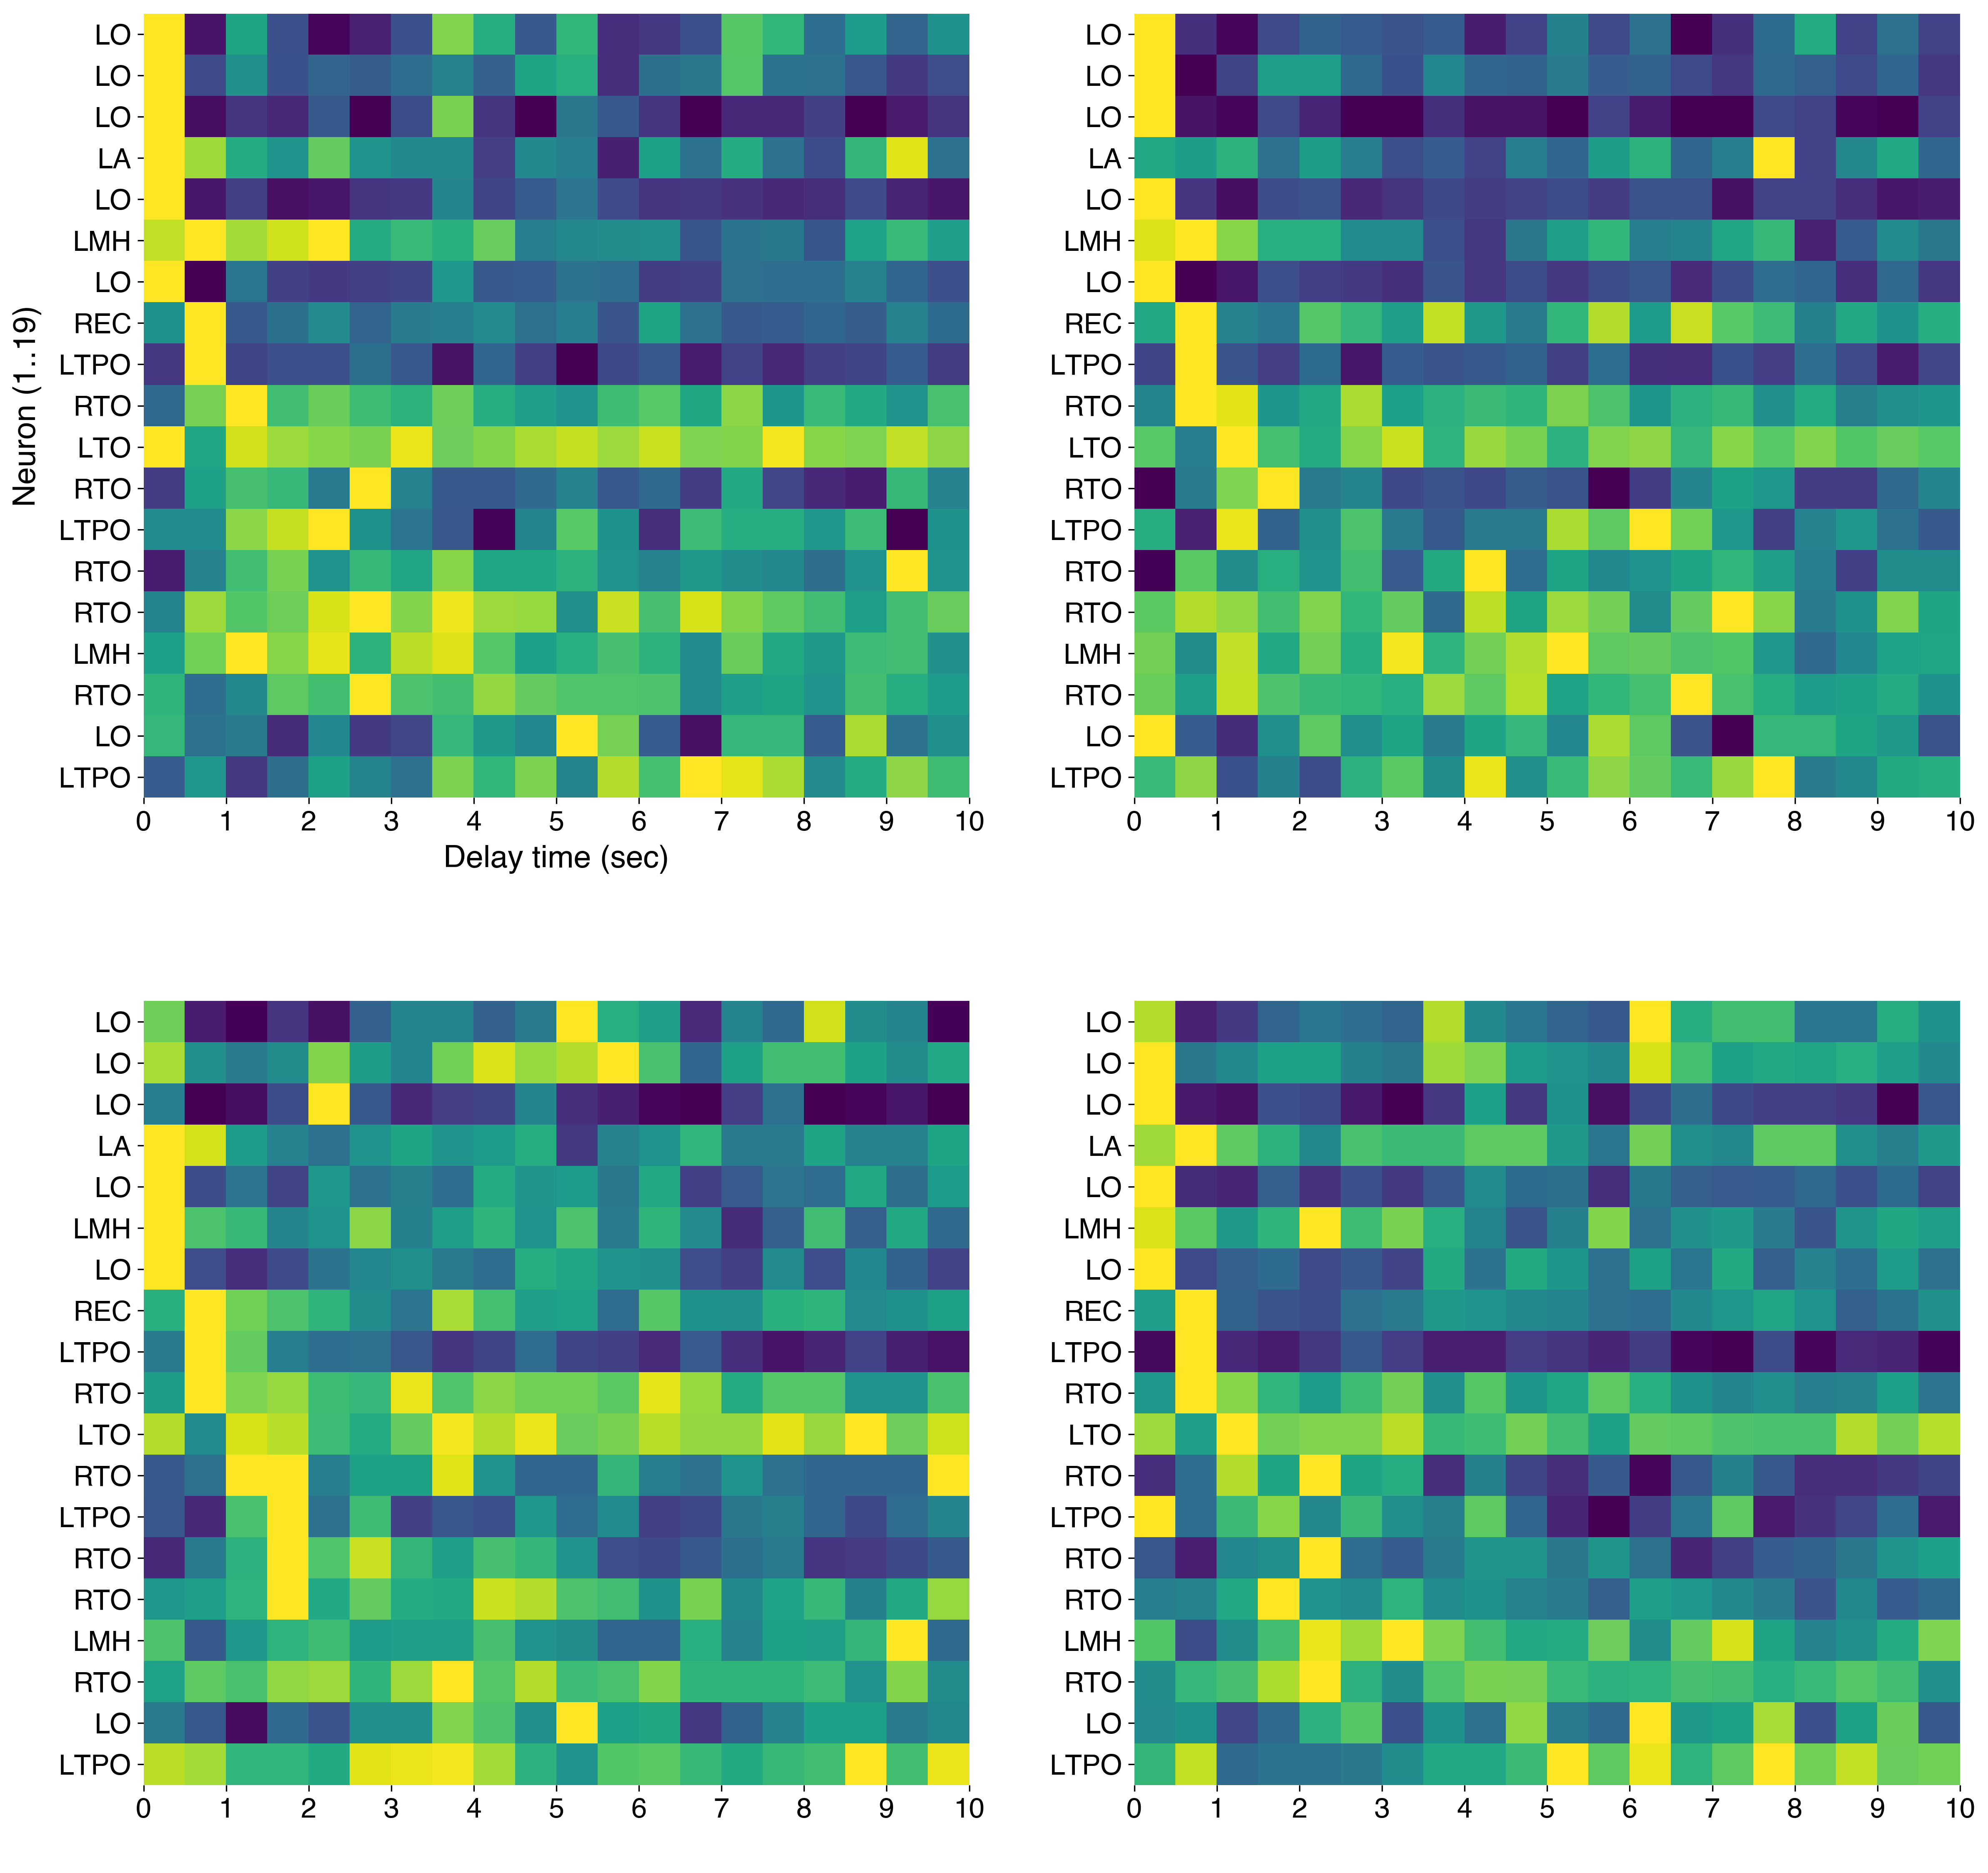

In [291]:
# For each neuron, add the number of spikes in each time bin, across all delay periods.
xtrial_delay_spikes = np.sum(np.concatenate((trial_spikes_by_time[sig_cells_delay, :, time_bounds[0]:time_bounds[1]], 
                                             trial_spikes_by_time[sig_cells_delay, :, time_bounds[2]:time_bounds[3]]), axis=1), 
                             axis=1) # neuron x time_bin
show_units_delay = sig_cells_delay[np.argsort(xtrial_delay_spikes.argmax(axis=1))]

# Sort neurons in order of time bin with the highest firing rate
dat = xtrial_delay_spikes[np.argsort(xtrial_delay_spikes.argmax(axis=-1)), :]

# For each cell, divide the firing rate in each time bin
# by the firing rate in its maximum time bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
print('min={:.2f}'.format(np.min(dat)))

fig, ax = plt.subplots(2, 2, figsize=(16, 16), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1

i = 0
dat = np.sum(trial_spikes_by_time[show_units_delay, :mpoint, time_bounds[0]:time_bounds[1]], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel('Delay time (sec)', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Neuron (1..{})'.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 1
dat = np.sum(trial_spikes_by_time[show_units_delay, :mpoint, time_bounds[2]:time_bounds[3]], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 2
dat = np.sum(trial_spikes_by_time[show_units_delay, mpoint:, time_bounds[0]:time_bounds[1]], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

i = 3
dat = np.sum(trial_spikes_by_time[show_units_delay, mpoint:, time_bounds[2]:time_bounds[3]], axis=1) # neuron x time_bin
dat = dat / np.expand_dims(np.max(dat, axis=-1), axis=-1)
ax[i] = sns.heatmap(dat, vmin=vmin, vmax=vmax, cmap='viridis', cbar=False, square=True, ax=ax[i])
ax[i].set_xticks(np.linspace(0, 20, 11))
ax[i].set_xticklabels(np.linspace(0, 10, 11, dtype=int), fontsize=tickfontsize, rotation=0)
ax[i].set_yticks(np.arange(dat.shape[0])+0.5)
ax[i].set_yticklabels(spikes.iloc[show_units_delay]['hemroi'], fontsize=tickfontsize, rotation=0)
ax[i].set_xlabel(' ', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel(' '.format(xtrial_delay_spikes.shape[0]), fontsize=labelfontsize, labelpad=10)

fig.tight_layout()

In [584]:
np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[0]:time_bounds[1]],
                trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[2]:time_bounds[3]]), axis=1).shape

(19, 36, 20)

In [590]:
# Calculate the Pearson correlation between firing rate vectors from the
# first and second half of the testing session.

# Trial 1-18 vs. 19-36 firing rate vectors (Delay 1 vs. Delay 1 and Delay 2 vs. Delay 2)
# ...Note each entry within split_frs is neuron x time (mean over delays)
mpoint = int(trial_spikes_by_time.shape[1]/2)
split_frs = [np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[0]:time_bounds[1]],
                                     trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[2]:time_bounds[3]]),
                                    axis=1), axis=1),
             np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[0]:time_bounds[1]],
                                     trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[2]:time_bounds[3]]),
                                    axis=1), axis=1)]

# Get the Pearson correlation between each pair of firing vectors.
fr_corrs = np.array([stats.pearsonr(split_frs[0][iUnit, :], split_frs[1][iUnit, :])[0]
                     for iUnit in range(len(sig_cells_delay))])
fr_pvals = np.array([stats.pearsonr(split_frs[0][iUnit, :], split_frs[1][iUnit, :])[1]
                     for iUnit in range(len(sig_cells_delay))])

# FDR correct Pearson p-values for multiple comparisons.
alpha = 0.05
sig_out, *_ = sm.stats.multipletests(fr_pvals, alpha=alpha, method='fdr_tsbky')
print('{}/{} ({:.1f}%) time cells have significantly correlated firing rate vectors between the 1st and 2nd half of the session.'
      .format(np.sum(sig_out), len(sig_out), 100 * np.sum(sig_out) / len(sig_out)))

15/19 (78.9%) time cells have significantly correlated firing rate vectors between the first and second half of the session.


In [494]:
# Calculate the Pearson correlation between firing rate vectors from the
# first and second half of the testing session, comparing Delay 1 to Delay 1,
# Delay 2 to Delay 2, Delay 1 to Delay 2, and Delay 2 to Delay 1.

# Trial 1-18 vs. 19-36 firing rate vectors (Delay 1 vs. Delay 1 and Delay 2 vs. Delay 2)
# ...Note each entry within split_frs is neuron x time (mean over delays)
mpoint = int(trial_spikes_by_time.shape[1]/2)
split_frs = od([('match', [[np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[0]:time_bounds[1]], axis=1), 
                            np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[0]:time_bounds[1]], axis=1)],
                           [np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[2]:time_bounds[3]], axis=1),
                            np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[2]:time_bounds[3]], axis=1)]]),
                ('mismatch', [[np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[0]:time_bounds[1]], axis=1),
                               np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[2]:time_bounds[3]], axis=1)],
                              [np.mean(trial_spikes_by_time[sig_cells_delay, :mpoint, time_bounds[2]:time_bounds[3]], axis=1),
                               np.mean(trial_spikes_by_time[sig_cells_delay, mpoint:, time_bounds[0]:time_bounds[1]], axis=1)]])])

# Get the Pearson correlation between each pair of firing vectors.
fr_corrs = od()
fr_pvals = od()
for cond in ['match', 'mismatch']:
    fr_corrs[cond] = []
    fr_pvals[cond] = []
    for ii in range(2):
        fr_corrs[cond].append([stats.pearsonr(split_frs[cond][ii][0][iUnit, :], split_frs[cond][ii][1][iUnit, :])[0]
                               for iUnit in range(len(sig_cells_delay))])
        fr_pvals[cond].append([stats.pearsonr(split_frs[cond][ii][0][iUnit, :], split_frs[cond][ii][1][iUnit, :])[1]
                               for iUnit in range(len(sig_cells_delay))])
    fr_corrs[cond] = np.array(fr_corrs[cond])
    fr_pvals[cond] = np.array(fr_pvals[cond])

# FDR correct Pearson p-values for multiple comparisons.
alpha = 0.05
sig_out, *_ = sm.stats.multipletests(fr_pvals['match'].flatten(), alpha=alpha, method='fdr_tsbky')
print('{}/{} ({:.1f}%) neurons have significantly correlated firing rate vectors.'
      .format(np.sum(sig_out), len(sig_out), 100 * np.sum(sig_out) / len(sig_out)))

In [582]:
alpha = 0.05
sig_out, *_ = sm.stats.multipletests(fr_pvals['match'].flatten(), alpha=alpha, method='fdr_tsbky')
print('{}/{} ({:.1f}%) neurons have significantly correlated firing rate vectors.'
      .format(np.sum(sig_out), len(sig_out), 100 * np.sum(sig_out) / len(sig_out)))

16/38 (42.10526315789474%) neurons have significantly correlated firing rate vectors.


In [580]:
sig_out

array([ True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False,  True,  True, False,
       False,  True, False,  True, False, False,  True, False, False,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True, False])

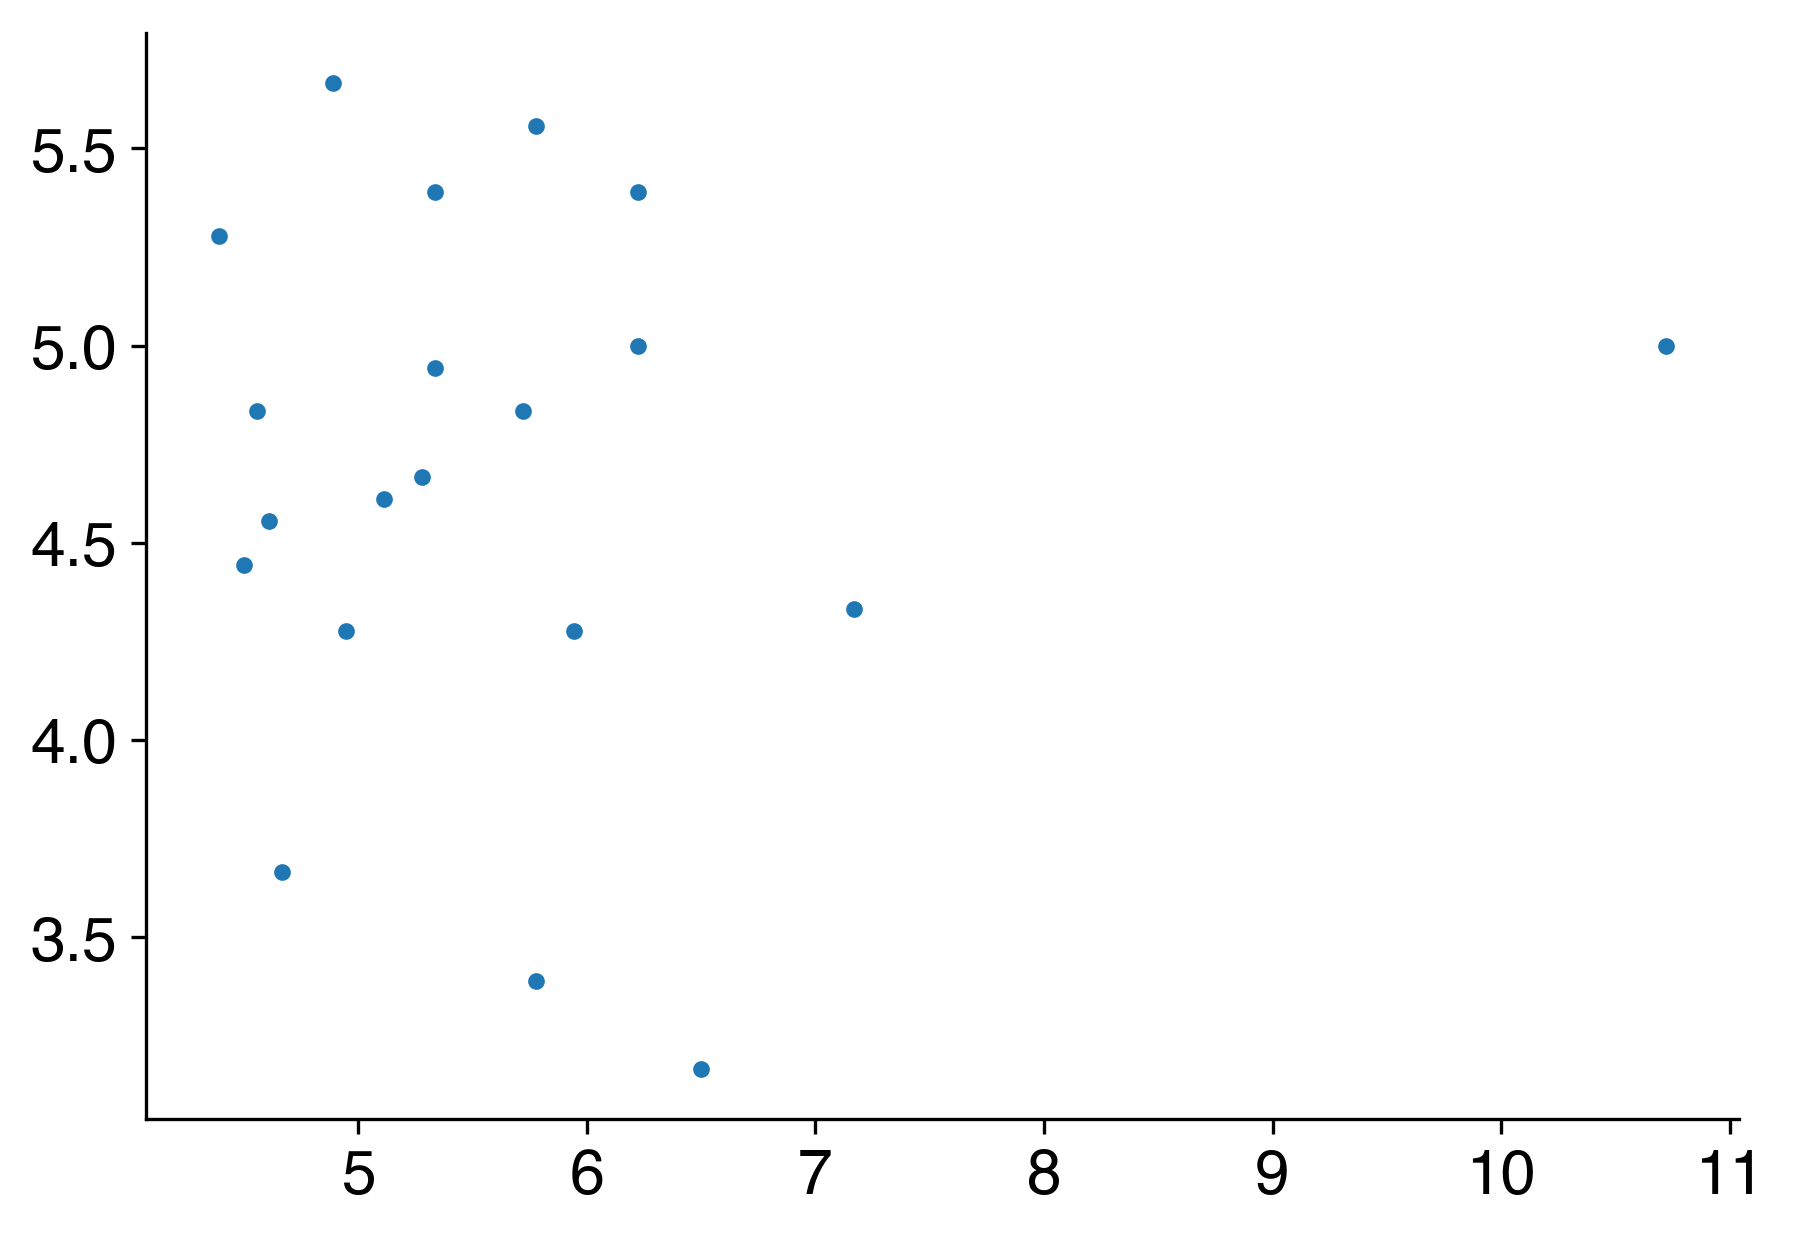

In [411]:
iUnit = 0
plt.scatter(split_frs['match'][0][0][iUnit, :], split_frs['match'][0][0][iUnit+1, :])

In [343]:
# Does the similarity between firing rate vectors across the delay interval
# differ when comparing Delay 1 and Delay 2 vs. trials 1-18 and 19-36?
# (For each neuron, calculate the Pearson correlation for these two comparisons,
#  where firing rate at each timepoint is a mean across trials.)
fr_corrs = []

# Trial 1-18 vs. trial 19-36 firing rate vectors (Delay 1 + Delay 2)
mpoint = int(trial_spikes_by_time.shape[1]/2)
trial_split_frs = [np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], 
                                           trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1),
                   np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, :20], 
                                           trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100]), axis=1), axis=1)]
fr_corrs.append([stats.pearsonr(trial_split_frs[0][iUnit, :], trial_split_frs[1][iUnit, :])[0] for iUnit in range(trial_split_frs[0].shape[0])])

# Delay 1 vs. Delay 2 firing rate vectors (trials 1-36)
delay_frs = [np.mean(trial_spikes_by_time[sig_cells_delay, :, :20], axis=1), np.mean(trial_spikes_by_time[sig_cells_delay, :, 80:100], axis=1)]
fr_corrs.append([stats.pearsonr(delay_frs[0][iUnit, :], delay_frs[1][iUnit, :])[0] for iUnit in range(delay_frs[0].shape[0])])

fr_corrs = np.array(fr_corrs)

In [491]:
fr_corrs['match'].shape

(2, 19)

In [492]:
print(np.mean(fr_corrs['match'], axis=1), np.mean(fr_corrs['mismatch'], axis=1))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['match'][1, :]))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['mismatch'][0, :]))
print(stats.ttest_rel(fr_corrs['match'][0, :], fr_corrs['mismatch'][1, :]))
print(stats.ttest_rel(fr_corrs['match'][1, :], fr_corrs['mismatch'][0, :]))
print(stats.ttest_rel(fr_corrs['match'][1, :], fr_corrs['mismatch'][1, :]))

[0.38063759 0.45002451] [0.4199171  0.33509629]
Ttest_relResult(statistic=-0.9950219448079325, pvalue=0.3329144580269445)
Ttest_relResult(statistic=-0.6611321169761588, pvalue=0.5169013295266123)
Ttest_relResult(statistic=0.8629764950081334, pvalue=0.39950307443927746)
Ttest_relResult(statistic=0.8887011106861239, pvalue=0.3858862584298455)
Ttest_relResult(statistic=2.082191504261555, pvalue=0.051865907359078735)


In [344]:
stats.ttest_rel(fr_corrs[0, :], fr_corrs[1, :])

Ttest_relResult(statistic=0.6989644485808546, pvalue=0.49350765727442514)

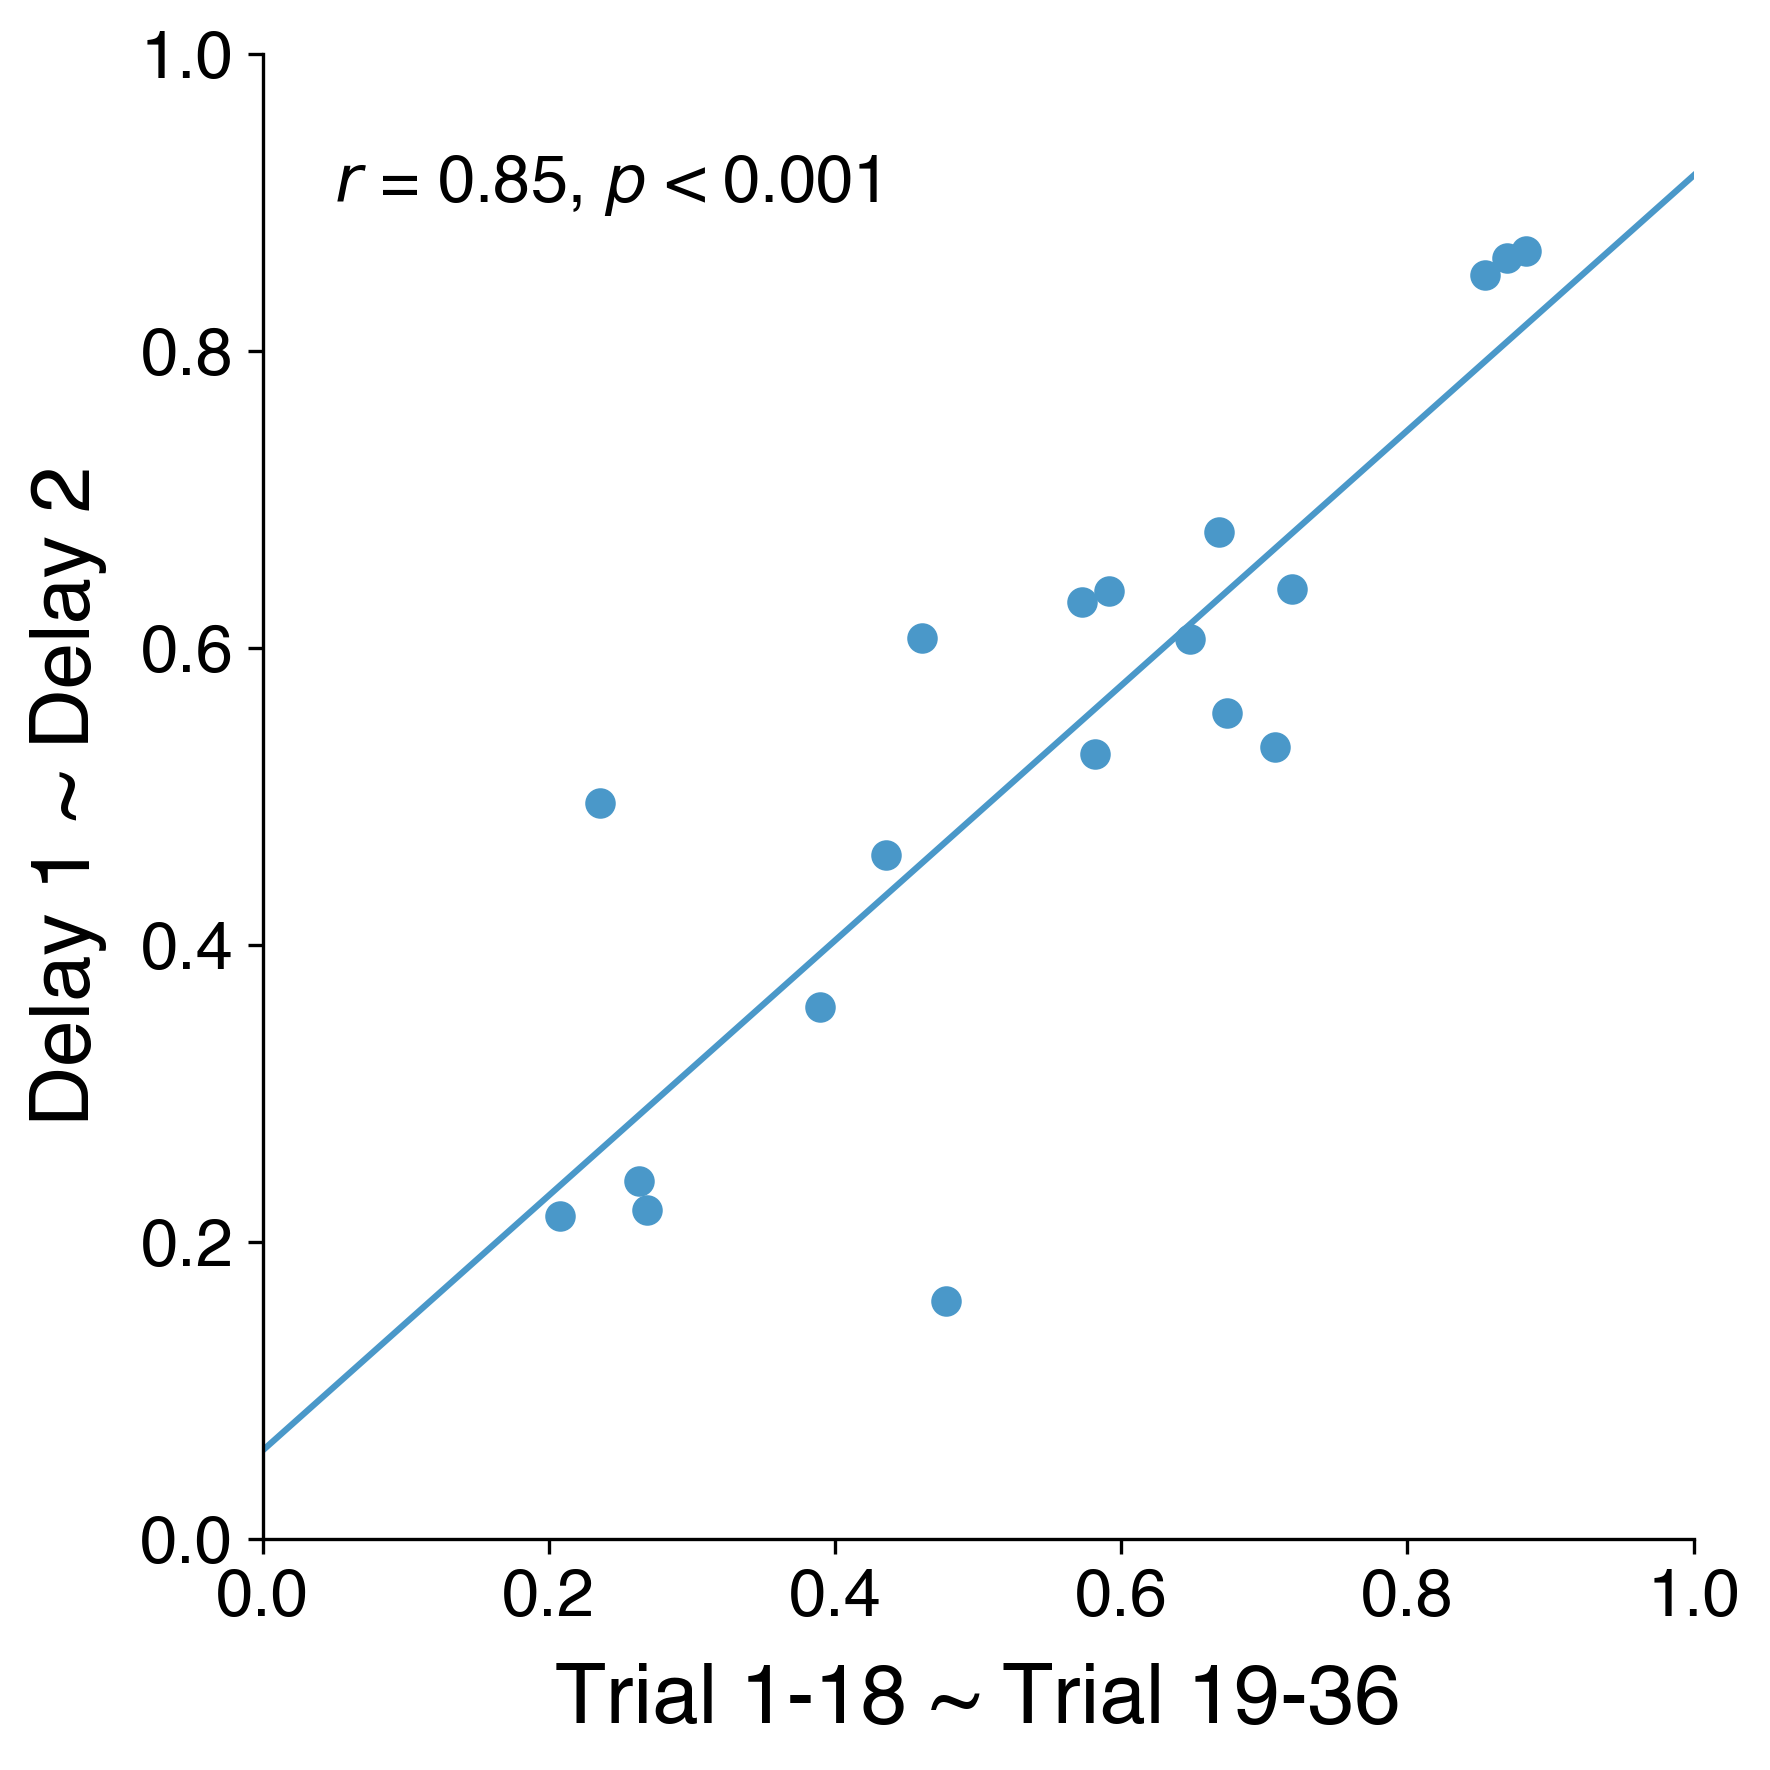

In [359]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax = np.ravel(ax)

tickfontsize = 16
labelfontsize = 20

ax_min = 0
ax_max = 1
x_pred = np.linspace(ax_min, ax_max, 100)

i = 0
slope, icpt, r, p, _ = stats.linregress(fr_corrs[0, :], fr_corrs[1, :])
ax[i].plot(x_pred, icpt + (slope*x_pred), color=colors[0], linewidth=1.5)
ax[i].scatter(fr_corrs[0, :], fr_corrs[1, :], s=40, color=colors[0])
ax[i].set_xlim([ax_min, ax_max])
ax[i].set_xticks(np.arange(0, ax_max + 0.1, 0.2))
ax[i].set_xticklabels(np.round(np.arange(0, ax_max + 0.1, 0.2), 2), fontsize=tickfontsize)
ax[i].set_xlabel('Trial 1-18 ~ Trial 19-36', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylim([ax_min, ax_max])
ax[i].set_yticks(np.arange(0, ax_max + 0.1, 0.2))
ax[i].set_yticklabels(np.round(np.arange(0, ax_max + 0.1, 0.2), 2), fontsize=tickfontsize)
ax[i].set_ylabel('Delay 1 ~ Delay 2', fontsize=labelfontsize, labelpad=8)
if p < 0.001:
    ax[i].annotate('$r$ = {:.2f}, $p$ < 0.001'.format(r, p), (0.05, 0.9), xycoords='axes fraction', fontsize=tickfontsize, ha='left')
else:
    ax[i].annotate('$r$ = {:.2f}, $p$ = {:.3f}'.format(r, p), (0.05, 0.9), xycoords='axes fraction', fontsize=tickfontsize, ha='left')

fig.tight_layout()

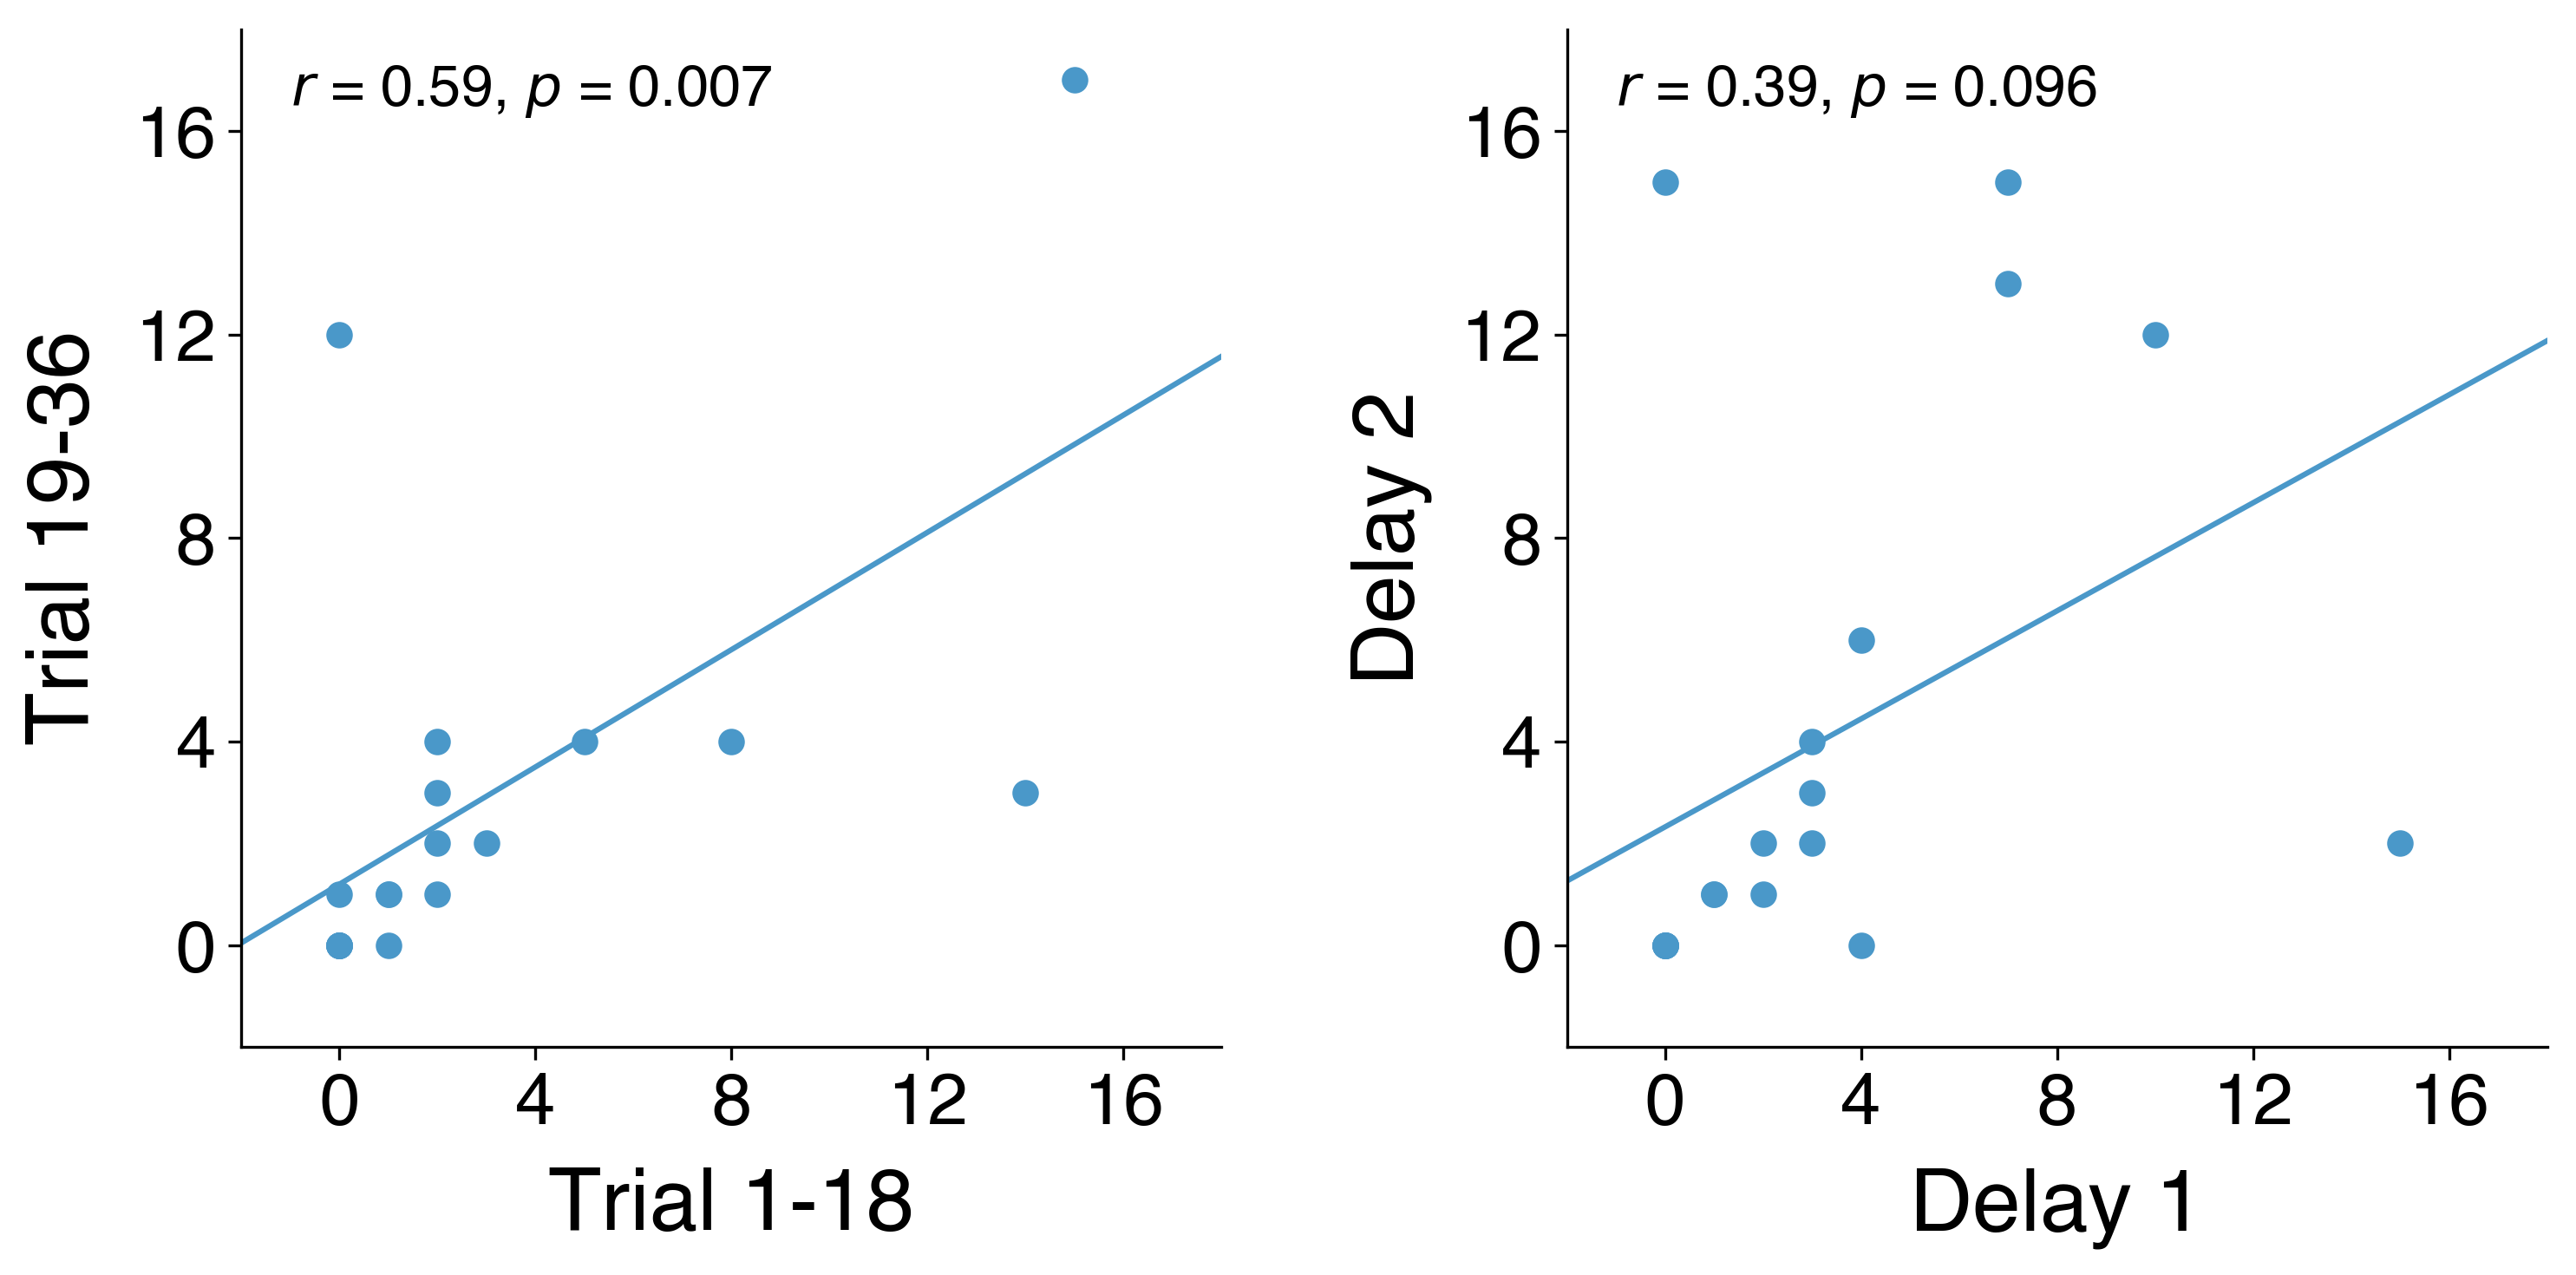

In [320]:
mpoint = int(trial_spikes_by_time.shape[1]/2)
# dat = [np.array([np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, :mpoint, :20], 
#                                                 trial_spikes_by_time[sig_cells_delay, :mpoint, 80:100]), axis=1), axis=1), axis=1),
#               np.argmax(np.mean(np.concatenate((trial_spikes_by_time[sig_cells_delay, mpoint:, :20], 
#                                                 trial_spikes_by_time[sig_cells_delay, mpoint:, 80:100]), axis=1), axis=1), axis=1)]),
#        np.array([np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, :20], axis=1), axis=1),
#                 np.argmax(np.mean(trial_spikes_by_time[sig_cells_delay, :, 80:100], axis=1), axis=1)])]

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 20
labelfontsize = 24
labs = [['Trial 1-18', 'Trial 19-36'], ['Delay 1', 'Delay 2']]
ax_min = -2
ax_max = 18
x_pred = np.linspace(ax_min, ax_max, 100)

for i in range(len(ax)):
    slope, icpt, r, p, _ = stats.linregress(dat[i][0, :], dat[i][1, :])
    ax[i].plot(x_pred, icpt + (slope*x_pred), color=colors[0], linewidth=1.5)
    ax[i].scatter(dat[i][0, :], dat[i][1, :], s=40, color=colors[0])
    ax[i].set_xlim([ax_min, ax_max])
    ax[i].set_xticks(np.arange(0, ax_max, 4, dtype=int))
    ax[i].set_xticklabels(np.arange(0, ax_max, 4, dtype=int), fontsize=tickfontsize)
    ax[i].set_xlabel(labs[i][0], fontsize=labelfontsize, labelpad=8)
    ax[i].set_ylim([ax_min, ax_max])
    ax[i].set_yticks(np.arange(0, ax_max, 4, dtype=int))
    ax[i].set_yticklabels(np.arange(0, ax_max, 4, dtype=int), fontsize=tickfontsize)
    ax[i].set_ylabel(labs[i][1], fontsize=labelfontsize, labelpad=8)
    ax[i].annotate('$r$ = {:.2f}, $p$ = {:.3f}'.format(r, p), (0.05, 0.925), xycoords='axes fraction', fontsize=tickfontsize-4, ha='left')

fig.tight_layout(w_pad=3.5)

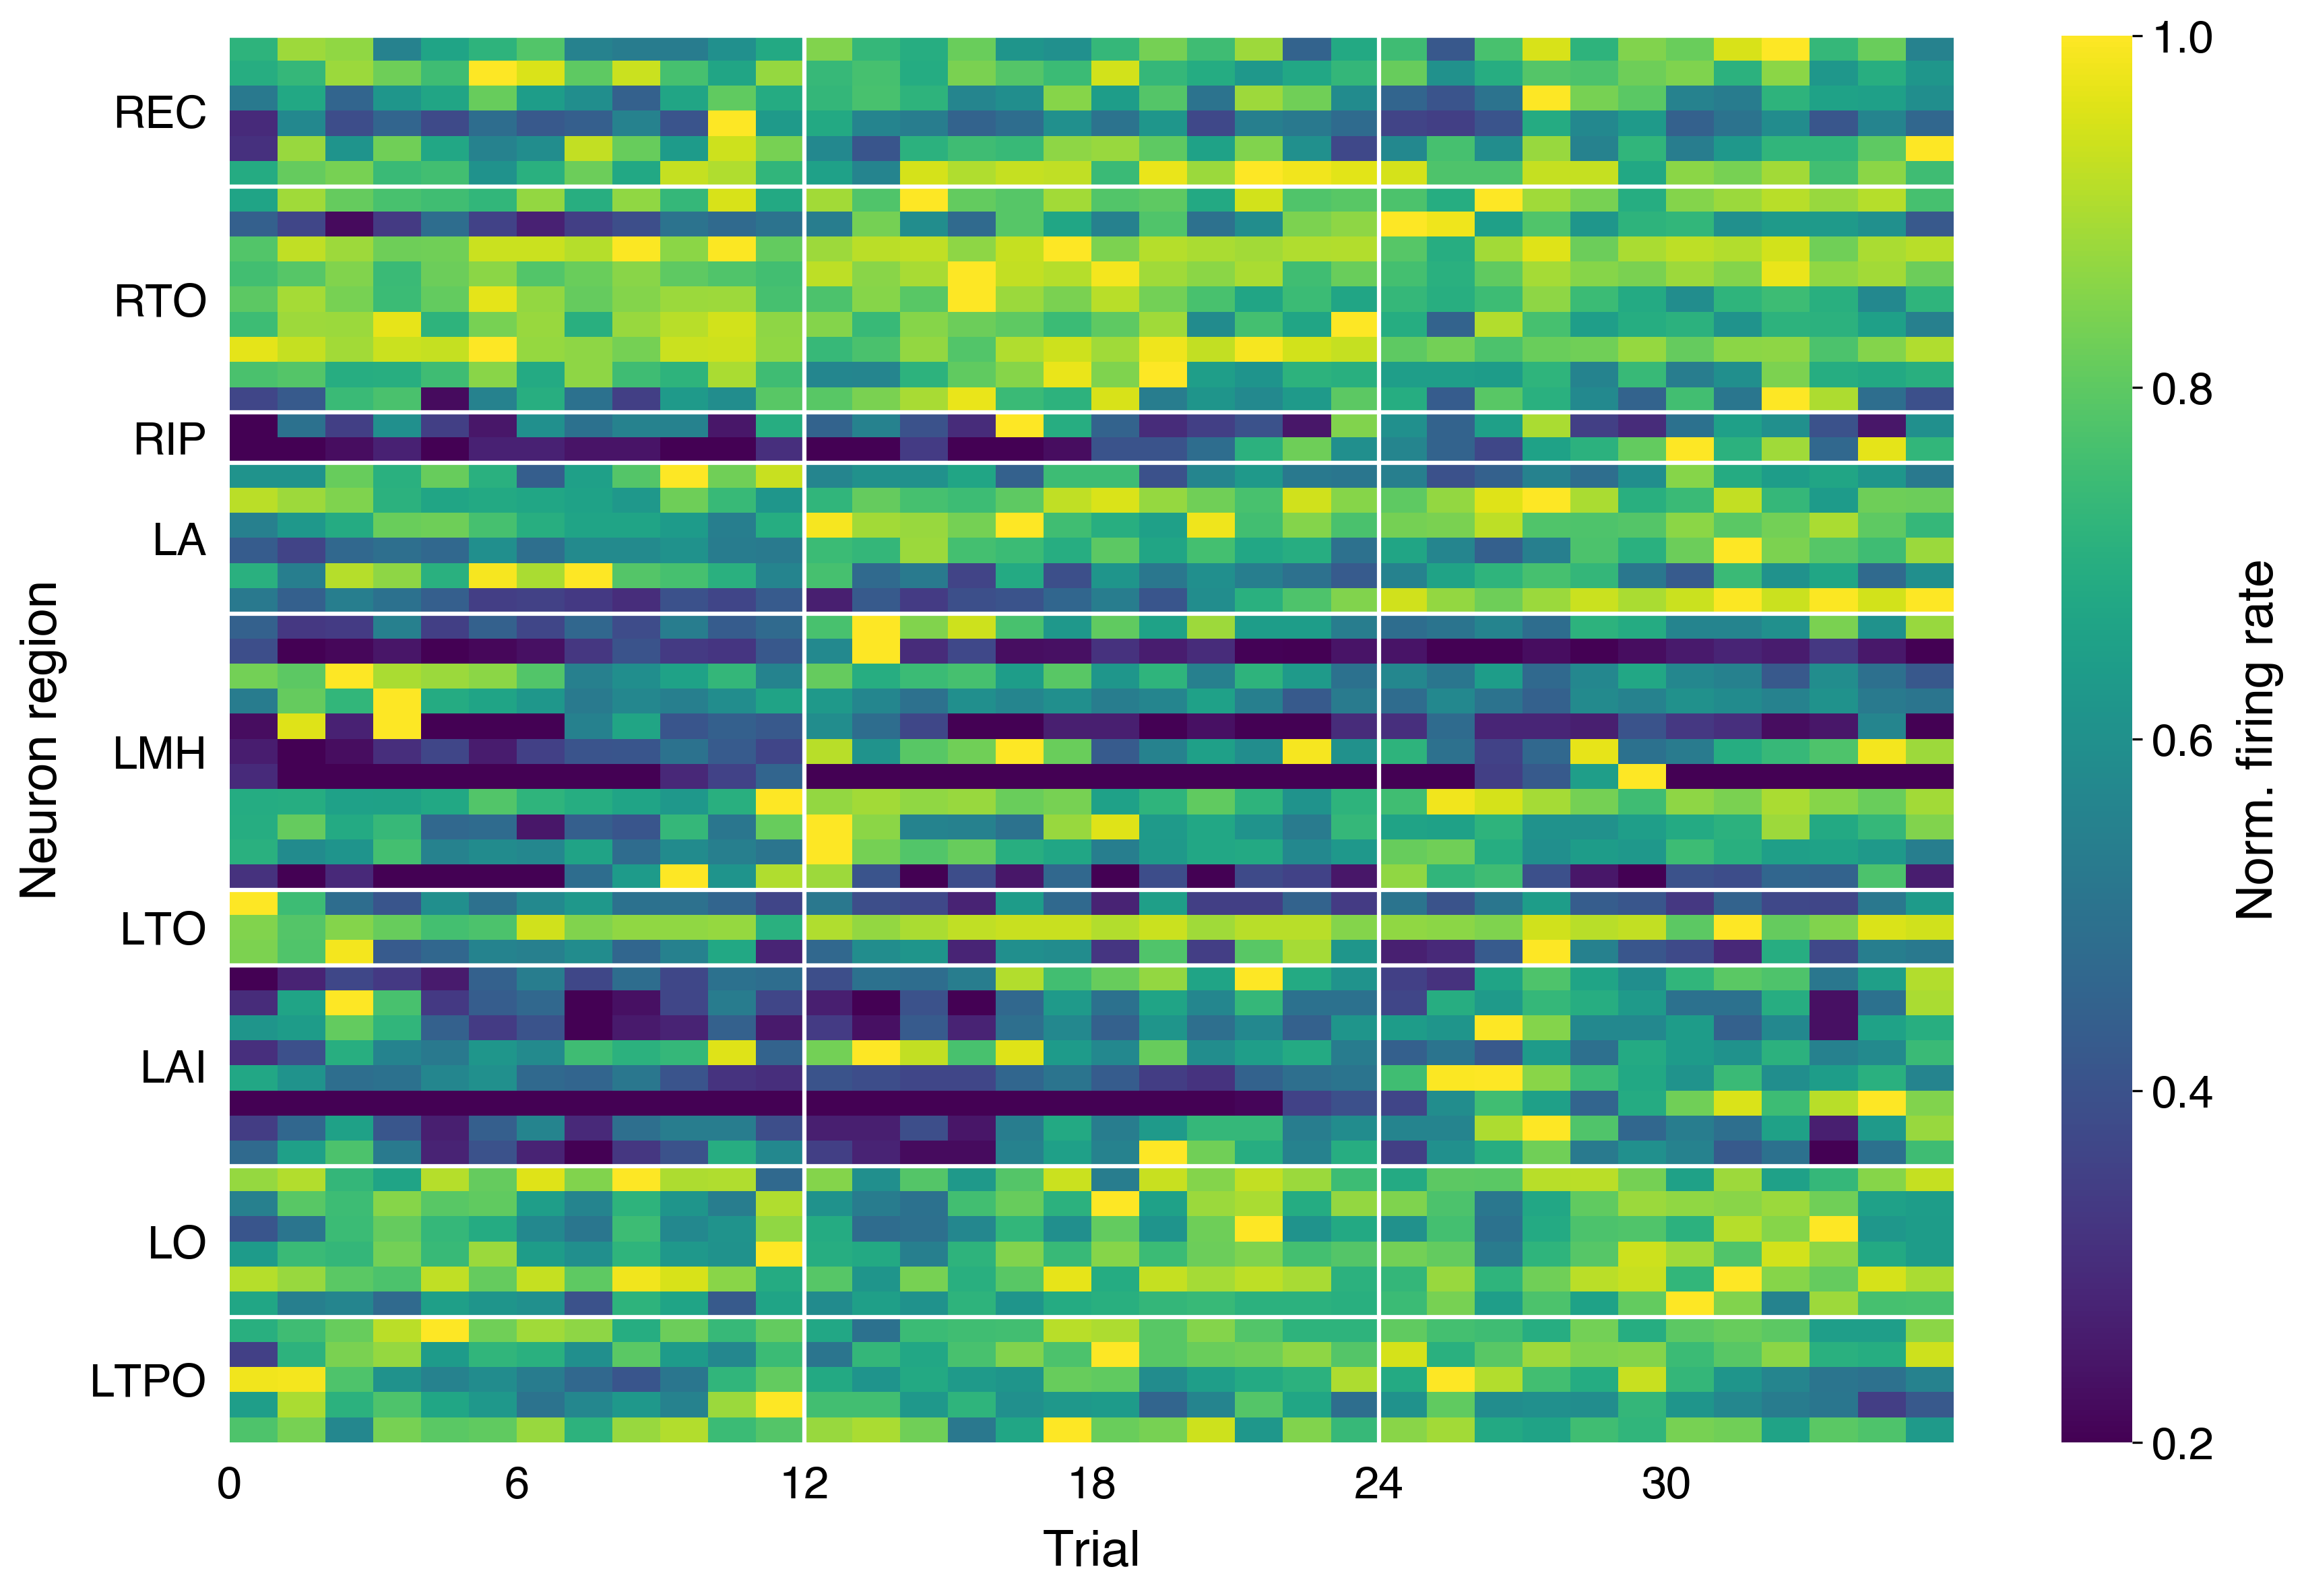

In [253]:
# Mean across times in each trial, for each neuron.
dat = np.sum(trial_spikes_by_time, axis=2) # neuron x trial
dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
tickfontsize = 16
labelfontsize = 18

vmin = 0.2
vmax = 1
xticks = [10, 50, 90, 130]
yticks = (list(np.array(list(rois.values()))[:, 1][:-1] + np.diff(np.array(list(rois.values()))[:, 1])/2) 
          + [np.array(list(rois.values()))[-1, 1] + (np.array(list(rois.values()))[-1, 0]/2)])

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = [20, 80, 100, 160]
for breakTime in [12, 24]:
    ax.axvline(x=breakTime, color='w', linewidth=1.5, alpha=1)
for iRoi in range(len(rois)):
    ax.axhline(y=np.array(list(rois.values()))[:, 1][iRoi], color='w', linewidth=1.5, alpha=1)
ax.tick_params(axis='both', which='both', length=0, pad=8)
ax.set_xticks(np.arange(0, 36, 6))
ax.set_xticklabels(np.arange(0, 36, 6, dtype=int), fontsize=tickfontsize, rotation=0)
ax.set_xlabel('Trial', fontsize=labelfontsize, labelpad=8)
ax.set_yticks(yticks)
ax.set_yticklabels(list(rois.keys()), fontsize=tickfontsize)
ax.set_ylabel('Neuron region', fontsize=labelfontsize, labelpad=8)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_ticklabels(np.round(np.arange(vmin, vmax+0.1, 0.2), 2))
cbar.set_label('Norm. firing rate', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()

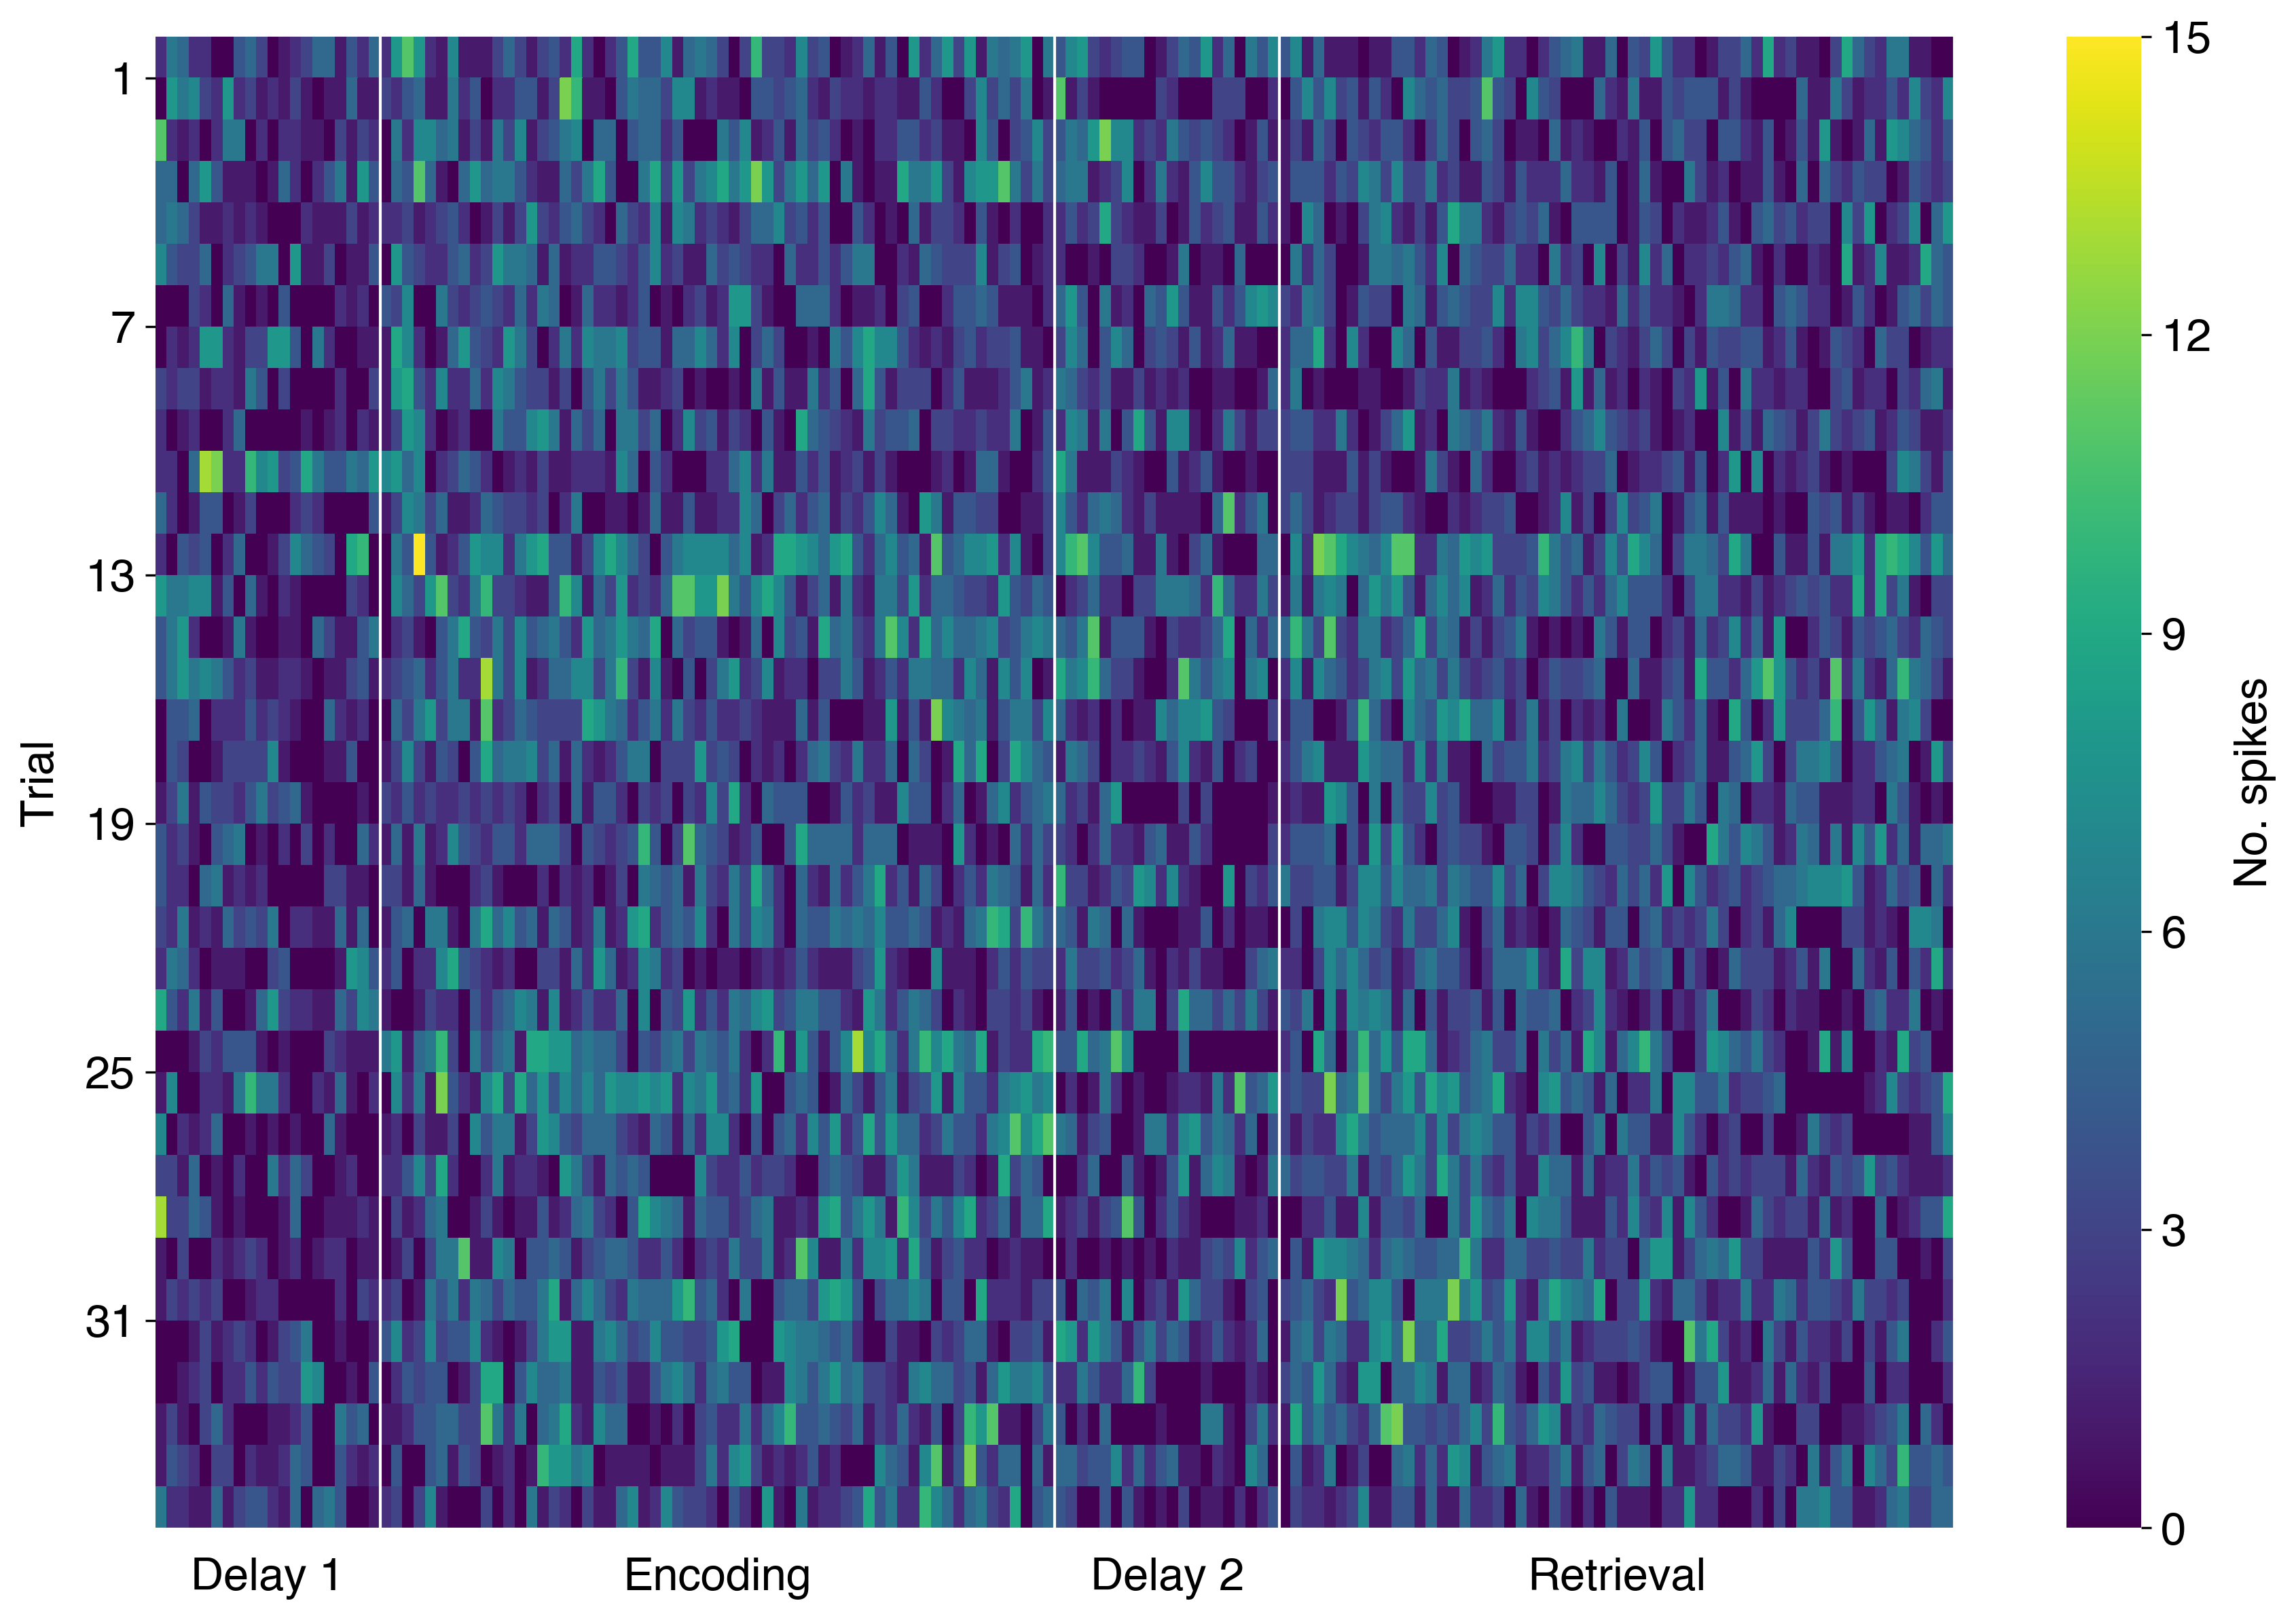

In [191]:
# Single neuron, trial x time.
iUnit = 32

dat = trial_spikes_by_time[iUnit, :, :] # trial x time
#dat = dat / np.expand_dims(np.max(dat, axis=1), axis=-1)
#dat = dat[np.argsort(dat.argmax(axis=-1)), :]

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=300)
labelfontsize = 16
tickfontsize = 16

vmin = 0
vmax = np.max(dat)

ax = sns.heatmap(dat, ax=ax,
                 vmin=vmin, vmax=vmax, cmap='viridis')
trial_phase_divides = [20, 80, 100, 160]
for iState, trial_phase_divide in enumerate(trial_phase_divides):
    ax.axvline(x=trial_phase_divide, color='w', linewidth=1, alpha=1)
ax.set_xticks([])
ax.set_yticks(np.arange(1, 37, 6))
ax.set_yticklabels(np.arange(1, 37, 6, dtype=int), fontsize=tickfontsize, rotation=0)
ax.set_ylabel('Trial', fontsize=labelfontsize, labelpad=8)

ax.annotate('Delay 1', (10, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Encoding', (50, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Delay 2', (90, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)
ax.annotate('Retrieval', (130, len(dat)+1.5), fontsize=tickfontsize, ha='center', annotation_clip=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
cbar.set_ticklabels(np.arange(vmin, vmax+1, int(vmax/6)+1, dtype=int))
cbar.set_label('No. spikes', fontsize=labelfontsize, labelpad=8)
    
fig.tight_layout()